In [24]:
## Data Connect / process
from snowflake.snowpark.session import Session
import toml
import numpy as np
import pandas as pd
import sys

## Machine Learning
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pmdarima.arima import ARIMA
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

In [25]:
##Data viz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline

## Default settings
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [26]:
secrets = toml.load("secrets.toml")

accountname = secrets["SNOWFLAKE"]["account"]
user = secrets["SNOWFLAKE"]["user"]
password = secrets["SNOWFLAKE"]["password"]
role = secrets["SNOWFLAKE"]["role"]
database = secrets["SNOWFLAKE"]["database"]
schema = secrets["SNOWFLAKE"]["schema"]
warehouse = secrets["SNOWFLAKE"]["warehouse"]

connection_parameters = {
    "account": accountname,
    "user": user,
    "password": password,
    "role": role,
    "database": database,
    "schema": schema,
    "warehouse": warehouse,
    "ocsp_fail_open":"False"
}

session = Session.builder.configs(connection_parameters).create()

In [27]:
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

[Row(CURRENT_WAREHOUSE()='STOCK_PRED_WH', CURRENT_DATABASE()='STOCK_PRED_DB', CURRENT_SCHEMA()='STOCK_PRED_SCHEMA')]


In [76]:
price_sdf = session.table('historical_prices')
print(type(price_sdf))

<class 'snowflake.snowpark.table.Table'>


In [77]:
price_data = price_sdf.collect()
price_df = pd.DataFrame(price_data, columns=price_data[0]._fields)

In [78]:
# Compare size
print('Size in MB of Snowpark DataFrame in Memory:', np.round(sys.getsizeof(price_sdf) / (1024.0**2), 2))
print('Size in MB of Pandas DataFrame in Memory:', np.round(sys.getsizeof(price_df) / (1024.0**2), 2))

Size in MB of Snowpark DataFrame in Memory: 0.0
Size in MB of Pandas DataFrame in Memory: 0.47


In [79]:
price_df

HIGH         LOW        OPEN       CLOSE     VOLUME    ADJCLOSE  \
0     158.119995  156.660004  157.559998  157.960007   565185.0  157.960007   
1            NaN         NaN         NaN         NaN        NaN         NaN   
2     160.279999  158.460007  158.660004  159.580002   540877.0  159.580002   
3     160.479996  158.960007  159.320007  160.300003   422036.0  160.300003   
4     158.119995  156.660004  157.559998  157.960007   565185.0  157.960007   
...          ...         ...         ...         ...        ...         ...   
3281  167.940002  160.419998  160.979996  167.940002  3565448.0  167.940002   
3282  158.119995  156.660004  157.559998  157.960007   565185.0  157.960007   
3283         NaN         NaN         NaN         NaN        NaN         NaN   
3284  160.279999  158.460007  158.660004  159.580002   540877.0  159.580002   
3285  160.479996  158.960007  159.320007  160.300003   422036.0  160.300003   

            DATE TICKER  
0     2023-06-12  AI.PA  
1     2023-06-13  AI.PA  
2     2023-06-14  AI.PA  
3     2023-06-15  AI.PA  
4     2023-06-12  AI.PA  
...          ...    ...  
3281  2023-06-16  AI.PA  
3282  2023-06-12  AI.PA  
3283  2023-06-13  AI.PA  
3284  2023-06-14  AI.PA  
3285  2023-06-15  AI.PA  

[3286 rows x 8 columns]

## Data Preprocessing

In [80]:
price_df.shape

(3286, 8)

In [81]:
price_df.isna().sum()

HIGH        5
LOW         5
OPEN        5
CLOSE       5
VOLUME      5
ADJCLOSE    5
DATE        0
TICKER      0
dtype: int64

In [89]:
price_df.dropna(axis=0, inplace=True)  # Drops rows with NaN values

In [90]:
price_df.duplicated().sum()

0

In [91]:
price_df.drop_duplicates(subset='DATE', keep="last",inplace=True)
price_df.duplicated().sum()
price_df.shape

(3269, 8)

In [92]:
price_df = price_df.sort_values(by='DATE',ignore_index=True)

In [93]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269 entries, 0 to 3268
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   HIGH      3269 non-null   float64
 1   LOW       3269 non-null   float64
 2   OPEN      3269 non-null   float64
 3   CLOSE     3269 non-null   float64
 4   VOLUME    3269 non-null   float64
 5   ADJCLOSE  3269 non-null   float64
 6   DATE      3269 non-null   object 
 7   TICKER    3269 non-null   object 
dtypes: float64(6), object(2)
memory usage: 204.4+ KB


In [94]:
price_df['DATE'] = pd.to_datetime(price_df['DATE'])

In [95]:
price_df['YEAR'] = price_df['DATE'].dt.year
price_df['MONTH'] = price_df['DATE'].dt.month
price_df['DAY'] = price_df['DATE'].dt.day
price_df['MONTHYEAR'] = price_df['DATE'].dt.strftime('%Y%m').astype(int)

In [96]:
price_df.head()

HIGH        LOW       OPEN      CLOSE     VOLUME   ADJCLOSE  \
0  52.253826  51.795250  52.048676  52.223660  1038187.0  38.778549   
1  52.790848  51.831451  52.072811  52.603794  1000295.0  39.060825   
2  53.189087  52.247795  52.374508  53.152885  1224303.0  39.468544   
3  53.870922  52.887390  52.887390  53.762310  1461503.0  39.921070   
4  54.275196  53.671803  53.870922  54.064007  1247561.0  40.145107   

        DATE TICKER  YEAR  MONTH  DAY  MONTHYEAR  
0 2010-09-07  AI.PA  2010      9    7     201009  
1 2010-09-08  AI.PA  2010      9    8     201009  
2 2010-09-09  AI.PA  2010      9    9     201009  
3 2010-09-10  AI.PA  2010      9   10     201009  
4 2010-09-13  AI.PA  2010      9   13     201009

In [97]:
price_df.describe()

HIGH          LOW         OPEN        CLOSE        VOLUME  \
count  3269.000000  3269.000000  3269.000000  3269.000000  3.269000e+03   
mean     90.356709    88.881231    89.630959    89.641713  1.120115e+06   
std      29.030895    28.584316    28.822059    28.813471  5.302751e+05   
min      51.318569    48.814487    49.930763    50.582432  0.000000e+00   
25%      66.493225    65.508629    65.881180    66.020882  7.879530e+05   
50%      83.429749    82.216759    82.802193    82.911957  1.004319e+06   
75%     115.136360   113.500000   114.227272   114.545456  1.317658e+06   
max     167.940002   163.059998   164.000000   167.940002  5.043955e+06   

          ADJCLOSE         YEAR        MONTH          DAY      MONTHYEAR  
count  3269.000000  3269.000000  3269.000000  3269.000000    3269.000000  
mean     79.681788  2016.572958     6.514225    15.737840  201663.810034  
std      32.264576     3.709537     3.461830     8.739224     370.605558  
min      38.397713  2010.000000     1.000000     1.000000  201009.000000  
25%      52.953121  2013.000000     3.000000     8.000000  201311.000000  
50%      71.168076  2017.000000     7.000000    16.000000  201701.000000  
75%     106.483482  2020.000000    10.000000    23.000000  202004.000000  
max     167.940002  2023.000000    12.000000    31.000000  202306.000000

## Exploratory Data Analysis

In [98]:
trace = go.Scatter(x=price_df['DATE'], 
                   y=price_df['CLOSE'],
                   line_color='blue')

data = [trace]
layout = dict(
    title='Daily Closing Price Air Liquide',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                    label='1m',
                    step='month',
                    stepmode='backward'),
                dict(count=3,
                    label='3m',
                    step='month',
                    stepmode='backward'),
                dict(count=6,
                    label='6m',
                    step='month',
                    stepmode='backward'),
                dict(count=12,
                    label='1Y',
                    step='month',
                    stepmode='backward'),
                dict(count=5,
                    label='5Y',
                    step='year',
                    stepmode='backward'),
                dict(step="all")
            ])
        ),
        title='Date',
        rangeslider=dict(
            visible = True
        ), type='date'
    ),
    yaxis=dict(title='Closing Price')
)
fig = dict(data=data, layout=layout)
py.iplot(fig);

## Average Closing Price based on Day, Month & Year.

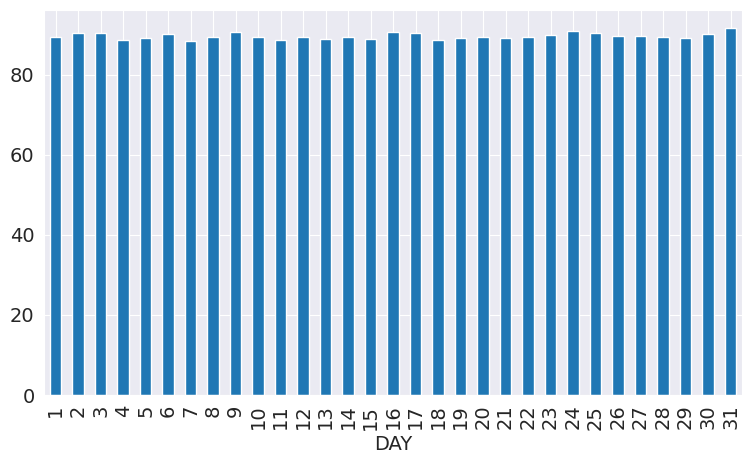

In [99]:
price_df.groupby(['DAY'])['CLOSE'].mean().plot.bar();

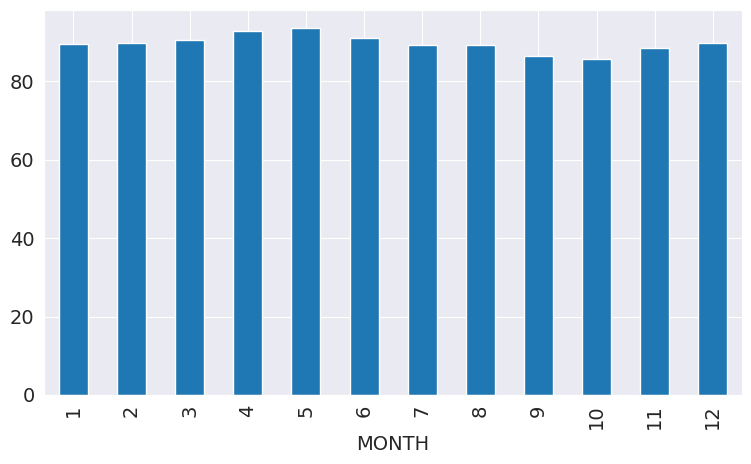

In [100]:
price_df.groupby(['MONTH'])['CLOSE'].mean().plot.bar();

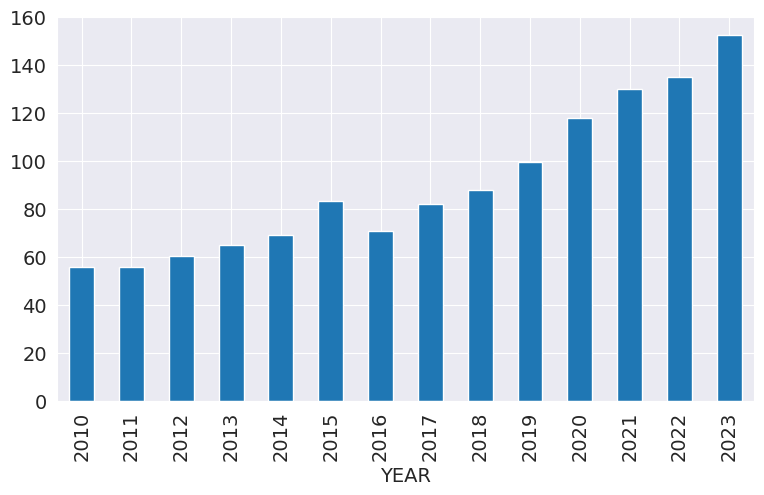

In [101]:
price_df.groupby(['YEAR'])['CLOSE'].mean().plot.bar();

## Correlation

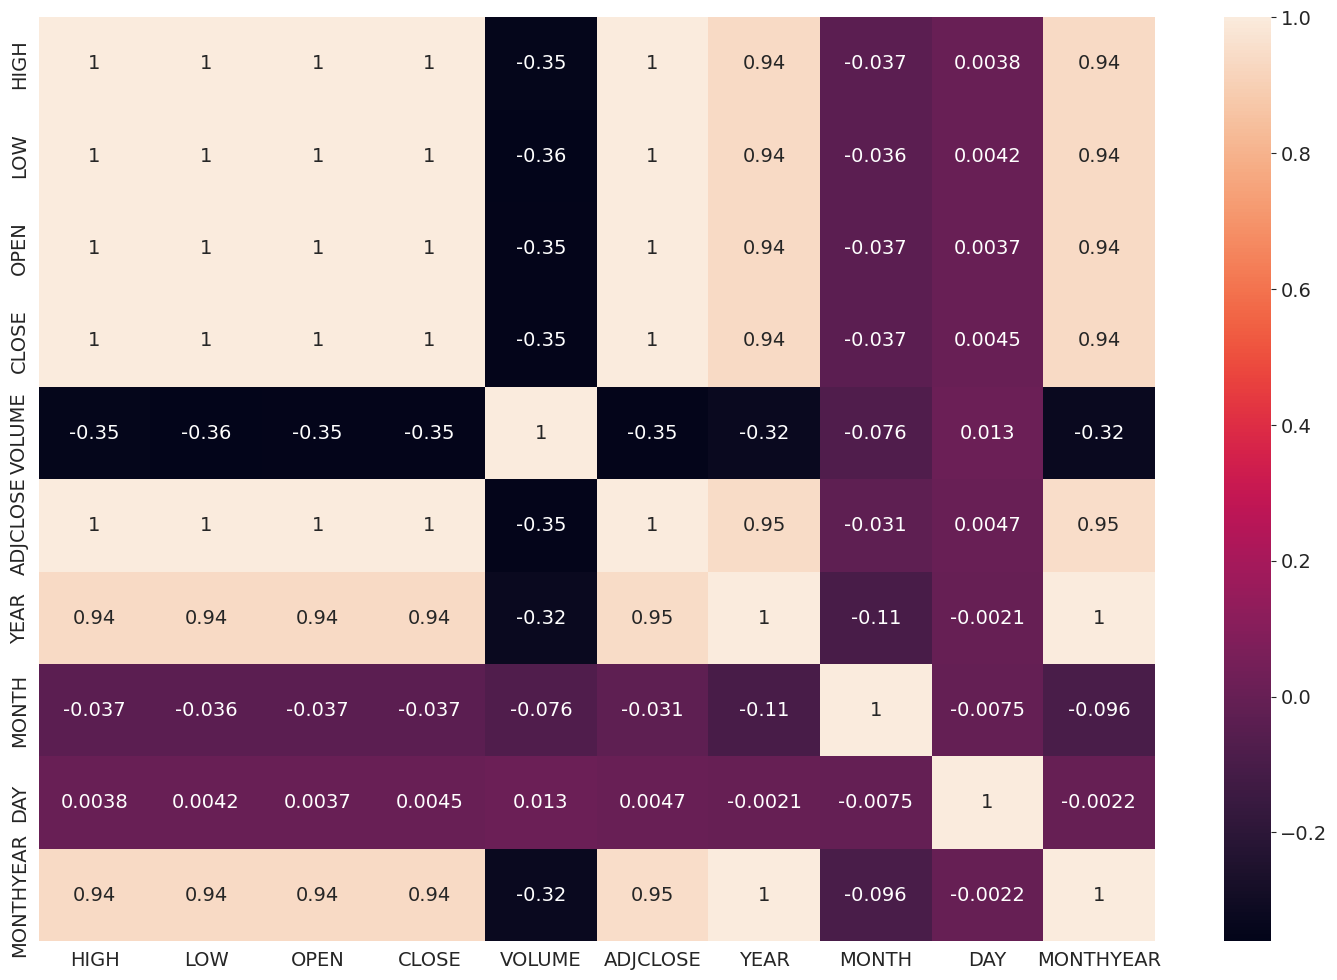

In [102]:
corr = price_df.corr()
plt.figure(figsize=(18,12))
sns.heatmap(corr,annot=True);

Day, month and year are correlated with closing price. We will only use date and closing price.

## Machine Learning Model Development

In [103]:
data = price_df[["CLOSE"]]
data.reset_index(inplace=True)
data.head()

index      CLOSE
0      0  52.223660
1      1  52.603794
2      2  53.152885
3      3  53.762310
4      4  54.064007

In [104]:
X = np.array(data[['index']])
y = np.array(data['CLOSE'])

In [105]:
train_len = int(len(X)* 0.8)
X_train, X_test = X[:train_len], X[train_len:]
y_train, y_test = y[:train_len], y[train_len:]

## Linear Regression

In [106]:
linear_model = LinearRegression()
linear_model.fit(X_train,y_train)

LinearRegression()

In [107]:
y_pred = linear_model.predict(X_test)

In [108]:
def plot_prediction(actual, prediction, title, y_label='Closing Price', x_label='Trading Days'):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    # Plot actual and predicted close values

    plt.plot(actual, '#00FF00', label='Actual Price')
    plt.plot(prediction, '#0000FF', label='Predicted Price')

    # Set title
    ax.set_title(title)
    ax.legend(loc='upper left')

    plt.show()  

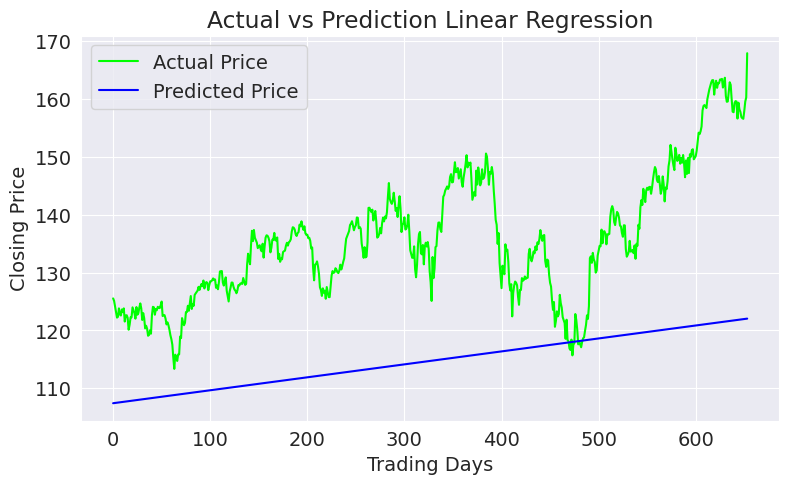

In [109]:
plot_prediction(y_test,y_pred,'Actual vs Prediction Linear Regression')

In [110]:
def evaluate_model(y_true, y_pred):
    print(f"Root Mean squared error: {mean_squared_error(y_true , y_pred,  squared=False)}")
    print(f"Mean absolute error: {mean_absolute_error(y_true , y_pred)}")
    print(f"Mean absolute percentage error: {mean_absolute_percentage_error(y_true , y_pred)}")    

In [111]:
evaluate_model(y_test,y_pred)

Root Mean squared error: 22.776739697253152
Mean absolute error: 20.98341373205184
Mean absolute percentage error: 0.15076134619741488


## ARIMA

In [112]:
parima_model = ARIMA(order=(1,1,1))
parima_model.fit(y_train)

ARIMA(order=(1, 1, 1))

In [113]:
y_parima_pred = parima_model.predict(len(y_test))

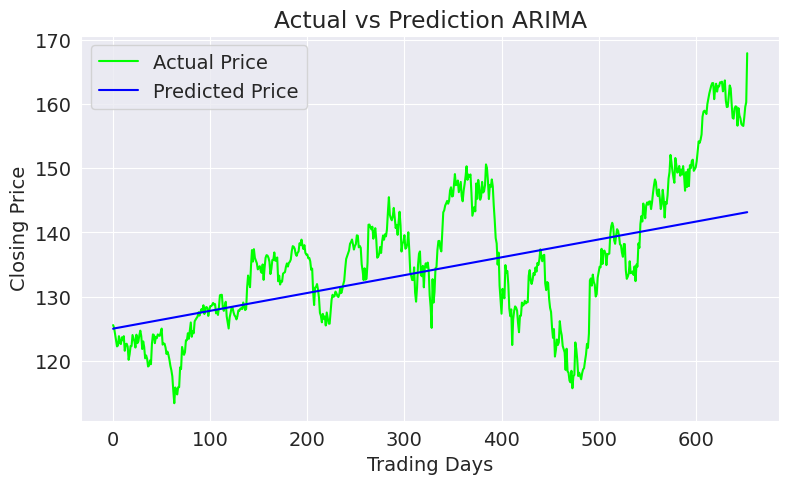

In [114]:
plot_prediction(y_test, y_parima_pred,'Actual vs Prediction ARIMA')

In [115]:
evaluate_model(y_test, y_parima_pred)

Root Mean squared error: 8.765559206374393
Mean absolute error: 6.820294056175283
Mean absolute percentage error: 0.04950917731869543


## Prophet

In [117]:
data = price_df[["DATE","CLOSE"]] 
data.columns = ("ds","y") #renaming the columns of the dataset
data.head(5)

ds          y
0 2010-09-07  52.223660
1 2010-09-08  52.603794
2 2010-09-09  53.152885
3 2010-09-10  53.762310
4 2010-09-13  54.064007

In [118]:
train_len = int(data.shape[0] * 0.8)
train_data, test_data = data[:train_len], data[train_len:]

In [119]:
prophet_model = Prophet() 
prophet_model.fit(train_data)

16:01:59 - cmdstanpy - INFO - Chain [1] start processing
16:02:00 - cmdstanpy - INFO - Chain [1] done processing


In [120]:
future = test_data[['ds']]
prophed_pred_df = prophet_model.predict(future)
prophed_pred_df.tail()

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
649 2023-06-09  172.447658  135.045504  210.482850   134.145019   209.560882   
650 2023-06-12  172.600681  134.361182  211.541326   134.212942   209.832790   
651 2023-06-14  172.702696  135.083285  211.271609   134.189296   210.028893   
652 2023-06-15  172.753704  134.547097  211.967016   134.119839   210.132608   
653 2023-06-16  172.804711  134.531084  210.363992   134.098140   210.236323   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
649        0.697546              0.697546              0.697546  0.842152   
650        0.686664              0.686664              0.686664  0.722248   
651        0.808790              0.808790              0.808790  0.792169   
652        0.818769              0.818769              0.818769  0.782432   
653        0.894219              0.894219              0.894219  0.842152   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
649      0.842152      0.842152 -0.144605     -0.144605     -0.144605   
650      0.722248      0.722248 -0.035584     -0.035584     -0.035584   
651      0.792169      0.792169  0.016621      0.016621      0.016621   
652      0.782432      0.782432  0.036337      0.036337      0.036337   
653      0.842152      0.842152  0.052067      0.052067      0.052067   

     multiplicative_terms  multiplicative_terms_lower  \
649                   0.0                         0.0   
650                   0.0                         0.0   
651                   0.0                         0.0   
652                   0.0                         0.0   
653                   0.0                         0.0   

     multiplicative_terms_upper        yhat  
649                         0.0  173.145205  
650                         0.0  173.287345  
651                         0.0  173.511486  
652                         0.0  173.572473  
653                         0.0  173.698930

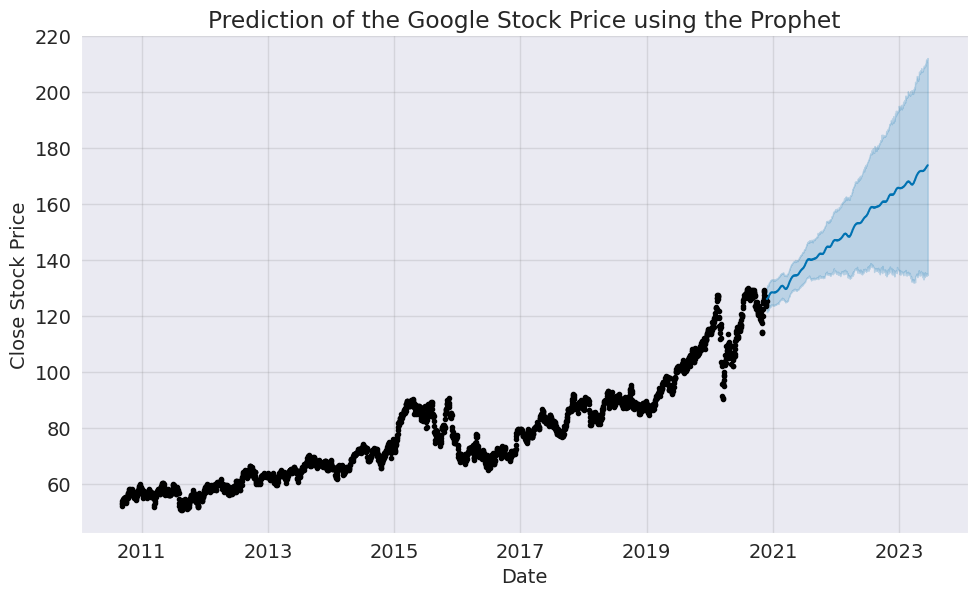

In [124]:
prophet_model.plot(prophed_pred_df)

plt.title("Prediction of the Google Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show(fig)

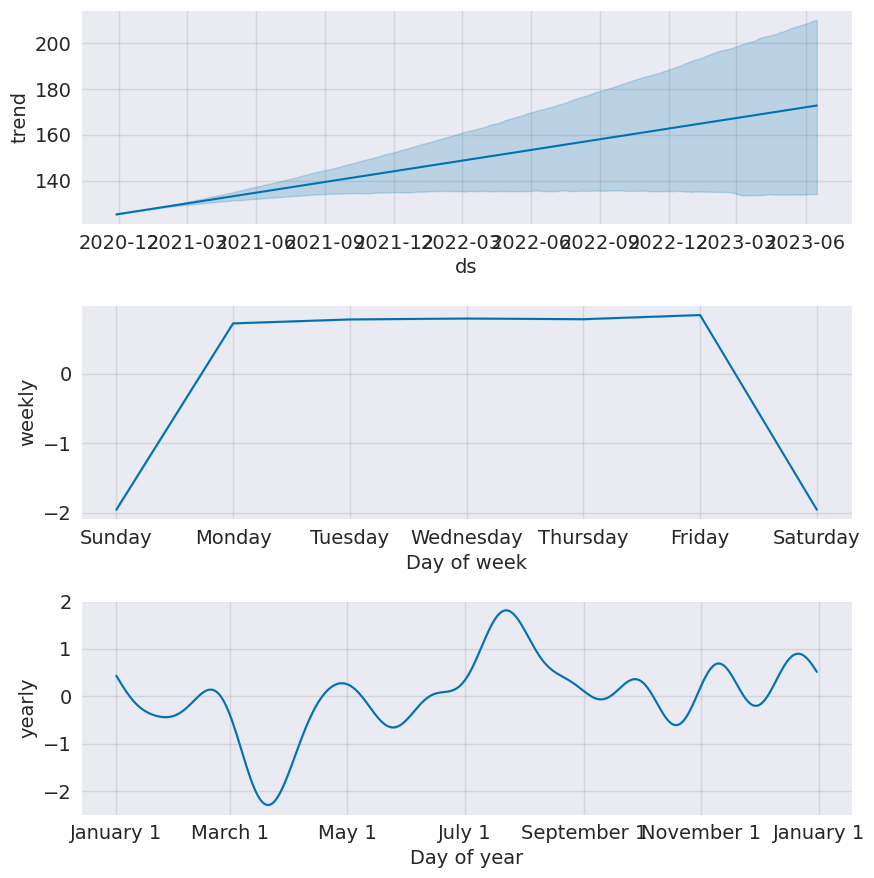

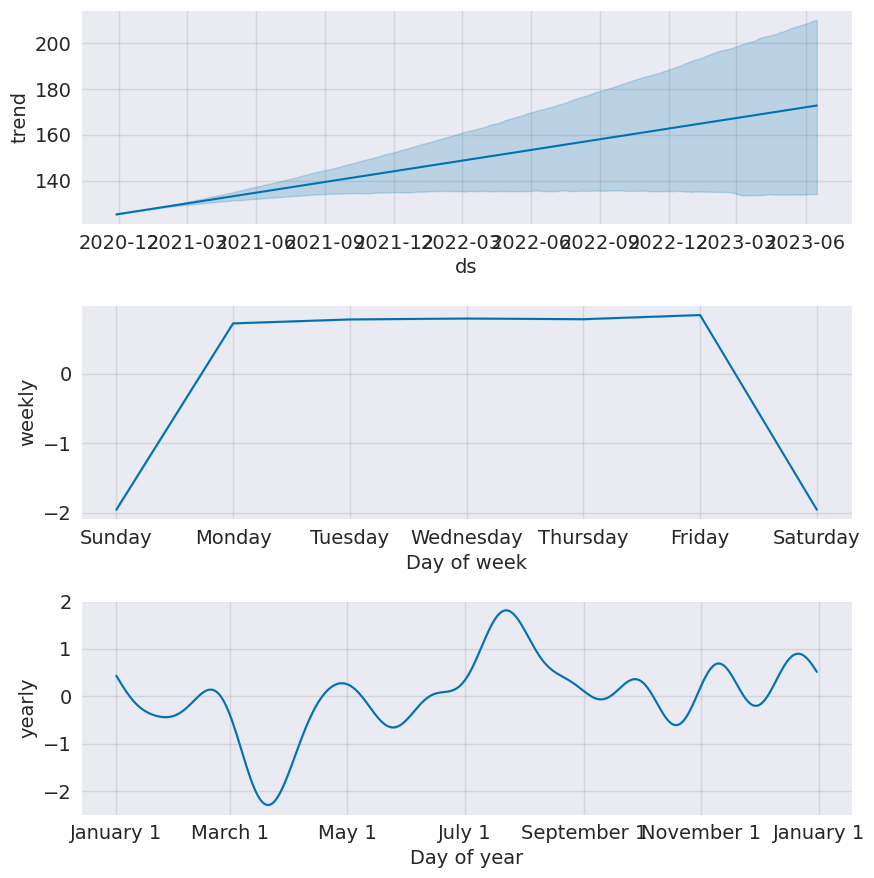

In [123]:
prophet_model.plot_components(prophed_pred_df)

In [125]:
evaluate_model(test_data[['y']], prophed_pred_df[['yhat']])

Root Mean squared error: 17.55308111705838
Mean absolute error: 14.049358139533954
Mean absolute percentage error: 0.10559921805779346


## Hyperparameter tuning of Prophet 

In [126]:
# Initiate the model
baseline_model = Prophet()
# Fit the model on the training dataset
baseline_model.fit(data)
# Cross validation
baseline_model_cv = cross_validation(model=baseline_model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")

16:19:05 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
16:19:06 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] done processing
16:19:06 - cmdstanpy - INFO - Chain [1] don

16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1

16:19:42 - cmdstanpy - INFO - Chain [1] done processing
16:19:42 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing


In [127]:
baseline_model_p = performance_metrics(baseline_model_cv, rolling_window=1)
baseline_model_p

horizon        mse      rmse       mae      mape     mdape    smape  \
0 30 days  55.623632  7.458125  5.227627  0.058979  0.044237  0.05777   

   coverage  
0  0.377292

In [128]:
print("Baseline Prophet model MAPE :",baseline_model_p['mape'].values[0])

Baseline Prophet model MAPE : 0.05897946534937487


In [129]:
print("Default value of changepoint_range :",prophet_model.changepoint_range)

Default value of changepoint_range : 0.8


In [130]:
# Initiate the model
manual_model = Prophet(changepoint_range=0.99)
# Fit the model on the training dataset
manual_model.fit(data)
# Cross validation
manual_model_cv = cross_validation(manual_model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
# Model performance metrics
manual_model_p = performance_metrics(manual_model_cv, rolling_window=1)

16:21:10 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
16:21:11 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1] done processing
16:21:11 - cmdstanpy - INFO - Chain [1] don

16:21:15 - cmdstanpy - INFO - Chain [1] start processing
16:21:15 - cmdstanpy - INFO - Chain [1] done processing
16:21:15 - cmdstanpy - INFO - Chain [1] done processing
16:21:15 - cmdstanpy - INFO - Chain [1] start processing
16:21:15 - cmdstanpy - INFO - Chain [1] done processing
16:21:15 - cmdstanpy - INFO - Chain [1] start processing
16:21:15 - cmdstanpy - INFO - Chain [1] done processing
16:21:15 - cmdstanpy - INFO - Chain [1] start processing
16:21:15 - cmdstanpy - INFO - Chain [1] start processing
16:21:15 - cmdstanpy - INFO - Chain [1] start processing
16:21:15 - cmdstanpy - INFO - Chain [1] start processing
16:21:15 - cmdstanpy - INFO - Chain [1] done processing
16:21:16 - cmdstanpy - INFO - Chain [1] start processing
16:21:16 - cmdstanpy - INFO - Chain [1] done processing
16:21:16 - cmdstanpy - INFO - Chain [1] start processing
16:21:16 - cmdstanpy - INFO - Chain [1] done processing
16:21:16 - cmdstanpy - INFO - Chain [1] start processing
16:21:16 - cmdstanpy - INFO - Chain [1

16:21:42 - cmdstanpy - INFO - Chain [1] done processing
16:21:43 - cmdstanpy - INFO - Chain [1] done processing
16:21:43 - cmdstanpy - INFO - Chain [1] done processing
16:21:43 - cmdstanpy - INFO - Chain [1] done processing
16:21:44 - cmdstanpy - INFO - Chain [1] done processing
16:21:44 - cmdstanpy - INFO - Chain [1] done processing
16:21:44 - cmdstanpy - INFO - Chain [1] done processing
16:21:44 - cmdstanpy - INFO - Chain [1] done processing
16:21:45 - cmdstanpy - INFO - Chain [1] done processing


In [131]:
print("Manual Prophet model MAPE :",manual_model_p['mape'].values[0])

Manual Prophet model MAPE : 0.051469398543172264


In [132]:
# Set up parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.99,0.8]
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# Create a list to store MAPE values for each combination
mapes = [] 
# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data)  
    # Cross-validation
    df_cv = cross_validation(m, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])
    
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

16:21:46 - cmdstanpy - INFO - Chain [1] start processing
16:21:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
16:21:46 - cmdstanpy - INFO - Chain [1] start processing
16:21:46 - cmdstanpy - INFO - Chain [1] start processing
16:21:46 - cmdstanpy - INFO - Chain [1] start processing
16:21:46 - cmdstanpy - INFO - Chain [1] start processing
16:21:46 - cmdstanpy - INFO - Chain [1] start processing
16:21:46 - cmdstanpy - INFO - Chain [1] start processing
16:21:46 - cmdstanpy - INFO - Chain [1] start processing
16:21:46 - cmdstanpy - INFO - Chain [1] start processing
16:21:46 - cmdstanpy - INFO - Chain [1] start processing
16:21:46 - cmdstanpy - INFO - Chain [1] start processing
16:21:46 - cmdstanpy - INFO - Chain [1] done processing
16:21:46 - cmdstanpy - INFO - Chain [1] start processing
16:21:46 - cmdstanpy - INFO - Chain [1] done processing
16:21:46 - cmdstanpy - INFO - Chain [1] done

16:21:48 - cmdstanpy - INFO - Chain [1] start processing
16:21:49 - cmdstanpy - INFO - Chain [1] start processing
16:21:49 - cmdstanpy - INFO - Chain [1] start processing
16:21:49 - cmdstanpy - INFO - Chain [1] done processing
16:21:49 - cmdstanpy - INFO - Chain [1] start processing
16:21:49 - cmdstanpy - INFO - Chain [1] done processing
16:21:49 - cmdstanpy - INFO - Chain [1] start processing
16:21:49 - cmdstanpy - INFO - Chain [1] done processing
16:21:49 - cmdstanpy - INFO - Chain [1] done processing
16:21:49 - cmdstanpy - INFO - Chain [1] done processing
16:21:49 - cmdstanpy - INFO - Chain [1] start processing
16:21:49 - cmdstanpy - INFO - Chain [1] done processing
16:21:49 - cmdstanpy - INFO - Chain [1] start processing
16:21:49 - cmdstanpy - INFO - Chain [1] done processing
16:21:49 - cmdstanpy - INFO - Chain [1] start processing
16:21:49 - cmdstanpy - INFO - Chain [1] done processing
16:21:49 - cmdstanpy - INFO - Chain [1] start processing
16:21:49 - cmdstanpy - INFO - Chain [1]

16:21:52 - cmdstanpy - INFO - Chain [1] start processing
16:21:52 - cmdstanpy - INFO - Chain [1] done processing
16:21:52 - cmdstanpy - INFO - Chain [1] done processing
16:21:52 - cmdstanpy - INFO - Chain [1] start processing
16:21:52 - cmdstanpy - INFO - Chain [1] done processing
16:21:52 - cmdstanpy - INFO - Chain [1] start processing
16:21:53 - cmdstanpy - INFO - Chain [1] start processing
16:21:53 - cmdstanpy - INFO - Chain [1] done processing
16:21:53 - cmdstanpy - INFO - Chain [1] start processing
16:21:53 - cmdstanpy - INFO - Chain [1] done processing
16:21:53 - cmdstanpy - INFO - Chain [1] done processing
16:21:53 - cmdstanpy - INFO - Chain [1] done processing
16:21:53 - cmdstanpy - INFO - Chain [1] done processing
16:21:53 - cmdstanpy - INFO - Chain [1] done processing
16:21:53 - cmdstanpy - INFO - Chain [1] start processing
16:21:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing ini

16:21:56 - cmdstanpy - INFO - Chain [1] done processing
16:21:56 - cmdstanpy - INFO - Chain [1] start processing
16:21:56 - cmdstanpy - INFO - Chain [1] done processing
16:21:56 - cmdstanpy - INFO - Chain [1] start processing
16:21:56 - cmdstanpy - INFO - Chain [1] done processing
16:21:56 - cmdstanpy - INFO - Chain [1] done processing
16:21:56 - cmdstanpy - INFO - Chain [1] start processing
16:21:56 - cmdstanpy - INFO - Chain [1] start processing
16:21:56 - cmdstanpy - INFO - Chain [1] done processing
16:21:56 - cmdstanpy - INFO - Chain [1] done processing
16:21:56 - cmdstanpy - INFO - Chain [1] done processing
16:21:56 - cmdstanpy - INFO - Chain [1] start processing
16:21:56 - cmdstanpy - INFO - Chain [1] done processing
16:21:56 - cmdstanpy - INFO - Chain [1] start processing
16:21:56 - cmdstanpy - INFO - Chain [1] done processing
16:21:56 - cmdstanpy - INFO - Chain [1] done processing
16:21:56 - cmdstanpy - INFO - Chain [1] start processing
16:21:56 - cmdstanpy - INFO - Chain [1] s

16:21:59 - cmdstanpy - INFO - Chain [1] done processing
16:21:59 - cmdstanpy - INFO - Chain [1] start processing
16:21:59 - cmdstanpy - INFO - Chain [1] start processing
16:21:59 - cmdstanpy - INFO - Chain [1] done processing
16:21:59 - cmdstanpy - INFO - Chain [1] start processing
16:22:00 - cmdstanpy - INFO - Chain [1] done processing
16:22:00 - cmdstanpy - INFO - Chain [1] start processing
16:22:00 - cmdstanpy - INFO - Chain [1] start processing
16:22:00 - cmdstanpy - INFO - Chain [1] start processing
16:22:00 - cmdstanpy - INFO - Chain [1] start processing
16:22:00 - cmdstanpy - INFO - Chain [1] done processing
16:22:00 - cmdstanpy - INFO - Chain [1] start processing
16:22:00 - cmdstanpy - INFO - Chain [1] start processing
16:22:00 - cmdstanpy - INFO - Chain [1] start processing
16:22:00 - cmdstanpy - INFO - Chain [1] done processing
16:22:00 - cmdstanpy - INFO - Chain [1] start processing
16:22:00 - cmdstanpy - INFO - Chain [1] done processing
16:22:00 - cmdstanpy - INFO - Chain [

16:22:03 - cmdstanpy - INFO - Chain [1] done processing
16:22:03 - cmdstanpy - INFO - Chain [1] start processing
16:22:03 - cmdstanpy - INFO - Chain [1] start processing
16:22:03 - cmdstanpy - INFO - Chain [1] start processing
16:22:03 - cmdstanpy - INFO - Chain [1] done processing
16:22:03 - cmdstanpy - INFO - Chain [1] done processing
16:22:03 - cmdstanpy - INFO - Chain [1] start processing
16:22:03 - cmdstanpy - INFO - Chain [1] start processing
16:22:03 - cmdstanpy - INFO - Chain [1] done processing
16:22:03 - cmdstanpy - INFO - Chain [1] start processing
16:22:03 - cmdstanpy - INFO - Chain [1] done processing
16:22:03 - cmdstanpy - INFO - Chain [1] done processing
16:22:03 - cmdstanpy - INFO - Chain [1] start processing
16:22:03 - cmdstanpy - INFO - Chain [1] done processing
16:22:03 - cmdstanpy - INFO - Chain [1] start processing
16:22:03 - cmdstanpy - INFO - Chain [1] start processing
16:22:03 - cmdstanpy - INFO - Chain [1] done processing
16:22:03 - cmdstanpy - INFO - Chain [1]

16:22:06 - cmdstanpy - INFO - Chain [1] start processing
16:22:06 - cmdstanpy - INFO - Chain [1] start processing
16:22:06 - cmdstanpy - INFO - Chain [1] done processing
16:22:06 - cmdstanpy - INFO - Chain [1] done processing
16:22:06 - cmdstanpy - INFO - Chain [1] start processing
16:22:06 - cmdstanpy - INFO - Chain [1] done processing
16:22:06 - cmdstanpy - INFO - Chain [1] done processing
16:22:06 - cmdstanpy - INFO - Chain [1] done processing
16:22:06 - cmdstanpy - INFO - Chain [1] done processing
16:22:06 - cmdstanpy - INFO - Chain [1] done processing
16:22:07 - cmdstanpy - INFO - Chain [1] done processing
16:22:07 - cmdstanpy - INFO - Chain [1] done processing
16:22:07 - cmdstanpy - INFO - Chain [1] done processing
16:22:07 - cmdstanpy - INFO - Chain [1] done processing
16:22:07 - cmdstanpy - INFO - Chain [1] done processing
16:22:07 - cmdstanpy - INFO - Chain [1] start processing
16:22:07 - cmdstanpy - INFO - Chain [1] start processing
16:22:07 - cmdstanpy - INFO - Chain [1] sta

16:22:10 - cmdstanpy - INFO - Chain [1] start processing
16:22:10 - cmdstanpy - INFO - Chain [1] done processing
16:22:10 - cmdstanpy - INFO - Chain [1] start processing
16:22:10 - cmdstanpy - INFO - Chain [1] start processing
16:22:10 - cmdstanpy - INFO - Chain [1] done processing
16:22:10 - cmdstanpy - INFO - Chain [1] start processing
16:22:10 - cmdstanpy - INFO - Chain [1] start processing
16:22:10 - cmdstanpy - INFO - Chain [1] start processing
16:22:10 - cmdstanpy - INFO - Chain [1] done processing
16:22:10 - cmdstanpy - INFO - Chain [1] done processing
16:22:10 - cmdstanpy - INFO - Chain [1] done processing
16:22:10 - cmdstanpy - INFO - Chain [1] start processing
16:22:10 - cmdstanpy - INFO - Chain [1] done processing
16:22:10 - cmdstanpy - INFO - Chain [1] start processing
16:22:10 - cmdstanpy - INFO - Chain [1] done processing
16:22:10 - cmdstanpy - INFO - Chain [1] done processing
16:22:10 - cmdstanpy - INFO - Chain [1] done processing
16:22:10 - cmdstanpy - INFO - Chain [1] 

16:22:13 - cmdstanpy - INFO - Chain [1] start processing
16:22:13 - cmdstanpy - INFO - Chain [1] done processing
16:22:13 - cmdstanpy - INFO - Chain [1] start processing
16:22:13 - cmdstanpy - INFO - Chain [1] start processing
16:22:13 - cmdstanpy - INFO - Chain [1] done processing
16:22:13 - cmdstanpy - INFO - Chain [1] start processing
16:22:13 - cmdstanpy - INFO - Chain [1] done processing
16:22:13 - cmdstanpy - INFO - Chain [1] start processing
16:22:13 - cmdstanpy - INFO - Chain [1] done processing
16:22:13 - cmdstanpy - INFO - Chain [1] done processing
16:22:13 - cmdstanpy - INFO - Chain [1] done processing
16:22:13 - cmdstanpy - INFO - Chain [1] done processing
16:22:13 - cmdstanpy - INFO - Chain [1] done processing
16:22:13 - cmdstanpy - INFO - Chain [1] start processing
16:22:13 - cmdstanpy - INFO - Chain [1] done processing
16:22:13 - cmdstanpy - INFO - Chain [1] start processing
16:22:13 - cmdstanpy - INFO - Chain [1] start processing
16:22:13 - cmdstanpy - INFO - Chain [1] 

16:22:17 - cmdstanpy - INFO - Chain [1] done processing
16:22:17 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [1] done processing
16:22:17 - cmdstanpy - INFO - Chain [1] done processing
16:22:17 - cmdstanpy - INFO - Chain [1] done processing
16:22:17 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [1] done processing
16:22:17 - cmdstanpy - INFO - Chain [1] done processing
16:22:17 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [1] done processing
16:22:17 - cmdstanpy - INFO - Chain [1] done processing
16:22:17 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [1]

16:22:20 - cmdstanpy - INFO - Chain [1] start processing
16:22:20 - cmdstanpy - INFO - Chain [1] start processing
16:22:20 - cmdstanpy - INFO - Chain [1] done processing
16:22:20 - cmdstanpy - INFO - Chain [1] done processing
16:22:20 - cmdstanpy - INFO - Chain [1] start processing
16:22:20 - cmdstanpy - INFO - Chain [1] start processing
16:22:20 - cmdstanpy - INFO - Chain [1] done processing
16:22:20 - cmdstanpy - INFO - Chain [1] start processing
16:22:20 - cmdstanpy - INFO - Chain [1] done processing
16:22:20 - cmdstanpy - INFO - Chain [1] start processing
16:22:20 - cmdstanpy - INFO - Chain [1] start processing
16:22:20 - cmdstanpy - INFO - Chain [1] done processing
16:22:20 - cmdstanpy - INFO - Chain [1] done processing
16:22:20 - cmdstanpy - INFO - Chain [1] done processing
16:22:20 - cmdstanpy - INFO - Chain [1] done processing
16:22:20 - cmdstanpy - INFO - Chain [1] start processing
16:22:20 - cmdstanpy - INFO - Chain [1] done processing
16:22:20 - cmdstanpy - INFO - Chain [1] 

16:22:24 - cmdstanpy - INFO - Chain [1] done processing
16:22:24 - cmdstanpy - INFO - Chain [1] done processing
16:22:24 - cmdstanpy - INFO - Chain [1] start processing
16:22:24 - cmdstanpy - INFO - Chain [1] done processing
16:22:24 - cmdstanpy - INFO - Chain [1] start processing
16:22:24 - cmdstanpy - INFO - Chain [1] done processing
16:22:24 - cmdstanpy - INFO - Chain [1] done processing
16:22:24 - cmdstanpy - INFO - Chain [1] start processing
16:22:24 - cmdstanpy - INFO - Chain [1] start processing
16:22:24 - cmdstanpy - INFO - Chain [1] start processing
16:22:24 - cmdstanpy - INFO - Chain [1] start processing
16:22:24 - cmdstanpy - INFO - Chain [1] start processing
16:22:24 - cmdstanpy - INFO - Chain [1] done processing
16:22:24 - cmdstanpy - INFO - Chain [1] start processing
16:22:24 - cmdstanpy - INFO - Chain [1] done processing
16:22:24 - cmdstanpy - INFO - Chain [1] start processing
16:22:24 - cmdstanpy - INFO - Chain [1] start processing
16:22:24 - cmdstanpy - INFO - Chain [1

16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:22:27 - cmdstanpy - INFO - Chain [1] done processing
16:22:27 - cmdstanpy - INFO - Chain [1] done processing
16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:22:27 - cmdstanpy - INFO - Chain [1] done processing
16:22:27 - cmdstanpy - INFO - Chain [1] done processing
16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:22:27 - cmdstanpy - INFO - Chain [1] done processing
16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:22:27 - cmdstanpy - INFO - Chain [1] done processing
16:22:27 - cmdstanpy - INFO - Chain [1] done processing
16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:22:27 - cmdstanpy - INFO - Chain [1] done processing
16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:22:28 - cmdstanpy - INFO - Chain [1]

16:22:31 - cmdstanpy - INFO - Chain [1] done processing
16:22:31 - cmdstanpy - INFO - Chain [1] start processing
16:22:31 - cmdstanpy - INFO - Chain [1] done processing
16:22:31 - cmdstanpy - INFO - Chain [1] start processing
16:22:31 - cmdstanpy - INFO - Chain [1] done processing
16:22:31 - cmdstanpy - INFO - Chain [1] done processing
16:22:31 - cmdstanpy - INFO - Chain [1] done processing
16:22:31 - cmdstanpy - INFO - Chain [1] done processing
16:22:31 - cmdstanpy - INFO - Chain [1] done processing
16:22:31 - cmdstanpy - INFO - Chain [1] done processing
16:22:31 - cmdstanpy - INFO - Chain [1] done processing
16:22:31 - cmdstanpy - INFO - Chain [1] start processing
16:22:31 - cmdstanpy - INFO - Chain [1] start processing
16:22:32 - cmdstanpy - INFO - Chain [1] start processing
16:22:32 - cmdstanpy - INFO - Chain [1] start processing
16:22:32 - cmdstanpy - INFO - Chain [1] start processing
16:22:32 - cmdstanpy - INFO - Chain [1] start processing
16:22:32 - cmdstanpy - INFO - Chain [1] 

16:22:34 - cmdstanpy - INFO - Chain [1] start processing
16:22:34 - cmdstanpy - INFO - Chain [1] done processing
16:22:34 - cmdstanpy - INFO - Chain [1] done processing
16:22:34 - cmdstanpy - INFO - Chain [1] start processing
16:22:34 - cmdstanpy - INFO - Chain [1] done processing
16:22:34 - cmdstanpy - INFO - Chain [1] done processing
16:22:34 - cmdstanpy - INFO - Chain [1] start processing
16:22:34 - cmdstanpy - INFO - Chain [1] start processing
16:22:34 - cmdstanpy - INFO - Chain [1] start processing
16:22:34 - cmdstanpy - INFO - Chain [1] start processing
16:22:34 - cmdstanpy - INFO - Chain [1] start processing
16:22:34 - cmdstanpy - INFO - Chain [1] done processing
16:22:34 - cmdstanpy - INFO - Chain [1] start processing
16:22:34 - cmdstanpy - INFO - Chain [1] start processing
16:22:34 - cmdstanpy - INFO - Chain [1] done processing
16:22:34 - cmdstanpy - INFO - Chain [1] start processing
16:22:34 - cmdstanpy - INFO - Chain [1] done processing
16:22:34 - cmdstanpy - INFO - Chain [1

16:22:39 - cmdstanpy - INFO - Chain [1] start processing
16:22:39 - cmdstanpy - INFO - Chain [1] start processing
16:22:39 - cmdstanpy - INFO - Chain [1] start processing
16:22:39 - cmdstanpy - INFO - Chain [1] done processing
16:22:39 - cmdstanpy - INFO - Chain [1] done processing
16:22:39 - cmdstanpy - INFO - Chain [1] done processing
16:22:39 - cmdstanpy - INFO - Chain [1] start processing
16:22:39 - cmdstanpy - INFO - Chain [1] done processing
16:22:39 - cmdstanpy - INFO - Chain [1] start processing
16:22:39 - cmdstanpy - INFO - Chain [1] done processing
16:22:39 - cmdstanpy - INFO - Chain [1] start processing
16:22:39 - cmdstanpy - INFO - Chain [1] start processing
16:22:39 - cmdstanpy - INFO - Chain [1] start processing
16:22:39 - cmdstanpy - INFO - Chain [1] start processing
16:22:39 - cmdstanpy - INFO - Chain [1] done processing
16:22:39 - cmdstanpy - INFO - Chain [1] start processing
16:22:39 - cmdstanpy - INFO - Chain [1] done processing
16:22:39 - cmdstanpy - INFO - Chain [1

16:22:42 - cmdstanpy - INFO - Chain [1] done processing
16:22:42 - cmdstanpy - INFO - Chain [1] done processing
16:22:42 - cmdstanpy - INFO - Chain [1] start processing
16:22:42 - cmdstanpy - INFO - Chain [1] start processing
16:22:42 - cmdstanpy - INFO - Chain [1] start processing
16:22:42 - cmdstanpy - INFO - Chain [1] start processing
16:22:42 - cmdstanpy - INFO - Chain [1] start processing
16:22:42 - cmdstanpy - INFO - Chain [1] done processing
16:22:42 - cmdstanpy - INFO - Chain [1] done processing
16:22:42 - cmdstanpy - INFO - Chain [1] start processing
16:22:42 - cmdstanpy - INFO - Chain [1] start processing
16:22:42 - cmdstanpy - INFO - Chain [1] done processing
16:22:42 - cmdstanpy - INFO - Chain [1] done processing
16:22:42 - cmdstanpy - INFO - Chain [1] start processing
16:22:42 - cmdstanpy - INFO - Chain [1] done processing
16:22:42 - cmdstanpy - INFO - Chain [1] done processing
16:22:42 - cmdstanpy - INFO - Chain [1] start processing
16:22:42 - cmdstanpy - INFO - Chain [1]

16:22:47 - cmdstanpy - INFO - Chain [1] done processing
16:22:47 - cmdstanpy - INFO - Chain [1] start processing
16:22:47 - cmdstanpy - INFO - Chain [1] done processing
16:22:47 - cmdstanpy - INFO - Chain [1] start processing
16:22:47 - cmdstanpy - INFO - Chain [1] start processing
16:22:47 - cmdstanpy - INFO - Chain [1] start processing
16:22:47 - cmdstanpy - INFO - Chain [1] start processing
16:22:47 - cmdstanpy - INFO - Chain [1] start processing
16:22:47 - cmdstanpy - INFO - Chain [1] done processing
16:22:47 - cmdstanpy - INFO - Chain [1] done processing
16:22:47 - cmdstanpy - INFO - Chain [1] done processing
16:22:47 - cmdstanpy - INFO - Chain [1] done processing
16:22:47 - cmdstanpy - INFO - Chain [1] done processing
16:22:47 - cmdstanpy - INFO - Chain [1] start processing
16:22:47 - cmdstanpy - INFO - Chain [1] done processing
16:22:47 - cmdstanpy - INFO - Chain [1] done processing
16:22:47 - cmdstanpy - INFO - Chain [1] done processing
16:22:47 - cmdstanpy - INFO - Chain [1] s

16:22:49 - cmdstanpy - INFO - Chain [1] start processing
16:22:49 - cmdstanpy - INFO - Chain [1] start processing
16:22:49 - cmdstanpy - INFO - Chain [1] start processing
16:22:49 - cmdstanpy - INFO - Chain [1] start processing
16:22:49 - cmdstanpy - INFO - Chain [1] done processing
16:22:49 - cmdstanpy - INFO - Chain [1] start processing
16:22:49 - cmdstanpy - INFO - Chain [1] done processing
16:22:49 - cmdstanpy - INFO - Chain [1] done processing
16:22:49 - cmdstanpy - INFO - Chain [1] start processing
16:22:49 - cmdstanpy - INFO - Chain [1] start processing
16:22:49 - cmdstanpy - INFO - Chain [1] start processing
16:22:49 - cmdstanpy - INFO - Chain [1] done processing
16:22:49 - cmdstanpy - INFO - Chain [1] done processing
16:22:49 - cmdstanpy - INFO - Chain [1] done processing
16:22:49 - cmdstanpy - INFO - Chain [1] done processing
16:22:49 - cmdstanpy - INFO - Chain [1] done processing
16:22:50 - cmdstanpy - INFO - Chain [1] done processing
16:22:50 - cmdstanpy - INFO - Chain [1] 

16:22:54 - cmdstanpy - INFO - Chain [1] done processing
16:22:54 - cmdstanpy - INFO - Chain [1] done processing
16:22:54 - cmdstanpy - INFO - Chain [1] done processing
Optimization terminated abnormally. Falling back to Newton.
16:22:54 - cmdstanpy - INFO - Chain [1] start processing
16:22:54 - cmdstanpy - INFO - Chain [1] done processing
16:22:54 - cmdstanpy - INFO - Chain [1] done processing
16:22:54 - cmdstanpy - INFO - Chain [1] start processing
16:22:54 - cmdstanpy - INFO - Chain [1] start processing
16:22:54 - cmdstanpy - INFO - Chain [1] start processing
16:22:54 - cmdstanpy - INFO - Chain [1] start processing
16:22:54 - cmdstanpy - INFO - Chain [1] start processing
16:22:54 - cmdstanpy - INFO - Chain [1] start processing
16:22:54 - cmdstanpy - INFO - Chain [1] start processing
16:22:54 - cmdstanpy - INFO - Chain [1] start processing
16:22:54 - cmdstanpy - INFO - Chain [1] done processing
16:22:54 - cmdstanpy - INFO - Chain [1] done processing
16:22:54 - cmdstanpy - INFO - Chain

16:22:56 - cmdstanpy - INFO - Chain [1] done processing
16:22:56 - cmdstanpy - INFO - Chain [1] start processing
16:22:56 - cmdstanpy - INFO - Chain [1] done processing
16:22:56 - cmdstanpy - INFO - Chain [1] start processing
16:22:56 - cmdstanpy - INFO - Chain [1] done processing
16:22:56 - cmdstanpy - INFO - Chain [1] done processing
16:22:56 - cmdstanpy - INFO - Chain [1] start processing
16:22:56 - cmdstanpy - INFO - Chain [1] done processing
16:22:56 - cmdstanpy - INFO - Chain [1] start processing
16:22:56 - cmdstanpy - INFO - Chain [1] done processing
16:22:56 - cmdstanpy - INFO - Chain [1] start processing
16:22:56 - cmdstanpy - INFO - Chain [1] start processing
16:22:56 - cmdstanpy - INFO - Chain [1] done processing
16:22:56 - cmdstanpy - INFO - Chain [1] done processing
16:22:56 - cmdstanpy - INFO - Chain [1] done processing
16:22:56 - cmdstanpy - INFO - Chain [1] start processing
16:22:56 - cmdstanpy - INFO - Chain [1] start processing
16:22:56 - cmdstanpy - INFO - Chain [1] 

16:23:01 - cmdstanpy - INFO - Chain [1] start processing
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
16:23:01 - cmdstanpy - INFO - Chain [1] start processing
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
16:23:01 - cmdstanpy - INFO - Chain [1] start processing
16:23:01 - cmdstanpy - INFO - Chain [1] start processing
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
16:23:01 - cmdstanpy - INFO - Chain [1] start processing
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
16:23:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
Optimization terminated abnormally. Falling back to Newton.

16:23:03 - cmdstanpy - INFO - Chain [1] done processing
16:23:03 - cmdstanpy - INFO - Chain [1] start processing
16:23:03 - cmdstanpy - INFO - Chain [1] start processing
16:23:04 - cmdstanpy - INFO - Chain [1] done processing
16:23:04 - cmdstanpy - INFO - Chain [1] start processing
16:23:04 - cmdstanpy - INFO - Chain [1] start processing
16:23:04 - cmdstanpy - INFO - Chain [1] done processing
16:23:04 - cmdstanpy - INFO - Chain [1] done processing
16:23:04 - cmdstanpy - INFO - Chain [1] done processing
16:23:04 - cmdstanpy - INFO - Chain [1] start processing
16:23:04 - cmdstanpy - INFO - Chain [1] start processing
16:23:04 - cmdstanpy - INFO - Chain [1] done processing
16:23:04 - cmdstanpy - INFO - Chain [1] done processing
16:23:04 - cmdstanpy - INFO - Chain [1] done processing
16:23:04 - cmdstanpy - INFO - Chain [1] done processing
16:23:04 - cmdstanpy - INFO - Chain [1] done processing
16:23:04 - cmdstanpy - INFO - Chain [1] done processing
16:23:04 - cmdstanpy - INFO - Chain [1] st

16:23:07 - cmdstanpy - INFO - Chain [1] done processing
16:23:08 - cmdstanpy - INFO - Chain [1] done processing
16:23:08 - cmdstanpy - INFO - Chain [1] start processing
16:23:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
16:23:08 - cmdstanpy - INFO - Chain [1] start processing
16:23:08 - cmdstanpy - INFO - Chain [1] start processing
16:23:08 - cmdstanpy - INFO - Chain [1] start processing
16:23:08 - cmdstanpy - INFO - Chain [1] start processing
16:23:08 - cmdstanpy - INFO - Chain [1] start processing
16:23:08 - cmdstanpy - INFO - Chain [1] start processing
16:23:08 - cmdstanpy - INFO - Chain [1] start processing
16:23:08 - cmdstanpy - INFO - Chain [1] done processing
16:23:08 - cmdstanpy - INFO - Chain [1] start processing
16:23:08 - cmdstanpy - INFO - Chain [1] start processing
16:23:08 - cmdstanpy - INFO - Chain [1] start processing
16:23:08 - cmdstanpy - INFO - Chain [1] done 

16:23:10 - cmdstanpy - INFO - Chain [1] start processing
16:23:10 - cmdstanpy - INFO - Chain [1] start processing
16:23:10 - cmdstanpy - INFO - Chain [1] start processing
16:23:10 - cmdstanpy - INFO - Chain [1] done processing
16:23:10 - cmdstanpy - INFO - Chain [1] done processing
16:23:10 - cmdstanpy - INFO - Chain [1] start processing
16:23:10 - cmdstanpy - INFO - Chain [1] done processing
16:23:10 - cmdstanpy - INFO - Chain [1] start processing
16:23:10 - cmdstanpy - INFO - Chain [1] done processing
16:23:10 - cmdstanpy - INFO - Chain [1] start processing
16:23:10 - cmdstanpy - INFO - Chain [1] start processing
16:23:10 - cmdstanpy - INFO - Chain [1] done processing
16:23:10 - cmdstanpy - INFO - Chain [1] start processing
16:23:11 - cmdstanpy - INFO - Chain [1] start processing
16:23:11 - cmdstanpy - INFO - Chain [1] done processing
16:23:11 - cmdstanpy - INFO - Chain [1] done processing
16:23:11 - cmdstanpy - INFO - Chain [1] done processing
16:23:11 - cmdstanpy - INFO - Chain [1]

16:23:14 - cmdstanpy - INFO - Chain [1] start processing
16:23:14 - cmdstanpy - INFO - Chain [1] done processing
16:23:14 - cmdstanpy - INFO - Chain [1] start processing
16:23:14 - cmdstanpy - INFO - Chain [1] done processing
16:23:14 - cmdstanpy - INFO - Chain [1] start processing
16:23:14 - cmdstanpy - INFO - Chain [1] start processing
16:23:14 - cmdstanpy - INFO - Chain [1] done processing
16:23:14 - cmdstanpy - INFO - Chain [1] done processing
16:23:15 - cmdstanpy - INFO - Chain [1] done processing
16:23:15 - cmdstanpy - INFO - Chain [1] done processing
16:23:15 - cmdstanpy - INFO - Chain [1] done processing
16:23:15 - cmdstanpy - INFO - Chain [1] done processing
16:23:15 - cmdstanpy - INFO - Chain [1] done processing
16:23:15 - cmdstanpy - INFO - Chain [1] done processing
16:23:15 - cmdstanpy - INFO - Chain [1] done processing
16:23:15 - cmdstanpy - INFO - Chain [1] done processing
16:23:15 - cmdstanpy - INFO - Chain [1] start processing
16:23:15 - cmdstanpy - INFO - Chain [1] don

16:23:17 - cmdstanpy - INFO - Chain [1] start processing
16:23:18 - cmdstanpy - INFO - Chain [1] start processing
16:23:18 - cmdstanpy - INFO - Chain [1] start processing
16:23:18 - cmdstanpy - INFO - Chain [1] done processing
16:23:18 - cmdstanpy - INFO - Chain [1] start processing
16:23:18 - cmdstanpy - INFO - Chain [1] start processing
16:23:18 - cmdstanpy - INFO - Chain [1] done processing
16:23:18 - cmdstanpy - INFO - Chain [1] done processing
16:23:18 - cmdstanpy - INFO - Chain [1] start processing
16:23:18 - cmdstanpy - INFO - Chain [1] done processing
16:23:18 - cmdstanpy - INFO - Chain [1] start processing
16:23:18 - cmdstanpy - INFO - Chain [1] start processing
16:23:18 - cmdstanpy - INFO - Chain [1] done processing
16:23:18 - cmdstanpy - INFO - Chain [1] done processing
16:23:18 - cmdstanpy - INFO - Chain [1] done processing
16:23:18 - cmdstanpy - INFO - Chain [1] done processing
16:23:18 - cmdstanpy - INFO - Chain [1] done processing
16:23:18 - cmdstanpy - INFO - Chain [1] 

16:23:21 - cmdstanpy - INFO - Chain [1] done processing
16:23:21 - cmdstanpy - INFO - Chain [1] start processing
16:23:21 - cmdstanpy - INFO - Chain [1] done processing
16:23:21 - cmdstanpy - INFO - Chain [1] start processing
16:23:21 - cmdstanpy - INFO - Chain [1] start processing
16:23:21 - cmdstanpy - INFO - Chain [1] done processing
16:23:22 - cmdstanpy - INFO - Chain [1] done processing
16:23:22 - cmdstanpy - INFO - Chain [1] start processing
16:23:22 - cmdstanpy - INFO - Chain [1] done processing
16:23:22 - cmdstanpy - INFO - Chain [1] start processing
16:23:22 - cmdstanpy - INFO - Chain [1] done processing
16:23:22 - cmdstanpy - INFO - Chain [1] start processing
16:23:22 - cmdstanpy - INFO - Chain [1] done processing
16:23:22 - cmdstanpy - INFO - Chain [1] start processing
16:23:22 - cmdstanpy - INFO - Chain [1] done processing
16:23:22 - cmdstanpy - INFO - Chain [1] done processing
16:23:22 - cmdstanpy - INFO - Chain [1] start processing
16:23:22 - cmdstanpy - INFO - Chain [1] 

16:23:25 - cmdstanpy - INFO - Chain [1] done processing
16:23:25 - cmdstanpy - INFO - Chain [1] start processing
16:23:25 - cmdstanpy - INFO - Chain [1] done processing
16:23:25 - cmdstanpy - INFO - Chain [1] done processing
16:23:25 - cmdstanpy - INFO - Chain [1] done processing
16:23:25 - cmdstanpy - INFO - Chain [1] done processing
16:23:25 - cmdstanpy - INFO - Chain [1] start processing
16:23:25 - cmdstanpy - INFO - Chain [1] done processing
16:23:25 - cmdstanpy - INFO - Chain [1] start processing
16:23:25 - cmdstanpy - INFO - Chain [1] done processing
16:23:25 - cmdstanpy - INFO - Chain [1] done processing
16:23:25 - cmdstanpy - INFO - Chain [1] start processing
16:23:25 - cmdstanpy - INFO - Chain [1] start processing
16:23:25 - cmdstanpy - INFO - Chain [1] start processing
16:23:25 - cmdstanpy - INFO - Chain [1] start processing
16:23:25 - cmdstanpy - INFO - Chain [1] start processing
16:23:25 - cmdstanpy - INFO - Chain [1] done processing
16:23:25 - cmdstanpy - INFO - Chain [1] 

16:23:28 - cmdstanpy - INFO - Chain [1] done processing
16:23:28 - cmdstanpy - INFO - Chain [1] start processing
16:23:28 - cmdstanpy - INFO - Chain [1] start processing
16:23:29 - cmdstanpy - INFO - Chain [1] start processing
16:23:29 - cmdstanpy - INFO - Chain [1] start processing
16:23:29 - cmdstanpy - INFO - Chain [1] done processing
16:23:29 - cmdstanpy - INFO - Chain [1] done processing
16:23:29 - cmdstanpy - INFO - Chain [1] done processing
16:23:29 - cmdstanpy - INFO - Chain [1] done processing
16:23:29 - cmdstanpy - INFO - Chain [1] done processing
16:23:29 - cmdstanpy - INFO - Chain [1] done processing
16:23:29 - cmdstanpy - INFO - Chain [1] done processing
16:23:29 - cmdstanpy - INFO - Chain [1] done processing
16:23:29 - cmdstanpy - INFO - Chain [1] done processing
16:23:29 - cmdstanpy - INFO - Chain [1] start processing
16:23:29 - cmdstanpy - INFO - Chain [1] start processing
16:23:29 - cmdstanpy - INFO - Chain [1] start processing
16:23:29 - cmdstanpy - INFO - Chain [1] d

16:23:32 - cmdstanpy - INFO - Chain [1] start processing
16:23:32 - cmdstanpy - INFO - Chain [1] start processing
16:23:32 - cmdstanpy - INFO - Chain [1] done processing
16:23:32 - cmdstanpy - INFO - Chain [1] start processing
16:23:32 - cmdstanpy - INFO - Chain [1] done processing
16:23:32 - cmdstanpy - INFO - Chain [1] start processing
16:23:32 - cmdstanpy - INFO - Chain [1] done processing
16:23:32 - cmdstanpy - INFO - Chain [1] start processing
16:23:32 - cmdstanpy - INFO - Chain [1] start processing
16:23:32 - cmdstanpy - INFO - Chain [1] done processing
16:23:32 - cmdstanpy - INFO - Chain [1] start processing
16:23:32 - cmdstanpy - INFO - Chain [1] done processing
16:23:32 - cmdstanpy - INFO - Chain [1] start processing
16:23:32 - cmdstanpy - INFO - Chain [1] done processing
16:23:33 - cmdstanpy - INFO - Chain [1] start processing
16:23:33 - cmdstanpy - INFO - Chain [1] start processing
16:23:33 - cmdstanpy - INFO - Chain [1] done processing
16:23:33 - cmdstanpy - INFO - Chain [1

16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing
16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing
16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing
16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1]

16:23:40 - cmdstanpy - INFO - Chain [1] done processing
16:23:40 - cmdstanpy - INFO - Chain [1] start processing
16:23:40 - cmdstanpy - INFO - Chain [1] start processing
16:23:40 - cmdstanpy - INFO - Chain [1] done processing
16:23:40 - cmdstanpy - INFO - Chain [1] start processing
16:23:40 - cmdstanpy - INFO - Chain [1] done processing
16:23:40 - cmdstanpy - INFO - Chain [1] done processing
16:23:40 - cmdstanpy - INFO - Chain [1] done processing
16:23:40 - cmdstanpy - INFO - Chain [1] start processing
16:23:40 - cmdstanpy - INFO - Chain [1] start processing
16:23:40 - cmdstanpy - INFO - Chain [1] done processing
16:23:40 - cmdstanpy - INFO - Chain [1] done processing
16:23:40 - cmdstanpy - INFO - Chain [1] start processing
16:23:40 - cmdstanpy - INFO - Chain [1] done processing
16:23:40 - cmdstanpy - INFO - Chain [1] start processing
16:23:40 - cmdstanpy - INFO - Chain [1] done processing
16:23:40 - cmdstanpy - INFO - Chain [1] start processing
16:23:40 - cmdstanpy - INFO - Chain [1] 

16:23:43 - cmdstanpy - INFO - Chain [1] start processing
16:23:43 - cmdstanpy - INFO - Chain [1] done processing
16:23:43 - cmdstanpy - INFO - Chain [1] done processing
16:23:43 - cmdstanpy - INFO - Chain [1] start processing
16:23:43 - cmdstanpy - INFO - Chain [1] start processing
16:23:43 - cmdstanpy - INFO - Chain [1] start processing
16:23:43 - cmdstanpy - INFO - Chain [1] done processing
16:23:43 - cmdstanpy - INFO - Chain [1] done processing
16:23:43 - cmdstanpy - INFO - Chain [1] start processing
16:23:44 - cmdstanpy - INFO - Chain [1] done processing
16:23:44 - cmdstanpy - INFO - Chain [1] start processing
16:23:44 - cmdstanpy - INFO - Chain [1] done processing
16:23:44 - cmdstanpy - INFO - Chain [1] done processing
16:23:44 - cmdstanpy - INFO - Chain [1] start processing
16:23:44 - cmdstanpy - INFO - Chain [1] done processing
16:23:44 - cmdstanpy - INFO - Chain [1] start processing
16:23:44 - cmdstanpy - INFO - Chain [1] done processing
16:23:44 - cmdstanpy - INFO - Chain [1] 

16:23:48 - cmdstanpy - INFO - Chain [1] done processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing
16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing
16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing
16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing
16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1]

16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] 

16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] s

16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1

16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1

16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1]

16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1

16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1]

16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] s

16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1]

16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] do

16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1]

16:25:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] done processing
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] done processing
16:25:38 - cmdstanpy - INFO - Chain [1] done processing
16:25:38 - cmdstanpy - INFO - Chain [1] start

16:25:43 - cmdstanpy - INFO - Chain [1] done processing
16:25:43 - cmdstanpy - INFO - Chain [1] start processing
16:25:43 - cmdstanpy - INFO - Chain [1] done processing
16:25:43 - cmdstanpy - INFO - Chain [1] start processing
16:25:43 - cmdstanpy - INFO - Chain [1] done processing
16:25:43 - cmdstanpy - INFO - Chain [1] done processing
16:25:43 - cmdstanpy - INFO - Chain [1] start processing
16:25:43 - cmdstanpy - INFO - Chain [1] start processing
16:25:43 - cmdstanpy - INFO - Chain [1] done processing
16:25:44 - cmdstanpy - INFO - Chain [1] start processing
16:25:44 - cmdstanpy - INFO - Chain [1] done processing
16:25:44 - cmdstanpy - INFO - Chain [1] start processing
16:25:44 - cmdstanpy - INFO - Chain [1] start processing
16:25:44 - cmdstanpy - INFO - Chain [1] done processing
16:25:44 - cmdstanpy - INFO - Chain [1] start processing
16:25:44 - cmdstanpy - INFO - Chain [1] start processing
16:25:44 - cmdstanpy - INFO - Chain [1] done processing
16:25:45 - cmdstanpy - INFO - Chain [1]

16:26:12 - cmdstanpy - INFO - Chain [1] done processing
16:26:12 - cmdstanpy - INFO - Chain [1] done processing
16:26:12 - cmdstanpy - INFO - Chain [1] done processing
16:26:12 - cmdstanpy - INFO - Chain [1] done processing
16:26:12 - cmdstanpy - INFO - Chain [1] done processing
16:26:13 - cmdstanpy - INFO - Chain [1] done processing
16:26:13 - cmdstanpy - INFO - Chain [1] done processing
16:26:13 - cmdstanpy - INFO - Chain [1] start processing
16:26:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
16:26:14 - cmdstanpy - INFO - Chain [1] start processing
16:26:14 - cmdstanpy - INFO - Chain [1] start processing
16:26:14 - cmdstanpy - INFO - Chain [1] start processing
16:26:14 - cmdstanpy - INFO - Chain [1] start processing
16:26:14 - cmdstanpy - INFO - Chain [1] start processing
16:26:14 - cmdstanpy - INFO - Chain [1] start processing
16:26:14 - cmdstanpy - INFO - Chain [1] start pro

16:26:19 - cmdstanpy - INFO - Chain [1] start processing
16:26:19 - cmdstanpy - INFO - Chain [1] done processing
16:26:19 - cmdstanpy - INFO - Chain [1] start processing
16:26:19 - cmdstanpy - INFO - Chain [1] start processing
16:26:19 - cmdstanpy - INFO - Chain [1] done processing
16:26:19 - cmdstanpy - INFO - Chain [1] done processing
16:26:19 - cmdstanpy - INFO - Chain [1] start processing
16:26:19 - cmdstanpy - INFO - Chain [1] done processing
16:26:19 - cmdstanpy - INFO - Chain [1] done processing
16:26:19 - cmdstanpy - INFO - Chain [1] start processing
16:26:19 - cmdstanpy - INFO - Chain [1] start processing
16:26:20 - cmdstanpy - INFO - Chain [1] done processing
16:26:20 - cmdstanpy - INFO - Chain [1] done processing
16:26:20 - cmdstanpy - INFO - Chain [1] done processing
16:26:20 - cmdstanpy - INFO - Chain [1] done processing
16:26:20 - cmdstanpy - INFO - Chain [1] start processing
16:26:20 - cmdstanpy - INFO - Chain [1] start processing
16:26:20 - cmdstanpy - INFO - Chain [1] 

16:26:49 - cmdstanpy - INFO - Chain [1] done processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:51 - cmdstanpy - INFO - Chain [1] done processing
16:26:51 - cmdstanpy - INFO - Chain [1] done processing
16:26:51 - cmdstanpy - INFO - Chain [1] done processing
16:26:51 - cmdstanpy - INFO - Chain [1] done processing
16:26:51 - cmdstanpy - INFO - Chain [1] done processing
16:26:51 - cmdstanpy - INFO - Chain [1] done processing
16:26:51 - cmdstanpy - INFO - Chain [1] done processing
16:26:52 - cmdstanpy - INFO - Chain [1] done processing
16:26:52 - cmdstanpy - INFO - Chain [1] done processing
16:26:52 - cmdstanpy - INFO - Chain [1] start processing
16:26:53 - cmdstanpy - INFO - Chain [1] done 

16:26:58 - cmdstanpy - INFO - Chain [1] done processing
16:26:58 - cmdstanpy - INFO - Chain [1] start processing
16:26:58 - cmdstanpy - INFO - Chain [1] done processing
16:26:58 - cmdstanpy - INFO - Chain [1] done processing
16:26:58 - cmdstanpy - INFO - Chain [1] start processing
16:26:58 - cmdstanpy - INFO - Chain [1] done processing
16:26:58 - cmdstanpy - INFO - Chain [1] start processing
16:26:58 - cmdstanpy - INFO - Chain [1] done processing
16:26:58 - cmdstanpy - INFO - Chain [1] start processing
16:26:59 - cmdstanpy - INFO - Chain [1] start processing
16:26:59 - cmdstanpy - INFO - Chain [1] start processing
16:26:59 - cmdstanpy - INFO - Chain [1] done processing
16:26:59 - cmdstanpy - INFO - Chain [1] done processing
16:26:59 - cmdstanpy - INFO - Chain [1] start processing
16:26:59 - cmdstanpy - INFO - Chain [1] start processing
16:26:59 - cmdstanpy - INFO - Chain [1] start processing
16:26:59 - cmdstanpy - INFO - Chain [1] done processing
16:27:00 - cmdstanpy - INFO - Chain [1]

16:27:23 - cmdstanpy - INFO - Chain [1] done processing
16:27:23 - cmdstanpy - INFO - Chain [1] start processing
16:27:23 - cmdstanpy - INFO - Chain [1] start processing
16:27:24 - cmdstanpy - INFO - Chain [1] done processing
16:27:25 - cmdstanpy - INFO - Chain [1] start processing
16:27:26 - cmdstanpy - INFO - Chain [1] done processing
16:27:27 - cmdstanpy - INFO - Chain [1] done processing
16:27:27 - cmdstanpy - INFO - Chain [1] start processing
16:27:27 - cmdstanpy - INFO - Chain [1] done processing
16:27:28 - cmdstanpy - INFO - Chain [1] start processing
16:27:28 - cmdstanpy - INFO - Chain [1] start processing
16:27:28 - cmdstanpy - INFO - Chain [1] done processing
16:27:28 - cmdstanpy - INFO - Chain [1] done processing
16:27:28 - cmdstanpy - INFO - Chain [1] start processing
16:27:29 - cmdstanpy - INFO - Chain [1] done processing
16:27:29 - cmdstanpy - INFO - Chain [1] done processing
16:27:29 - cmdstanpy - INFO - Chain [1] done processing
16:27:29 - cmdstanpy - INFO - Chain [1] d

16:27:36 - cmdstanpy - INFO - Chain [1] done processing
16:27:36 - cmdstanpy - INFO - Chain [1] start processing
16:27:36 - cmdstanpy - INFO - Chain [1] done processing
16:27:36 - cmdstanpy - INFO - Chain [1] done processing
16:27:36 - cmdstanpy - INFO - Chain [1] start processing
16:27:36 - cmdstanpy - INFO - Chain [1] start processing
16:27:36 - cmdstanpy - INFO - Chain [1] start processing
16:27:36 - cmdstanpy - INFO - Chain [1] start processing
16:27:36 - cmdstanpy - INFO - Chain [1] start processing
16:27:36 - cmdstanpy - INFO - Chain [1] start processing
16:27:37 - cmdstanpy - INFO - Chain [1] start processing
16:27:37 - cmdstanpy - INFO - Chain [1] done processing
16:27:37 - cmdstanpy - INFO - Chain [1] done processing
16:27:37 - cmdstanpy - INFO - Chain [1] done processing
16:27:37 - cmdstanpy - INFO - Chain [1] start processing
16:27:37 - cmdstanpy - INFO - Chain [1] done processing
16:27:37 - cmdstanpy - INFO - Chain [1] done processing
16:27:37 - cmdstanpy - INFO - Chain [1]

16:28:01 - cmdstanpy - INFO - Chain [1] start processing
16:28:01 - cmdstanpy - INFO - Chain [1] done processing
16:28:02 - cmdstanpy - INFO - Chain [1] start processing
16:28:02 - cmdstanpy - INFO - Chain [1] done processing
16:28:02 - cmdstanpy - INFO - Chain [1] start processing
16:28:02 - cmdstanpy - INFO - Chain [1] start processing
16:28:03 - cmdstanpy - INFO - Chain [1] done processing
16:28:03 - cmdstanpy - INFO - Chain [1] start processing
16:28:04 - cmdstanpy - INFO - Chain [1] done processing
16:28:05 - cmdstanpy - INFO - Chain [1] done processing
16:28:05 - cmdstanpy - INFO - Chain [1] done processing
16:28:05 - cmdstanpy - INFO - Chain [1] start processing
16:28:05 - cmdstanpy - INFO - Chain [1] start processing
16:28:05 - cmdstanpy - INFO - Chain [1] done processing
16:28:05 - cmdstanpy - INFO - Chain [1] start processing
16:28:06 - cmdstanpy - INFO - Chain [1] start processing
16:28:08 - cmdstanpy - INFO - Chain [1] done processing
16:28:08 - cmdstanpy - INFO - Chain [1]

16:28:24 - cmdstanpy - INFO - Chain [1] done processing
16:28:24 - cmdstanpy - INFO - Chain [1] start processing
16:28:24 - cmdstanpy - INFO - Chain [1] done processing
16:28:24 - cmdstanpy - INFO - Chain [1] done processing
16:28:25 - cmdstanpy - INFO - Chain [1] done processing
16:28:25 - cmdstanpy - INFO - Chain [1] start processing
16:28:25 - cmdstanpy - INFO - Chain [1] start processing
16:28:25 - cmdstanpy - INFO - Chain [1] start processing
16:28:25 - cmdstanpy - INFO - Chain [1] done processing
16:28:25 - cmdstanpy - INFO - Chain [1] done processing
16:28:26 - cmdstanpy - INFO - Chain [1] start processing
16:28:26 - cmdstanpy - INFO - Chain [1] start processing
16:28:26 - cmdstanpy - INFO - Chain [1] done processing
16:28:26 - cmdstanpy - INFO - Chain [1] start processing
16:28:26 - cmdstanpy - INFO - Chain [1] done processing
16:28:26 - cmdstanpy - INFO - Chain [1] done processing
16:28:27 - cmdstanpy - INFO - Chain [1] start processing
16:28:27 - cmdstanpy - INFO - Chain [1] 

16:29:27 - cmdstanpy - INFO - Chain [1] done processing
16:29:28 - cmdstanpy - INFO - Chain [1] start processing
16:29:30 - cmdstanpy - INFO - Chain [1] done processing
16:29:31 - cmdstanpy - INFO - Chain [1] start processing
16:29:33 - cmdstanpy - INFO - Chain [1] done processing
16:29:34 - cmdstanpy - INFO - Chain [1] start processing
16:29:34 - cmdstanpy - INFO - Chain [1] done processing
16:29:34 - cmdstanpy - INFO - Chain [1] done processing
16:29:34 - cmdstanpy - INFO - Chain [1] start processing
16:29:35 - cmdstanpy - INFO - Chain [1] start processing
16:29:36 - cmdstanpy - INFO - Chain [1] done processing
16:29:37 - cmdstanpy - INFO - Chain [1] done processing
16:29:37 - cmdstanpy - INFO - Chain [1] start processing
16:29:37 - cmdstanpy - INFO - Chain [1] start processing
16:29:38 - cmdstanpy - INFO - Chain [1] done processing
16:29:39 - cmdstanpy - INFO - Chain [1] start processing
16:29:39 - cmdstanpy - INFO - Chain [1] done processing
16:29:40 - cmdstanpy - INFO - Chain [1] 

16:30:10 - cmdstanpy - INFO - Chain [1] done processing
16:30:10 - cmdstanpy - INFO - Chain [1] done processing
16:30:10 - cmdstanpy - INFO - Chain [1] start processing
16:30:10 - cmdstanpy - INFO - Chain [1] start processing
16:30:10 - cmdstanpy - INFO - Chain [1] done processing
16:30:10 - cmdstanpy - INFO - Chain [1] done processing
16:30:11 - cmdstanpy - INFO - Chain [1] start processing
16:30:11 - cmdstanpy - INFO - Chain [1] done processing
16:30:11 - cmdstanpy - INFO - Chain [1] start processing
16:30:11 - cmdstanpy - INFO - Chain [1] start processing
16:30:12 - cmdstanpy - INFO - Chain [1] done processing
16:30:12 - cmdstanpy - INFO - Chain [1] start processing
16:30:12 - cmdstanpy - INFO - Chain [1] done processing
16:30:12 - cmdstanpy - INFO - Chain [1] done processing
16:30:13 - cmdstanpy - INFO - Chain [1] start processing
16:30:13 - cmdstanpy - INFO - Chain [1] done processing
16:30:13 - cmdstanpy - INFO - Chain [1] done processing
16:30:13 - cmdstanpy - INFO - Chain [1] s

16:31:09 - cmdstanpy - INFO - Chain [1] done processing
16:31:09 - cmdstanpy - INFO - Chain [1] done processing
16:31:09 - cmdstanpy - INFO - Chain [1] done processing
16:31:09 - cmdstanpy - INFO - Chain [1] start processing
16:31:09 - cmdstanpy - INFO - Chain [1] start processing
16:31:10 - cmdstanpy - INFO - Chain [1] start processing
16:31:14 - cmdstanpy - INFO - Chain [1] done processing
16:31:15 - cmdstanpy - INFO - Chain [1] start processing
16:31:16 - cmdstanpy - INFO - Chain [1] done processing
16:31:17 - cmdstanpy - INFO - Chain [1] start processing
16:31:17 - cmdstanpy - INFO - Chain [1] done processing
16:31:17 - cmdstanpy - INFO - Chain [1] done processing
16:31:18 - cmdstanpy - INFO - Chain [1] start processing
16:31:18 - cmdstanpy - INFO - Chain [1] done processing
16:31:18 - cmdstanpy - INFO - Chain [1] start processing
16:31:18 - cmdstanpy - INFO - Chain [1] start processing
16:31:20 - cmdstanpy - INFO - Chain [1] done processing
16:31:21 - cmdstanpy - INFO - Chain [1] 

16:31:47 - cmdstanpy - INFO - Chain [1] done processing
16:31:47 - cmdstanpy - INFO - Chain [1] done processing
16:31:47 - cmdstanpy - INFO - Chain [1] done processing
16:31:47 - cmdstanpy - INFO - Chain [1] done processing
16:31:47 - cmdstanpy - INFO - Chain [1] done processing
16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:48 - cmdstanpy - INFO - Chain [1] done processing
16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:48 - cmdstanpy - INFO - Chain [1] done processing
16:31:48 - cmdstanpy - INFO - Chain [1] done processing
16:31:48 - cmdstanpy - INFO - Chain [1] done processing
16:31:48 - cmdstanpy - INFO - Chain [1] 

16:32:06 - cmdstanpy - INFO - Chain [1] done processing
16:32:06 - cmdstanpy - INFO - Chain [1] done processing
16:32:06 - cmdstanpy - INFO - Chain [1] start processing
16:32:06 - cmdstanpy - INFO - Chain [1] done processing
16:32:06 - cmdstanpy - INFO - Chain [1] start processing
16:32:06 - cmdstanpy - INFO - Chain [1] done processing
16:32:06 - cmdstanpy - INFO - Chain [1] start processing
16:32:06 - cmdstanpy - INFO - Chain [1] done processing
16:32:06 - cmdstanpy - INFO - Chain [1] done processing
16:32:06 - cmdstanpy - INFO - Chain [1] done processing
16:32:06 - cmdstanpy - INFO - Chain [1] start processing
16:32:07 - cmdstanpy - INFO - Chain [1] start processing
16:32:07 - cmdstanpy - INFO - Chain [1] start processing
16:32:07 - cmdstanpy - INFO - Chain [1] start processing
16:32:07 - cmdstanpy - INFO - Chain [1] start processing
16:32:09 - cmdstanpy - INFO - Chain [1] done processing
16:32:09 - cmdstanpy - INFO - Chain [1] start processing
16:32:10 - cmdstanpy - INFO - Chain [1]

16:32:23 - cmdstanpy - INFO - Chain [1] done processing
16:32:23 - cmdstanpy - INFO - Chain [1] start processing
16:32:23 - cmdstanpy - INFO - Chain [1] done processing
16:32:23 - cmdstanpy - INFO - Chain [1] start processing
16:32:23 - cmdstanpy - INFO - Chain [1] done processing
16:32:23 - cmdstanpy - INFO - Chain [1] done processing
16:32:23 - cmdstanpy - INFO - Chain [1] done processing
16:32:23 - cmdstanpy - INFO - Chain [1] start processing
16:32:23 - cmdstanpy - INFO - Chain [1] start processing
16:32:23 - cmdstanpy - INFO - Chain [1] start processing
16:32:23 - cmdstanpy - INFO - Chain [1] start processing
16:32:23 - cmdstanpy - INFO - Chain [1] start processing
16:32:23 - cmdstanpy - INFO - Chain [1] start processing
16:32:24 - cmdstanpy - INFO - Chain [1] done processing
16:32:24 - cmdstanpy - INFO - Chain [1] done processing
16:32:24 - cmdstanpy - INFO - Chain [1] done processing
16:32:24 - cmdstanpy - INFO - Chain [1] done processing
16:32:24 - cmdstanpy - INFO - Chain [1] 

16:32:38 - cmdstanpy - INFO - Chain [1] done processing
16:32:39 - cmdstanpy - INFO - Chain [1] start processing
16:32:40 - cmdstanpy - INFO - Chain [1] done processing
16:32:40 - cmdstanpy - INFO - Chain [1] done processing
16:32:40 - cmdstanpy - INFO - Chain [1] done processing
16:32:41 - cmdstanpy - INFO - Chain [1] start processing
16:32:41 - cmdstanpy - INFO - Chain [1] start processing
16:32:41 - cmdstanpy - INFO - Chain [1] start processing
16:32:41 - cmdstanpy - INFO - Chain [1] done processing
16:32:42 - cmdstanpy - INFO - Chain [1] done processing
16:32:42 - cmdstanpy - INFO - Chain [1] done processing
16:32:42 - cmdstanpy - INFO - Chain [1] start processing
16:32:42 - cmdstanpy - INFO - Chain [1] done processing
16:32:42 - cmdstanpy - INFO - Chain [1] start processing
16:32:42 - cmdstanpy - INFO - Chain [1] start processing
16:32:42 - cmdstanpy - INFO - Chain [1] done processing
16:32:43 - cmdstanpy - INFO - Chain [1] start processing
16:32:43 - cmdstanpy - INFO - Chain [1] 

16:33:06 - cmdstanpy - INFO - Chain [1] start processing
16:33:07 - cmdstanpy - INFO - Chain [1] start processing
16:33:07 - cmdstanpy - INFO - Chain [1] done processing
16:33:07 - cmdstanpy - INFO - Chain [1] done processing
16:33:07 - cmdstanpy - INFO - Chain [1] start processing
16:33:07 - cmdstanpy - INFO - Chain [1] start processing
16:33:07 - cmdstanpy - INFO - Chain [1] done processing
16:33:07 - cmdstanpy - INFO - Chain [1] done processing
16:33:07 - cmdstanpy - INFO - Chain [1] done processing
16:33:08 - cmdstanpy - INFO - Chain [1] start processing
16:33:08 - cmdstanpy - INFO - Chain [1] start processing
16:33:08 - cmdstanpy - INFO - Chain [1] start processing
16:33:08 - cmdstanpy - INFO - Chain [1] done processing
16:33:08 - cmdstanpy - INFO - Chain [1] start processing
16:33:08 - cmdstanpy - INFO - Chain [1] done processing
16:33:08 - cmdstanpy - INFO - Chain [1] done processing
16:33:09 - cmdstanpy - INFO - Chain [1] done processing
16:33:09 - cmdstanpy - INFO - Chain [1] 

16:34:00 - cmdstanpy - INFO - Chain [1] done processing
16:34:00 - cmdstanpy - INFO - Chain [1] start processing
16:34:01 - cmdstanpy - INFO - Chain [1] start processing
16:34:04 - cmdstanpy - INFO - Chain [1] done processing
16:34:05 - cmdstanpy - INFO - Chain [1] start processing
16:34:05 - cmdstanpy - INFO - Chain [1] done processing
16:34:06 - cmdstanpy - INFO - Chain [1] done processing
16:34:06 - cmdstanpy - INFO - Chain [1] done processing
16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:07 - cmdstanpy - INFO - Chain [1] start processing
16:34:09 - cmdstanpy - INFO - Chain [1] done processing
16:34:09 - cmdstanpy - INFO - Chain [1] done processing
16:34:09 - cmdstanpy - INFO - Chain [1] start processing
16:34:10 - cmdstanpy - INFO - Chain [1] start processing
16:34:13 - cmdstanpy - INFO - Chain [1] done processing
16:34:14 - cmdstanpy - INFO - Chain [1] start processing
16:34:14 - cmdstanpy - INFO - Chain [1]

16:35:15 - cmdstanpy - INFO - Chain [1] done processing
16:35:15 - cmdstanpy - INFO - Chain [1] start processing
16:35:15 - cmdstanpy - INFO - Chain [1] start processing
16:35:15 - cmdstanpy - INFO - Chain [1] done processing
16:35:16 - cmdstanpy - INFO - Chain [1] start processing
16:35:16 - cmdstanpy - INFO - Chain [1] done processing
16:35:16 - cmdstanpy - INFO - Chain [1] start processing
16:35:16 - cmdstanpy - INFO - Chain [1] done processing
16:35:17 - cmdstanpy - INFO - Chain [1] done processing
16:35:17 - cmdstanpy - INFO - Chain [1] done processing
16:35:17 - cmdstanpy - INFO - Chain [1] done processing
16:35:17 - cmdstanpy - INFO - Chain [1] start processing
16:35:17 - cmdstanpy - INFO - Chain [1] start processing
16:35:17 - cmdstanpy - INFO - Chain [1] start processing
16:35:17 - cmdstanpy - INFO - Chain [1] start processing
16:35:17 - cmdstanpy - INFO - Chain [1] done processing
16:35:17 - cmdstanpy - INFO - Chain [1] done processing
16:35:18 - cmdstanpy - INFO - Chain [1] 

16:36:07 - cmdstanpy - INFO - Chain [1] done processing
16:36:08 - cmdstanpy - INFO - Chain [1] start processing
16:36:11 - cmdstanpy - INFO - Chain [1] done processing
16:36:12 - cmdstanpy - INFO - Chain [1] done processing
16:36:12 - cmdstanpy - INFO - Chain [1] start processing
16:36:13 - cmdstanpy - INFO - Chain [1] done processing
16:36:13 - cmdstanpy - INFO - Chain [1] start processing
16:36:13 - cmdstanpy - INFO - Chain [1] done processing
16:36:13 - cmdstanpy - INFO - Chain [1] start processing
16:36:13 - cmdstanpy - INFO - Chain [1] start processing
16:36:14 - cmdstanpy - INFO - Chain [1] done processing
16:36:14 - cmdstanpy - INFO - Chain [1] done processing
16:36:15 - cmdstanpy - INFO - Chain [1] done processing
16:36:15 - cmdstanpy - INFO - Chain [1] start processing
16:36:15 - cmdstanpy - INFO - Chain [1] start processing
16:36:15 - cmdstanpy - INFO - Chain [1] start processing
16:36:20 - cmdstanpy - INFO - Chain [1] done processing
16:36:20 - cmdstanpy - INFO - Chain [1] 

16:37:20 - cmdstanpy - INFO - Chain [1] start processing
16:37:20 - cmdstanpy - INFO - Chain [1] start processing
16:37:20 - cmdstanpy - INFO - Chain [1] start processing
16:37:20 - cmdstanpy - INFO - Chain [1] done processing
16:37:20 - cmdstanpy - INFO - Chain [1] start processing
16:37:20 - cmdstanpy - INFO - Chain [1] start processing
16:37:20 - cmdstanpy - INFO - Chain [1] start processing
16:37:20 - cmdstanpy - INFO - Chain [1] start processing
16:37:20 - cmdstanpy - INFO - Chain [1] done processing
16:37:20 - cmdstanpy - INFO - Chain [1] done processing
16:37:20 - cmdstanpy - INFO - Chain [1] done processing
16:37:21 - cmdstanpy - INFO - Chain [1] done processing
16:37:21 - cmdstanpy - INFO - Chain [1] start processing
16:37:21 - cmdstanpy - INFO - Chain [1] start processing
16:37:21 - cmdstanpy - INFO - Chain [1] done processing
16:37:21 - cmdstanpy - INFO - Chain [1] done processing
16:37:21 - cmdstanpy - INFO - Chain [1] done processing
16:37:21 - cmdstanpy - INFO - Chain [1]

16:37:32 - cmdstanpy - INFO - Chain [1] done processing
16:37:32 - cmdstanpy - INFO - Chain [1] done processing
16:37:32 - cmdstanpy - INFO - Chain [1] start processing
16:37:32 - cmdstanpy - INFO - Chain [1] done processing
16:37:32 - cmdstanpy - INFO - Chain [1] start processing
16:37:32 - cmdstanpy - INFO - Chain [1] start processing
16:37:32 - cmdstanpy - INFO - Chain [1] start processing
16:37:32 - cmdstanpy - INFO - Chain [1] start processing
16:37:32 - cmdstanpy - INFO - Chain [1] start processing
16:37:33 - cmdstanpy - INFO - Chain [1] done processing
16:37:34 - cmdstanpy - INFO - Chain [1] done processing
16:37:34 - cmdstanpy - INFO - Chain [1] done processing
16:37:34 - cmdstanpy - INFO - Chain [1] start processing
16:37:34 - cmdstanpy - INFO - Chain [1] start processing
16:37:34 - cmdstanpy - INFO - Chain [1] start processing
16:37:35 - cmdstanpy - INFO - Chain [1] done processing
16:37:35 - cmdstanpy - INFO - Chain [1] done processing
16:37:36 - cmdstanpy - INFO - Chain [1]

16:37:59 - cmdstanpy - INFO - Chain [1] start processing
16:37:59 - cmdstanpy - INFO - Chain [1] done processing
16:37:59 - cmdstanpy - INFO - Chain [1] start processing
16:37:59 - cmdstanpy - INFO - Chain [1] done processing
16:37:59 - cmdstanpy - INFO - Chain [1] done processing
16:37:59 - cmdstanpy - INFO - Chain [1] start processing
16:37:59 - cmdstanpy - INFO - Chain [1] done processing
16:37:59 - cmdstanpy - INFO - Chain [1] done processing
16:37:59 - cmdstanpy - INFO - Chain [1] start processing
16:37:59 - cmdstanpy - INFO - Chain [1] start processing
16:37:59 - cmdstanpy - INFO - Chain [1] start processing
16:37:59 - cmdstanpy - INFO - Chain [1] done processing
16:38:00 - cmdstanpy - INFO - Chain [1] start processing
16:37:59 - cmdstanpy - INFO - Chain [1] start processing
16:38:00 - cmdstanpy - INFO - Chain [1] start processing
16:38:00 - cmdstanpy - INFO - Chain [1] start processing
16:38:00 - cmdstanpy - INFO - Chain [1] done processing
16:38:00 - cmdstanpy - INFO - Chain [1

16:38:11 - cmdstanpy - INFO - Chain [1] done processing
16:38:11 - cmdstanpy - INFO - Chain [1] done processing
16:38:11 - cmdstanpy - INFO - Chain [1] done processing
16:38:11 - cmdstanpy - INFO - Chain [1] done processing
16:38:11 - cmdstanpy - INFO - Chain [1] start processing
16:38:11 - cmdstanpy - INFO - Chain [1] start processing
16:38:11 - cmdstanpy - INFO - Chain [1] start processing
16:38:11 - cmdstanpy - INFO - Chain [1] done processing
16:38:12 - cmdstanpy - INFO - Chain [1] start processing
16:38:12 - cmdstanpy - INFO - Chain [1] done processing
16:38:12 - cmdstanpy - INFO - Chain [1] done processing
16:38:12 - cmdstanpy - INFO - Chain [1] start processing
16:38:12 - cmdstanpy - INFO - Chain [1] done processing
16:38:12 - cmdstanpy - INFO - Chain [1] start processing
16:38:12 - cmdstanpy - INFO - Chain [1] done processing
16:38:13 - cmdstanpy - INFO - Chain [1] start processing
16:38:13 - cmdstanpy - INFO - Chain [1] start processing
16:38:13 - cmdstanpy - INFO - Chain [1] 

16:38:43 - cmdstanpy - INFO - Chain [1] start processing
16:38:43 - cmdstanpy - INFO - Chain [1] done processing
16:38:43 - cmdstanpy - INFO - Chain [1] done processing
16:38:43 - cmdstanpy - INFO - Chain [1] done processing
16:38:43 - cmdstanpy - INFO - Chain [1] start processing
16:38:43 - cmdstanpy - INFO - Chain [1] start processing
16:38:43 - cmdstanpy - INFO - Chain [1] done processing
16:38:43 - cmdstanpy - INFO - Chain [1] start processing
16:38:43 - cmdstanpy - INFO - Chain [1] done processing
16:38:43 - cmdstanpy - INFO - Chain [1] start processing
16:38:43 - cmdstanpy - INFO - Chain [1] start processing
16:38:43 - cmdstanpy - INFO - Chain [1] done processing
16:38:43 - cmdstanpy - INFO - Chain [1] start processing
16:38:44 - cmdstanpy - INFO - Chain [1] start processing
16:38:44 - cmdstanpy - INFO - Chain [1] done processing
16:38:44 - cmdstanpy - INFO - Chain [1] start processing
16:38:44 - cmdstanpy - INFO - Chain [1] done processing
16:38:44 - cmdstanpy - INFO - Chain [1]

16:39:18 - cmdstanpy - INFO - Chain [1] start processing
16:39:19 - cmdstanpy - INFO - Chain [1] done processing
16:39:20 - cmdstanpy - INFO - Chain [1] start processing
16:39:20 - cmdstanpy - INFO - Chain [1] done processing
16:39:21 - cmdstanpy - INFO - Chain [1] done processing
16:39:21 - cmdstanpy - INFO - Chain [1] start processing
16:39:21 - cmdstanpy - INFO - Chain [1] start processing
16:39:22 - cmdstanpy - INFO - Chain [1] done processing
16:39:23 - cmdstanpy - INFO - Chain [1] start processing
16:39:23 - cmdstanpy - INFO - Chain [1] done processing
16:39:23 - cmdstanpy - INFO - Chain [1] done processing
16:39:24 - cmdstanpy - INFO - Chain [1] start processing
16:39:24 - cmdstanpy - INFO - Chain [1] start processing
16:39:24 - cmdstanpy - INFO - Chain [1] done processing
16:39:24 - cmdstanpy - INFO - Chain [1] done processing
16:39:25 - cmdstanpy - INFO - Chain [1] start processing
16:39:25 - cmdstanpy - INFO - Chain [1] start processing
16:39:26 - cmdstanpy - INFO - Chain [1]

16:40:49 - cmdstanpy - INFO - Chain [1] start processing
16:40:49 - cmdstanpy - INFO - Chain [1] start processing
16:40:49 - cmdstanpy - INFO - Chain [1] start processing
16:40:49 - cmdstanpy - INFO - Chain [1] start processing
16:40:49 - cmdstanpy - INFO - Chain [1] done processing
16:40:49 - cmdstanpy - INFO - Chain [1] done processing
16:40:49 - cmdstanpy - INFO - Chain [1] start processing
16:40:49 - cmdstanpy - INFO - Chain [1] start processing
16:40:49 - cmdstanpy - INFO - Chain [1] start processing
16:40:49 - cmdstanpy - INFO - Chain [1] done processing
16:40:49 - cmdstanpy - INFO - Chain [1] done processing
16:40:49 - cmdstanpy - INFO - Chain [1] done processing
16:40:49 - cmdstanpy - INFO - Chain [1] start processing
16:40:49 - cmdstanpy - INFO - Chain [1] start processing
16:40:49 - cmdstanpy - INFO - Chain [1] start processing
16:40:50 - cmdstanpy - INFO - Chain [1] done processing
16:40:50 - cmdstanpy - INFO - Chain [1] done processing
16:40:50 - cmdstanpy - INFO - Chain [1

16:41:21 - cmdstanpy - INFO - Chain [1] done processing
16:41:21 - cmdstanpy - INFO - Chain [1] start processing
16:41:23 - cmdstanpy - INFO - Chain [1] done processing
16:41:23 - cmdstanpy - INFO - Chain [1] done processing
16:41:23 - cmdstanpy - INFO - Chain [1] start processing
16:41:24 - cmdstanpy - INFO - Chain [1] start processing
16:41:25 - cmdstanpy - INFO - Chain [1] done processing
16:41:25 - cmdstanpy - INFO - Chain [1] start processing
16:41:26 - cmdstanpy - INFO - Chain [1] done processing
16:41:26 - cmdstanpy - INFO - Chain [1] done processing
16:41:26 - cmdstanpy - INFO - Chain [1] start processing
16:41:26 - cmdstanpy - INFO - Chain [1] done processing
16:41:27 - cmdstanpy - INFO - Chain [1] start processing
16:41:27 - cmdstanpy - INFO - Chain [1] start processing
16:41:28 - cmdstanpy - INFO - Chain [1] done processing
16:41:28 - cmdstanpy - INFO - Chain [1] start processing
16:41:31 - cmdstanpy - INFO - Chain [1] done processing
16:41:31 - cmdstanpy - INFO - Chain [1] 

16:42:55 - cmdstanpy - INFO - Chain [1] done processing
16:42:55 - cmdstanpy - INFO - Chain [1] done processing
16:42:55 - cmdstanpy - INFO - Chain [1] done processing
16:42:55 - cmdstanpy - INFO - Chain [1] start processing
16:42:55 - cmdstanpy - INFO - Chain [1] done processing
16:42:55 - cmdstanpy - INFO - Chain [1] start processing
16:42:55 - cmdstanpy - INFO - Chain [1] start processing
16:42:55 - cmdstanpy - INFO - Chain [1] start processing
16:42:55 - cmdstanpy - INFO - Chain [1] start processing
16:42:55 - cmdstanpy - INFO - Chain [1] done processing
16:42:55 - cmdstanpy - INFO - Chain [1] start processing
16:42:55 - cmdstanpy - INFO - Chain [1] start processing
16:42:55 - cmdstanpy - INFO - Chain [1] start processing
16:42:55 - cmdstanpy - INFO - Chain [1] start processing
16:42:55 - cmdstanpy - INFO - Chain [1] start processing
16:42:55 - cmdstanpy - INFO - Chain [1] start processing
16:42:55 - cmdstanpy - INFO - Chain [1] done processing
16:42:55 - cmdstanpy - INFO - Chain [

16:43:02 - cmdstanpy - INFO - Chain [1] done processing
16:43:02 - cmdstanpy - INFO - Chain [1] start processing
16:43:02 - cmdstanpy - INFO - Chain [1] start processing
16:43:02 - cmdstanpy - INFO - Chain [1] start processing
16:43:03 - cmdstanpy - INFO - Chain [1] start processing
16:43:03 - cmdstanpy - INFO - Chain [1] done processing
16:43:03 - cmdstanpy - INFO - Chain [1] done processing
16:43:04 - cmdstanpy - INFO - Chain [1] done processing
16:43:04 - cmdstanpy - INFO - Chain [1] start processing
16:43:04 - cmdstanpy - INFO - Chain [1] done processing
16:43:04 - cmdstanpy - INFO - Chain [1] done processing
16:43:04 - cmdstanpy - INFO - Chain [1] start processing
16:43:04 - cmdstanpy - INFO - Chain [1] done processing
16:43:04 - cmdstanpy - INFO - Chain [1] done processing
16:43:04 - cmdstanpy - INFO - Chain [1] start processing
16:43:04 - cmdstanpy - INFO - Chain [1] start processing
16:43:04 - cmdstanpy - INFO - Chain [1] start processing
16:43:04 - cmdstanpy - INFO - Chain [1]

16:43:32 - cmdstanpy - INFO - Chain [1] start processing
16:43:32 - cmdstanpy - INFO - Chain [1] done processing
16:43:32 - cmdstanpy - INFO - Chain [1] done processing
16:43:32 - cmdstanpy - INFO - Chain [1] done processing
16:43:32 - cmdstanpy - INFO - Chain [1] done processing
16:43:32 - cmdstanpy - INFO - Chain [1] done processing
16:43:32 - cmdstanpy - INFO - Chain [1] done processing
16:43:32 - cmdstanpy - INFO - Chain [1] done processing
16:43:32 - cmdstanpy - INFO - Chain [1] done processing
16:43:32 - cmdstanpy - INFO - Chain [1] done processing
16:43:32 - cmdstanpy - INFO - Chain [1] done processing
16:43:33 - cmdstanpy - INFO - Chain [1] done processing
16:43:33 - cmdstanpy - INFO - Chain [1] done processing
16:43:33 - cmdstanpy - INFO - Chain [1] start processing
16:43:33 - cmdstanpy - INFO - Chain [1] start processing
16:43:33 - cmdstanpy - INFO - Chain [1] start processing
16:43:33 - cmdstanpy - INFO - Chain [1] start processing
16:43:33 - cmdstanpy - INFO - Chain [1] sta

16:43:38 - cmdstanpy - INFO - Chain [1] done processing
16:43:39 - cmdstanpy - INFO - Chain [1] done processing
16:43:39 - cmdstanpy - INFO - Chain [1] done processing
16:43:39 - cmdstanpy - INFO - Chain [1] start processing
16:43:39 - cmdstanpy - INFO - Chain [1] done processing
16:43:39 - cmdstanpy - INFO - Chain [1] start processing
16:43:39 - cmdstanpy - INFO - Chain [1] start processing
16:43:40 - cmdstanpy - INFO - Chain [1] start processing
16:43:40 - cmdstanpy - INFO - Chain [1] done processing
16:43:40 - cmdstanpy - INFO - Chain [1] done processing
16:43:40 - cmdstanpy - INFO - Chain [1] done processing
16:43:40 - cmdstanpy - INFO - Chain [1] start processing
16:43:40 - cmdstanpy - INFO - Chain [1] done processing
16:43:40 - cmdstanpy - INFO - Chain [1] start processing
16:43:40 - cmdstanpy - INFO - Chain [1] done processing
16:43:41 - cmdstanpy - INFO - Chain [1] done processing
16:43:41 - cmdstanpy - INFO - Chain [1] done processing
16:43:41 - cmdstanpy - INFO - Chain [1] do

16:44:16 - cmdstanpy - INFO - Chain [1] start processing
16:44:16 - cmdstanpy - INFO - Chain [1] start processing
16:44:16 - cmdstanpy - INFO - Chain [1] start processing
16:44:16 - cmdstanpy - INFO - Chain [1] start processing
16:44:16 - cmdstanpy - INFO - Chain [1] start processing
16:44:16 - cmdstanpy - INFO - Chain [1] start processing
16:44:16 - cmdstanpy - INFO - Chain [1] done processing
16:44:16 - cmdstanpy - INFO - Chain [1] done processing
16:44:16 - cmdstanpy - INFO - Chain [1] start processing
16:44:16 - cmdstanpy - INFO - Chain [1] start processing
16:44:16 - cmdstanpy - INFO - Chain [1] start processing
16:44:16 - cmdstanpy - INFO - Chain [1] done processing
16:44:16 - cmdstanpy - INFO - Chain [1] done processing
16:44:16 - cmdstanpy - INFO - Chain [1] start processing
16:44:16 - cmdstanpy - INFO - Chain [1] done processing
16:44:16 - cmdstanpy - INFO - Chain [1] done processing
16:44:16 - cmdstanpy - INFO - Chain [1] done processing
16:44:16 - cmdstanpy - INFO - Chain [1

16:44:38 - cmdstanpy - INFO - Chain [1] start processing
16:44:40 - cmdstanpy - INFO - Chain [1] done processing
16:44:40 - cmdstanpy - INFO - Chain [1] done processing
16:44:40 - cmdstanpy - INFO - Chain [1] start processing
16:44:40 - cmdstanpy - INFO - Chain [1] start processing
16:44:41 - cmdstanpy - INFO - Chain [1] done processing
16:44:41 - cmdstanpy - INFO - Chain [1] done processing
16:44:41 - cmdstanpy - INFO - Chain [1] done processing
16:44:41 - cmdstanpy - INFO - Chain [1] start processing
16:44:41 - cmdstanpy - INFO - Chain [1] start processing
16:44:41 - cmdstanpy - INFO - Chain [1] start processing
16:44:42 - cmdstanpy - INFO - Chain [1] done processing
16:44:42 - cmdstanpy - INFO - Chain [1] start processing
16:44:42 - cmdstanpy - INFO - Chain [1] done processing
16:44:43 - cmdstanpy - INFO - Chain [1] start processing
16:44:44 - cmdstanpy - INFO - Chain [1] done processing
16:44:45 - cmdstanpy - INFO - Chain [1] done processing
16:44:45 - cmdstanpy - INFO - Chain [1] 

16:46:26 - cmdstanpy - INFO - Chain [1] done processing
16:46:26 - cmdstanpy - INFO - Chain [1] done processing
16:46:26 - cmdstanpy - INFO - Chain [1] done processing
16:46:27 - cmdstanpy - INFO - Chain [1] start processing
16:46:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] done processing
16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] start 

16:46:48 - cmdstanpy - INFO - Chain [1] start processing
16:46:48 - cmdstanpy - INFO - Chain [1] done processing
16:46:49 - cmdstanpy - INFO - Chain [1] done processing
16:46:49 - cmdstanpy - INFO - Chain [1] start processing
16:46:49 - cmdstanpy - INFO - Chain [1] done processing
16:46:49 - cmdstanpy - INFO - Chain [1] start processing
16:46:50 - cmdstanpy - INFO - Chain [1] start processing
16:46:50 - cmdstanpy - INFO - Chain [1] done processing
16:46:51 - cmdstanpy - INFO - Chain [1] start processing
16:46:52 - cmdstanpy - INFO - Chain [1] done processing
16:46:53 - cmdstanpy - INFO - Chain [1] start processing
16:46:53 - cmdstanpy - INFO - Chain [1] done processing
16:46:53 - cmdstanpy - INFO - Chain [1] done processing
16:46:53 - cmdstanpy - INFO - Chain [1] start processing
16:46:54 - cmdstanpy - INFO - Chain [1] start processing
16:46:54 - cmdstanpy - INFO - Chain [1] done processing
16:46:54 - cmdstanpy - INFO - Chain [1] done processing
16:46:54 - cmdstanpy - INFO - Chain [1] 

16:48:27 - cmdstanpy - INFO - Chain [1] done processing
16:48:31 - cmdstanpy - INFO - Chain [1] done processing
16:48:33 - cmdstanpy - INFO - Chain [1] done processing
16:48:34 - cmdstanpy - INFO - Chain [1] done processing
16:48:35 - cmdstanpy - INFO - Chain [1] done processing
16:48:35 - cmdstanpy - INFO - Chain [1] done processing
16:48:36 - cmdstanpy - INFO - Chain [1] done processing
16:48:36 - cmdstanpy - INFO - Chain [1] done processing
16:48:36 - cmdstanpy - INFO - Chain [1] done processing
16:48:37 - cmdstanpy - INFO - Chain [1] done processing
16:48:37 - cmdstanpy - INFO - Chain [1] done processing
16:48:38 - cmdstanpy - INFO - Chain [1] done processing
16:48:38 - cmdstanpy - INFO - Chain [1] start processing
16:48:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
16:48:40 - cmdstanpy - INFO - Chain [1] start processing
16:48:40 - cmdstanpy - INFO - Chain [1] start processi

16:48:45 - cmdstanpy - INFO - Chain [1] start processing
16:48:45 - cmdstanpy - INFO - Chain [1] done processing
16:48:45 - cmdstanpy - INFO - Chain [1] start processing
16:48:45 - cmdstanpy - INFO - Chain [1] done processing
16:48:45 - cmdstanpy - INFO - Chain [1] done processing
16:48:45 - cmdstanpy - INFO - Chain [1] start processing
16:48:46 - cmdstanpy - INFO - Chain [1] done processing
16:48:46 - cmdstanpy - INFO - Chain [1] done processing
16:48:46 - cmdstanpy - INFO - Chain [1] start processing
16:48:46 - cmdstanpy - INFO - Chain [1] start processing
16:48:46 - cmdstanpy - INFO - Chain [1] start processing
16:48:46 - cmdstanpy - INFO - Chain [1] start processing
16:48:46 - cmdstanpy - INFO - Chain [1] done processing
16:48:46 - cmdstanpy - INFO - Chain [1] done processing
16:48:47 - cmdstanpy - INFO - Chain [1] done processing
16:48:47 - cmdstanpy - INFO - Chain [1] start processing
16:48:47 - cmdstanpy - INFO - Chain [1] done processing
16:48:47 - cmdstanpy - INFO - Chain [1] 

16:49:17 - cmdstanpy - INFO - Chain [1] done processing
16:49:17 - cmdstanpy - INFO - Chain [1] done processing
16:49:17 - cmdstanpy - INFO - Chain [1] start processing
16:49:17 - cmdstanpy - INFO - Chain [1] start processing
16:49:18 - cmdstanpy - INFO - Chain [1] done processing
16:49:18 - cmdstanpy - INFO - Chain [1] start processing
16:49:18 - cmdstanpy - INFO - Chain [1] start processing
16:49:19 - cmdstanpy - INFO - Chain [1] done processing
16:49:20 - cmdstanpy - INFO - Chain [1] done processing
16:49:20 - cmdstanpy - INFO - Chain [1] start processing
16:49:20 - cmdstanpy - INFO - Chain [1] done processing
16:49:21 - cmdstanpy - INFO - Chain [1] done processing
16:49:22 - cmdstanpy - INFO - Chain [1] done processing
16:49:23 - cmdstanpy - INFO - Chain [1] done processing
16:49:23 - cmdstanpy - INFO - Chain [1] done processing
16:49:23 - cmdstanpy - INFO - Chain [1] done processing
16:49:23 - cmdstanpy - INFO - Chain [1] done processing
16:49:23 - cmdstanpy - INFO - Chain [1] don

16:49:30 - cmdstanpy - INFO - Chain [1] start processing
16:49:30 - cmdstanpy - INFO - Chain [1] start processing
16:49:30 - cmdstanpy - INFO - Chain [1] start processing
16:49:30 - cmdstanpy - INFO - Chain [1] done processing
16:49:30 - cmdstanpy - INFO - Chain [1] done processing
16:49:30 - cmdstanpy - INFO - Chain [1] done processing
16:49:30 - cmdstanpy - INFO - Chain [1] start processing
16:49:30 - cmdstanpy - INFO - Chain [1] done processing
16:49:30 - cmdstanpy - INFO - Chain [1] start processing
16:49:31 - cmdstanpy - INFO - Chain [1] start processing
16:49:31 - cmdstanpy - INFO - Chain [1] start processing
16:49:31 - cmdstanpy - INFO - Chain [1] start processing
16:49:31 - cmdstanpy - INFO - Chain [1] start processing
16:49:31 - cmdstanpy - INFO - Chain [1] done processing
16:49:32 - cmdstanpy - INFO - Chain [1] start processing
16:49:32 - cmdstanpy - INFO - Chain [1] done processing
16:49:32 - cmdstanpy - INFO - Chain [1] done processing
16:49:32 - cmdstanpy - INFO - Chain [1

16:50:02 - cmdstanpy - INFO - Chain [1] start processing
16:50:02 - cmdstanpy - INFO - Chain [1] done processing
16:50:02 - cmdstanpy - INFO - Chain [1] done processing
16:50:02 - cmdstanpy - INFO - Chain [1] done processing
16:50:03 - cmdstanpy - INFO - Chain [1] start processing
16:50:03 - cmdstanpy - INFO - Chain [1] done processing
16:50:03 - cmdstanpy - INFO - Chain [1] start processing
16:50:03 - cmdstanpy - INFO - Chain [1] start processing
16:50:03 - cmdstanpy - INFO - Chain [1] done processing
16:50:03 - cmdstanpy - INFO - Chain [1] start processing
16:50:03 - cmdstanpy - INFO - Chain [1] start processing
16:50:04 - cmdstanpy - INFO - Chain [1] start processing
16:50:04 - cmdstanpy - INFO - Chain [1] done processing
16:50:05 - cmdstanpy - INFO - Chain [1] start processing
16:50:06 - cmdstanpy - INFO - Chain [1] done processing
16:50:06 - cmdstanpy - INFO - Chain [1] start processing
16:50:09 - cmdstanpy - INFO - Chain [1] done processing
16:50:09 - cmdstanpy - INFO - Chain [1]

16:50:18 - cmdstanpy - INFO - Chain [1] start processing
16:50:18 - cmdstanpy - INFO - Chain [1] start processing
16:50:18 - cmdstanpy - INFO - Chain [1] done processing
16:50:18 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] 

16:50:42 - cmdstanpy - INFO - Chain [1] done processing
16:50:42 - cmdstanpy - INFO - Chain [1] start processing
16:50:42 - cmdstanpy - INFO - Chain [1] done processing
16:50:42 - cmdstanpy - INFO - Chain [1] start processing
16:50:43 - cmdstanpy - INFO - Chain [1] start processing
16:50:44 - cmdstanpy - INFO - Chain [1] done processing
16:50:45 - cmdstanpy - INFO - Chain [1] done processing
16:50:45 - cmdstanpy - INFO - Chain [1] start processing
16:50:46 - cmdstanpy - INFO - Chain [1] start processing
16:50:46 - cmdstanpy - INFO - Chain [1] done processing
16:50:47 - cmdstanpy - INFO - Chain [1] done processing
16:50:47 - cmdstanpy - INFO - Chain [1] done processing
16:50:47 - cmdstanpy - INFO - Chain [1] start processing
16:50:47 - cmdstanpy - INFO - Chain [1] done processing
16:50:47 - cmdstanpy - INFO - Chain [1] done processing
16:50:47 - cmdstanpy - INFO - Chain [1] start processing
16:50:47 - cmdstanpy - INFO - Chain [1] start processing
16:50:47 - cmdstanpy - INFO - Chain [1] 

16:50:58 - cmdstanpy - INFO - Chain [1] start processing
16:50:58 - cmdstanpy - INFO - Chain [1] start processing
16:50:58 - cmdstanpy - INFO - Chain [1] start processing
16:50:58 - cmdstanpy - INFO - Chain [1] done processing
16:50:59 - cmdstanpy - INFO - Chain [1] done processing
16:50:59 - cmdstanpy - INFO - Chain [1] done processing
16:50:59 - cmdstanpy - INFO - Chain [1] start processing
16:50:59 - cmdstanpy - INFO - Chain [1] done processing
16:50:59 - cmdstanpy - INFO - Chain [1] start processing
16:50:59 - cmdstanpy - INFO - Chain [1] done processing
16:50:59 - cmdstanpy - INFO - Chain [1] done processing
16:50:59 - cmdstanpy - INFO - Chain [1] start processing
16:50:59 - cmdstanpy - INFO - Chain [1] start processing
16:50:59 - cmdstanpy - INFO - Chain [1] done processing
16:50:59 - cmdstanpy - INFO - Chain [1] start processing
16:50:59 - cmdstanpy - INFO - Chain [1] start processing
16:51:00 - cmdstanpy - INFO - Chain [1] done processing
16:51:00 - cmdstanpy - INFO - Chain [1]

16:51:23 - cmdstanpy - INFO - Chain [1] done processing
16:51:23 - cmdstanpy - INFO - Chain [1] start processing
16:51:23 - cmdstanpy - INFO - Chain [1] done processing
16:51:24 - cmdstanpy - INFO - Chain [1] start processing
16:51:24 - cmdstanpy - INFO - Chain [1] done processing
16:51:24 - cmdstanpy - INFO - Chain [1] start processing
16:51:24 - cmdstanpy - INFO - Chain [1] done processing
16:51:24 - cmdstanpy - INFO - Chain [1] start processing
16:51:24 - cmdstanpy - INFO - Chain [1] start processing
16:51:25 - cmdstanpy - INFO - Chain [1] start processing
16:51:25 - cmdstanpy - INFO - Chain [1] done processing
16:51:26 - cmdstanpy - INFO - Chain [1] start processing
16:51:27 - cmdstanpy - INFO - Chain [1] done processing
16:51:28 - cmdstanpy - INFO - Chain [1] start processing
16:51:29 - cmdstanpy - INFO - Chain [1] done processing
16:51:29 - cmdstanpy - INFO - Chain [1] done processing
16:51:29 - cmdstanpy - INFO - Chain [1] done processing
16:51:29 - cmdstanpy - INFO - Chain [1] 

16:51:43 - cmdstanpy - INFO - Chain [1] start processing
16:51:43 - cmdstanpy - INFO - Chain [1] done processing
16:51:43 - cmdstanpy - INFO - Chain [1] start processing
16:51:43 - cmdstanpy - INFO - Chain [1] done processing
16:51:43 - cmdstanpy - INFO - Chain [1] start processing
16:51:43 - cmdstanpy - INFO - Chain [1] done processing
16:51:43 - cmdstanpy - INFO - Chain [1] done processing
16:51:44 - cmdstanpy - INFO - Chain [1] start processing
16:51:44 - cmdstanpy - INFO - Chain [1] done processing
16:51:44 - cmdstanpy - INFO - Chain [1] done processing
16:51:44 - cmdstanpy - INFO - Chain [1] start processing
16:51:44 - cmdstanpy - INFO - Chain [1] done processing
16:51:44 - cmdstanpy - INFO - Chain [1] start processing
16:51:44 - cmdstanpy - INFO - Chain [1] done processing
16:51:44 - cmdstanpy - INFO - Chain [1] done processing
16:51:44 - cmdstanpy - INFO - Chain [1] start processing
16:51:44 - cmdstanpy - INFO - Chain [1] start processing
16:51:44 - cmdstanpy - INFO - Chain [1] 

16:52:05 - cmdstanpy - INFO - Chain [1] done processing
16:52:05 - cmdstanpy - INFO - Chain [1] start processing
16:52:05 - cmdstanpy - INFO - Chain [1] start processing
16:52:05 - cmdstanpy - INFO - Chain [1] start processing
16:52:06 - cmdstanpy - INFO - Chain [1] done processing
16:52:06 - cmdstanpy - INFO - Chain [1] start processing
16:52:06 - cmdstanpy - INFO - Chain [1] done processing
16:52:07 - cmdstanpy - INFO - Chain [1] start processing
16:52:08 - cmdstanpy - INFO - Chain [1] done processing
16:52:08 - cmdstanpy - INFO - Chain [1] start processing
16:52:08 - cmdstanpy - INFO - Chain [1] done processing
16:52:09 - cmdstanpy - INFO - Chain [1] done processing
16:52:09 - cmdstanpy - INFO - Chain [1] done processing
16:52:09 - cmdstanpy - INFO - Chain [1] start processing
16:52:09 - cmdstanpy - INFO - Chain [1] start processing
16:52:09 - cmdstanpy - INFO - Chain [1] start processing
16:52:10 - cmdstanpy - INFO - Chain [1] done processing
16:52:10 - cmdstanpy - INFO - Chain [1]

16:52:28 - cmdstanpy - INFO - Chain [1] start processing
16:52:28 - cmdstanpy - INFO - Chain [1] start processing
16:52:28 - cmdstanpy - INFO - Chain [1] start processing
16:52:28 - cmdstanpy - INFO - Chain [1] done processing
16:52:28 - cmdstanpy - INFO - Chain [1] start processing
16:52:28 - cmdstanpy - INFO - Chain [1] done processing
16:52:28 - cmdstanpy - INFO - Chain [1] done processing
16:52:28 - cmdstanpy - INFO - Chain [1] start processing
16:52:28 - cmdstanpy - INFO - Chain [1] done processing
16:52:28 - cmdstanpy - INFO - Chain [1] done processing
16:52:28 - cmdstanpy - INFO - Chain [1] done processing
16:52:28 - cmdstanpy - INFO - Chain [1] start processing
16:52:28 - cmdstanpy - INFO - Chain [1] start processing
16:52:28 - cmdstanpy - INFO - Chain [1] start processing
16:52:28 - cmdstanpy - INFO - Chain [1] done processing
16:52:29 - cmdstanpy - INFO - Chain [1] start processing
16:52:29 - cmdstanpy - INFO - Chain [1] start processing
16:52:29 - cmdstanpy - INFO - Chain [1

16:52:51 - cmdstanpy - INFO - Chain [1] start processing
16:52:51 - cmdstanpy - INFO - Chain [1] done processing
16:52:51 - cmdstanpy - INFO - Chain [1] start processing
16:52:51 - cmdstanpy - INFO - Chain [1] start processing
16:52:51 - cmdstanpy - INFO - Chain [1] start processing
16:52:52 - cmdstanpy - INFO - Chain [1] done processing
16:52:52 - cmdstanpy - INFO - Chain [1] done processing
16:52:52 - cmdstanpy - INFO - Chain [1] done processing
16:52:52 - cmdstanpy - INFO - Chain [1] start processing
16:52:52 - cmdstanpy - INFO - Chain [1] start processing
16:52:53 - cmdstanpy - INFO - Chain [1] start processing
16:52:54 - cmdstanpy - INFO - Chain [1] done processing
16:52:55 - cmdstanpy - INFO - Chain [1] done processing
16:52:55 - cmdstanpy - INFO - Chain [1] start processing
16:52:55 - cmdstanpy - INFO - Chain [1] start processing
16:52:56 - cmdstanpy - INFO - Chain [1] done processing
16:52:56 - cmdstanpy - INFO - Chain [1] done processing
16:52:56 - cmdstanpy - INFO - Chain [1]

16:53:21 - cmdstanpy - INFO - Chain [1] start processing
16:53:22 - cmdstanpy - INFO - Chain [1] start processing
16:53:22 - cmdstanpy - INFO - Chain [1] start processing
16:53:22 - cmdstanpy - INFO - Chain [1] done processing
16:53:22 - cmdstanpy - INFO - Chain [1] done processing
16:53:22 - cmdstanpy - INFO - Chain [1] done processing
16:53:22 - cmdstanpy - INFO - Chain [1] start processing
16:53:22 - cmdstanpy - INFO - Chain [1] done processing
16:53:22 - cmdstanpy - INFO - Chain [1] done processing
16:53:22 - cmdstanpy - INFO - Chain [1] start processing
16:53:22 - cmdstanpy - INFO - Chain [1] start processing
16:53:22 - cmdstanpy - INFO - Chain [1] done processing
16:53:22 - cmdstanpy - INFO - Chain [1] start processing
16:53:22 - cmdstanpy - INFO - Chain [1] start processing
16:53:22 - cmdstanpy - INFO - Chain [1] done processing
16:53:23 - cmdstanpy - INFO - Chain [1] done processing
16:53:23 - cmdstanpy - INFO - Chain [1] start processing
16:53:23 - cmdstanpy - INFO - Chain [1]

16:54:06 - cmdstanpy - INFO - Chain [1] done processing
16:54:07 - cmdstanpy - INFO - Chain [1] start processing
16:54:10 - cmdstanpy - INFO - Chain [1] done processing
16:54:10 - cmdstanpy - INFO - Chain [1] done processing
16:54:11 - cmdstanpy - INFO - Chain [1] start processing
16:54:11 - cmdstanpy - INFO - Chain [1] start processing
16:54:11 - cmdstanpy - INFO - Chain [1] done processing
16:54:11 - cmdstanpy - INFO - Chain [1] start processing
16:54:13 - cmdstanpy - INFO - Chain [1] done processing
16:54:14 - cmdstanpy - INFO - Chain [1] start processing
16:54:14 - cmdstanpy - INFO - Chain [1] done processing
16:54:15 - cmdstanpy - INFO - Chain [1] start processing
16:54:15 - cmdstanpy - INFO - Chain [1] done processing
16:54:16 - cmdstanpy - INFO - Chain [1] done processing
16:54:16 - cmdstanpy - INFO - Chain [1] start processing
16:54:16 - cmdstanpy - INFO - Chain [1] done processing
16:54:16 - cmdstanpy - INFO - Chain [1] start processing
16:54:16 - cmdstanpy - INFO - Chain [1] 

16:55:08 - cmdstanpy - INFO - Chain [1] start processing
16:55:08 - cmdstanpy - INFO - Chain [1] done processing
16:55:08 - cmdstanpy - INFO - Chain [1] done processing
16:55:08 - cmdstanpy - INFO - Chain [1] start processing
16:55:09 - cmdstanpy - INFO - Chain [1] start processing
16:55:09 - cmdstanpy - INFO - Chain [1] start processing
16:55:09 - cmdstanpy - INFO - Chain [1] done processing
16:55:09 - cmdstanpy - INFO - Chain [1] done processing
16:55:09 - cmdstanpy - INFO - Chain [1] done processing
16:55:09 - cmdstanpy - INFO - Chain [1] start processing
16:55:09 - cmdstanpy - INFO - Chain [1] start processing
16:55:09 - cmdstanpy - INFO - Chain [1] start processing
16:55:10 - cmdstanpy - INFO - Chain [1] done processing
16:55:10 - cmdstanpy - INFO - Chain [1] done processing
16:55:10 - cmdstanpy - INFO - Chain [1] start processing
16:55:10 - cmdstanpy - INFO - Chain [1] done processing
16:55:10 - cmdstanpy - INFO - Chain [1] done processing
16:55:11 - cmdstanpy - INFO - Chain [1] 

16:55:52 - cmdstanpy - INFO - Chain [1] start processing
16:55:53 - cmdstanpy - INFO - Chain [1] done processing
16:55:54 - cmdstanpy - INFO - Chain [1] start processing
16:55:54 - cmdstanpy - INFO - Chain [1] done processing
16:55:55 - cmdstanpy - INFO - Chain [1] start processing
16:55:55 - cmdstanpy - INFO - Chain [1] done processing
16:55:55 - cmdstanpy - INFO - Chain [1] done processing
16:55:56 - cmdstanpy - INFO - Chain [1] start processing
16:55:56 - cmdstanpy - INFO - Chain [1] start processing
16:55:57 - cmdstanpy - INFO - Chain [1] done processing
16:55:57 - cmdstanpy - INFO - Chain [1] start processing
16:55:58 - cmdstanpy - INFO - Chain [1] done processing
16:55:59 - cmdstanpy - INFO - Chain [1] start processing
16:55:59 - cmdstanpy - INFO - Chain [1] done processing
16:56:00 - cmdstanpy - INFO - Chain [1] start processing
16:56:01 - cmdstanpy - INFO - Chain [1] done processing
16:56:01 - cmdstanpy - INFO - Chain [1] done processing
16:56:01 - cmdstanpy - INFO - Chain [1] 

16:56:51 - cmdstanpy - INFO - Chain [1] start processing
16:56:51 - cmdstanpy - INFO - Chain [1] start processing
16:56:51 - cmdstanpy - INFO - Chain [1] start processing
16:56:51 - cmdstanpy - INFO - Chain [1] done processing
16:56:51 - cmdstanpy - INFO - Chain [1] start processing
16:56:51 - cmdstanpy - INFO - Chain [1] start processing
16:56:51 - cmdstanpy - INFO - Chain [1] done processing
16:56:52 - cmdstanpy - INFO - Chain [1] done processing
16:56:52 - cmdstanpy - INFO - Chain [1] start processing
16:56:52 - cmdstanpy - INFO - Chain [1] done processing
16:56:52 - cmdstanpy - INFO - Chain [1] done processing
16:56:52 - cmdstanpy - INFO - Chain [1] start processing
16:56:52 - cmdstanpy - INFO - Chain [1] start processing
16:56:52 - cmdstanpy - INFO - Chain [1] done processing
16:56:52 - cmdstanpy - INFO - Chain [1] start processing
16:56:52 - cmdstanpy - INFO - Chain [1] done processing
16:56:52 - cmdstanpy - INFO - Chain [1] done processing
16:56:52 - cmdstanpy - INFO - Chain [1]

16:57:06 - cmdstanpy - INFO - Chain [1] done processing
16:57:06 - cmdstanpy - INFO - Chain [1] start processing
16:57:06 - cmdstanpy - INFO - Chain [1] start processing
16:57:07 - cmdstanpy - INFO - Chain [1] start processing
16:57:07 - cmdstanpy - INFO - Chain [1] done processing
16:57:07 - cmdstanpy - INFO - Chain [1] done processing
16:57:07 - cmdstanpy - INFO - Chain [1] done processing
16:57:08 - cmdstanpy - INFO - Chain [1] start processing
16:57:08 - cmdstanpy - INFO - Chain [1] done processing
16:57:08 - cmdstanpy - INFO - Chain [1] start processing
16:57:08 - cmdstanpy - INFO - Chain [1] start processing
16:57:08 - cmdstanpy - INFO - Chain [1] start processing
16:57:09 - cmdstanpy - INFO - Chain [1] done processing
16:57:10 - cmdstanpy - INFO - Chain [1] done processing
16:57:10 - cmdstanpy - INFO - Chain [1] start processing
16:57:10 - cmdstanpy - INFO - Chain [1] done processing
16:57:10 - cmdstanpy - INFO - Chain [1] done processing
16:57:10 - cmdstanpy - INFO - Chain [1] 

16:57:36 - cmdstanpy - INFO - Chain [1] start processing
16:57:36 - cmdstanpy - INFO - Chain [1] start processing
16:57:36 - cmdstanpy - INFO - Chain [1] start processing
16:57:36 - cmdstanpy - INFO - Chain [1] start processing
16:57:36 - cmdstanpy - INFO - Chain [1] done processing
16:57:36 - cmdstanpy - INFO - Chain [1] done processing
16:57:36 - cmdstanpy - INFO - Chain [1] start processing
16:57:36 - cmdstanpy - INFO - Chain [1] done processing
16:57:36 - cmdstanpy - INFO - Chain [1] start processing
16:57:36 - cmdstanpy - INFO - Chain [1] done processing
16:57:36 - cmdstanpy - INFO - Chain [1] start processing
16:57:36 - cmdstanpy - INFO - Chain [1] start processing
16:57:36 - cmdstanpy - INFO - Chain [1] done processing
16:57:36 - cmdstanpy - INFO - Chain [1] start processing
16:57:36 - cmdstanpy - INFO - Chain [1] done processing
16:57:36 - cmdstanpy - INFO - Chain [1] start processing
16:57:37 - cmdstanpy - INFO - Chain [1] done processing
16:57:37 - cmdstanpy - INFO - Chain [1

16:57:50 - cmdstanpy - INFO - Chain [1] done processing
16:57:50 - cmdstanpy - INFO - Chain [1] start processing
16:57:50 - cmdstanpy - INFO - Chain [1] done processing
16:57:51 - cmdstanpy - INFO - Chain [1] start processing
16:57:51 - cmdstanpy - INFO - Chain [1] start processing
16:57:52 - cmdstanpy - INFO - Chain [1] done processing
16:57:52 - cmdstanpy - INFO - Chain [1] done processing
16:57:53 - cmdstanpy - INFO - Chain [1] start processing
16:57:53 - cmdstanpy - INFO - Chain [1] done processing
16:57:53 - cmdstanpy - INFO - Chain [1] start processing
16:57:53 - cmdstanpy - INFO - Chain [1] start processing
16:57:53 - cmdstanpy - INFO - Chain [1] done processing
16:57:54 - cmdstanpy - INFO - Chain [1] done processing
16:57:54 - cmdstanpy - INFO - Chain [1] done processing
16:57:54 - cmdstanpy - INFO - Chain [1] start processing
16:57:54 - cmdstanpy - INFO - Chain [1] done processing
16:57:54 - cmdstanpy - INFO - Chain [1] done processing
16:57:54 - cmdstanpy - INFO - Chain [1] s

16:58:27 - cmdstanpy - INFO - Chain [1] done processing
16:58:27 - cmdstanpy - INFO - Chain [1] start processing
16:58:27 - cmdstanpy - INFO - Chain [1] start processing
16:58:28 - cmdstanpy - INFO - Chain [1] done processing
16:58:28 - cmdstanpy - INFO - Chain [1] done processing
16:58:28 - cmdstanpy - INFO - Chain [1] done processing
16:58:28 - cmdstanpy - INFO - Chain [1] done processing
16:58:28 - cmdstanpy - INFO - Chain [1] start processing
16:58:28 - cmdstanpy - INFO - Chain [1] start processing
16:58:28 - cmdstanpy - INFO - Chain [1] done processing
16:58:28 - cmdstanpy - INFO - Chain [1] start processing
16:58:28 - cmdstanpy - INFO - Chain [1] start processing
16:58:28 - cmdstanpy - INFO - Chain [1] start processing
16:58:29 - cmdstanpy - INFO - Chain [1] done processing
16:58:29 - cmdstanpy - INFO - Chain [1] done processing
16:58:29 - cmdstanpy - INFO - Chain [1] done processing
16:58:29 - cmdstanpy - INFO - Chain [1] start processing
16:58:29 - cmdstanpy - INFO - Chain [1] 

16:59:04 - cmdstanpy - INFO - Chain [1] done processing
16:59:04 - cmdstanpy - INFO - Chain [1] start processing
16:59:05 - cmdstanpy - INFO - Chain [1] start processing
16:59:06 - cmdstanpy - INFO - Chain [1] done processing
16:59:06 - cmdstanpy - INFO - Chain [1] start processing
16:59:07 - cmdstanpy - INFO - Chain [1] done processing
16:59:07 - cmdstanpy - INFO - Chain [1] done processing
16:59:08 - cmdstanpy - INFO - Chain [1] start processing
16:59:08 - cmdstanpy - INFO - Chain [1] start processing
16:59:09 - cmdstanpy - INFO - Chain [1] done processing
16:59:10 - cmdstanpy - INFO - Chain [1] start processing
16:59:12 - cmdstanpy - INFO - Chain [1] done processing
16:59:12 - cmdstanpy - INFO - Chain [1] done processing
16:59:12 - cmdstanpy - INFO - Chain [1] done processing
16:59:12 - cmdstanpy - INFO - Chain [1] done processing
16:59:12 - cmdstanpy - INFO - Chain [1] start processing
16:59:12 - cmdstanpy - INFO - Chain [1] start processing
16:59:13 - cmdstanpy - INFO - Chain [1] 

17:00:35 - cmdstanpy - INFO - Chain [1] start processing
17:00:35 - cmdstanpy - INFO - Chain [1] start processing
17:00:35 - cmdstanpy - INFO - Chain [1] done processing
17:00:35 - cmdstanpy - INFO - Chain [1] start processing
17:00:35 - cmdstanpy - INFO - Chain [1] done processing
17:00:35 - cmdstanpy - INFO - Chain [1] start processing
17:00:35 - cmdstanpy - INFO - Chain [1] done processing
17:00:35 - cmdstanpy - INFO - Chain [1] done processing
17:00:35 - cmdstanpy - INFO - Chain [1] start processing
17:00:35 - cmdstanpy - INFO - Chain [1] start processing
17:00:35 - cmdstanpy - INFO - Chain [1] start processing
17:00:35 - cmdstanpy - INFO - Chain [1] done processing
17:00:36 - cmdstanpy - INFO - Chain [1] done processing
17:00:36 - cmdstanpy - INFO - Chain [1] start processing
17:00:36 - cmdstanpy - INFO - Chain [1] done processing
17:00:36 - cmdstanpy - INFO - Chain [1] start processing
17:00:36 - cmdstanpy - INFO - Chain [1] start processing
17:00:36 - cmdstanpy - INFO - Chain [1

17:01:11 - cmdstanpy - INFO - Chain [1] start processing
17:01:11 - cmdstanpy - INFO - Chain [1] start processing
17:01:11 - cmdstanpy - INFO - Chain [1] done processing
17:01:12 - cmdstanpy - INFO - Chain [1] start processing
17:01:12 - cmdstanpy - INFO - Chain [1] done processing
17:01:13 - cmdstanpy - INFO - Chain [1] start processing
17:01:13 - cmdstanpy - INFO - Chain [1] done processing
17:01:13 - cmdstanpy - INFO - Chain [1] start processing
17:01:14 - cmdstanpy - INFO - Chain [1] done processing
17:01:15 - cmdstanpy - INFO - Chain [1] start processing
17:01:16 - cmdstanpy - INFO - Chain [1] done processing
17:01:16 - cmdstanpy - INFO - Chain [1] done processing
17:01:16 - cmdstanpy - INFO - Chain [1] start processing
17:01:16 - cmdstanpy - INFO - Chain [1] start processing
17:01:18 - cmdstanpy - INFO - Chain [1] done processing
17:01:18 - cmdstanpy - INFO - Chain [1] done processing
17:01:19 - cmdstanpy - INFO - Chain [1] done processing
17:01:19 - cmdstanpy - INFO - Chain [1] 

17:02:39 - cmdstanpy - INFO - Chain [1] done processing
17:02:39 - cmdstanpy - INFO - Chain [1] start processing
17:02:39 - cmdstanpy - INFO - Chain [1] start processing
17:02:39 - cmdstanpy - INFO - Chain [1] start processing
17:02:39 - cmdstanpy - INFO - Chain [1] start processing
17:02:39 - cmdstanpy - INFO - Chain [1] start processing
17:02:39 - cmdstanpy - INFO - Chain [1] start processing
17:02:39 - cmdstanpy - INFO - Chain [1] start processing
17:02:39 - cmdstanpy - INFO - Chain [1] done processing
17:02:39 - cmdstanpy - INFO - Chain [1] done processing
17:02:39 - cmdstanpy - INFO - Chain [1] done processing
17:02:39 - cmdstanpy - INFO - Chain [1] start processing
17:02:39 - cmdstanpy - INFO - Chain [1] start processing
17:02:39 - cmdstanpy - INFO - Chain [1] start processing
17:02:39 - cmdstanpy - INFO - Chain [1] done processing
17:02:39 - cmdstanpy - INFO - Chain [1] start processing
17:02:39 - cmdstanpy - INFO - Chain [1] done processing
17:02:39 - cmdstanpy - INFO - Chain [

17:02:48 - cmdstanpy - INFO - Chain [1] start processing
17:02:49 - cmdstanpy - INFO - Chain [1] done processing
17:02:49 - cmdstanpy - INFO - Chain [1] done processing
17:02:49 - cmdstanpy - INFO - Chain [1] done processing
17:02:49 - cmdstanpy - INFO - Chain [1] done processing
17:02:49 - cmdstanpy - INFO - Chain [1] start processing
17:02:49 - cmdstanpy - INFO - Chain [1] start processing
17:02:49 - cmdstanpy - INFO - Chain [1] done processing
17:02:50 - cmdstanpy - INFO - Chain [1] done processing
17:02:50 - cmdstanpy - INFO - Chain [1] start processing
17:02:50 - cmdstanpy - INFO - Chain [1] start processing
17:02:50 - cmdstanpy - INFO - Chain [1] done processing
17:02:50 - cmdstanpy - INFO - Chain [1] done processing
17:02:50 - cmdstanpy - INFO - Chain [1] done processing
17:02:50 - cmdstanpy - INFO - Chain [1] done processing
17:02:50 - cmdstanpy - INFO - Chain [1] start processing
17:02:50 - cmdstanpy - INFO - Chain [1] start processing
17:02:50 - cmdstanpy - INFO - Chain [1] s

17:03:22 - cmdstanpy - INFO - Chain [1] done processing
17:03:22 - cmdstanpy - INFO - Chain [1] done processing
17:03:22 - cmdstanpy - INFO - Chain [1] done processing
17:03:22 - cmdstanpy - INFO - Chain [1] done processing
17:03:22 - cmdstanpy - INFO - Chain [1] done processing
17:03:22 - cmdstanpy - INFO - Chain [1] done processing
17:03:22 - cmdstanpy - INFO - Chain [1] done processing
17:03:23 - cmdstanpy - INFO - Chain [1] start processing
17:03:23 - cmdstanpy - INFO - Chain [1] done processing
17:03:23 - cmdstanpy - INFO - Chain [1] start processing
17:03:23 - cmdstanpy - INFO - Chain [1] done processing
17:03:23 - cmdstanpy - INFO - Chain [1] start processing
17:03:23 - cmdstanpy - INFO - Chain [1] start processing
17:03:23 - cmdstanpy - INFO - Chain [1] start processing
17:03:23 - cmdstanpy - INFO - Chain [1] start processing
17:03:23 - cmdstanpy - INFO - Chain [1] start processing
17:03:23 - cmdstanpy - INFO - Chain [1] start processing
17:03:23 - cmdstanpy - INFO - Chain [1] 

17:03:31 - cmdstanpy - INFO - Chain [1] done processing
17:03:32 - cmdstanpy - INFO - Chain [1] done processing
17:03:32 - cmdstanpy - INFO - Chain [1] done processing
17:03:32 - cmdstanpy - INFO - Chain [1] start processing
17:03:32 - cmdstanpy - INFO - Chain [1] start processing
17:03:32 - cmdstanpy - INFO - Chain [1] start processing
17:03:32 - cmdstanpy - INFO - Chain [1] done processing
17:03:32 - cmdstanpy - INFO - Chain [1] done processing
17:03:33 - cmdstanpy - INFO - Chain [1] done processing
17:03:33 - cmdstanpy - INFO - Chain [1] done processing
17:03:33 - cmdstanpy - INFO - Chain [1] start processing
17:03:33 - cmdstanpy - INFO - Chain [1] start processing
17:03:33 - cmdstanpy - INFO - Chain [1] start processing
17:03:33 - cmdstanpy - INFO - Chain [1] start processing
17:03:34 - cmdstanpy - INFO - Chain [1] done processing
17:03:34 - cmdstanpy - INFO - Chain [1] start processing
17:03:34 - cmdstanpy - INFO - Chain [1] done processing
17:03:34 - cmdstanpy - INFO - Chain [1] 

17:04:12 - cmdstanpy - INFO - Chain [1] start processing
17:04:12 - cmdstanpy - INFO - Chain [1] done processing
17:04:12 - cmdstanpy - INFO - Chain [1] start processing
17:04:12 - cmdstanpy - INFO - Chain [1] start processing
17:04:12 - cmdstanpy - INFO - Chain [1] start processing
17:04:12 - cmdstanpy - INFO - Chain [1] start processing
17:04:12 - cmdstanpy - INFO - Chain [1] start processing
17:04:12 - cmdstanpy - INFO - Chain [1] done processing
17:04:12 - cmdstanpy - INFO - Chain [1] done processing
17:04:12 - cmdstanpy - INFO - Chain [1] done processing
17:04:12 - cmdstanpy - INFO - Chain [1] done processing
17:04:12 - cmdstanpy - INFO - Chain [1] done processing
17:04:12 - cmdstanpy - INFO - Chain [1] done processing
17:04:12 - cmdstanpy - INFO - Chain [1] done processing
17:04:12 - cmdstanpy - INFO - Chain [1] done processing
17:04:12 - cmdstanpy - INFO - Chain [1] done processing
17:04:12 - cmdstanpy - INFO - Chain [1] done processing
17:04:12 - cmdstanpy - INFO - Chain [1] st

17:04:34 - cmdstanpy - INFO - Chain [1] done processing
17:04:35 - cmdstanpy - INFO - Chain [1] start processing
17:04:35 - cmdstanpy - INFO - Chain [1] start processing
17:04:36 - cmdstanpy - INFO - Chain [1] done processing
17:04:36 - cmdstanpy - INFO - Chain [1] done processing
17:04:37 - cmdstanpy - INFO - Chain [1] start processing
17:04:37 - cmdstanpy - INFO - Chain [1] done processing
17:04:37 - cmdstanpy - INFO - Chain [1] start processing
17:04:37 - cmdstanpy - INFO - Chain [1] done processing
17:04:37 - cmdstanpy - INFO - Chain [1] done processing
17:04:37 - cmdstanpy - INFO - Chain [1] start processing
17:04:37 - cmdstanpy - INFO - Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] done processing
17:04:39 - cmdstanpy - INFO - Chain [1] start processing
17:04:40 - cmdstanpy - INFO - Chain [1] done processing
17:04:41 - cmdstanpy - INFO - Chain [1] start processing
17:04:42 - cmdstanpy - INFO - Chain [1]

17:06:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:06:22 - cmdstanpy - INFO - Chain [1] start processing
17:06:22 - cmdstanpy - INFO - Chain [1] start processing
17:06:22 - cmdstanpy - INFO - Chain [1] start processing
17:06:22 - cmdstanpy - INFO - Chain [1] start processing
17:06:22 - cmdstanpy - INFO - Chain [1] start processing
17:06:22 - cmdstanpy - INFO - Chain [1] start processing
17:06:22 - cmdstanpy - INFO - Chain [1] start processing
17:06:23 - cmdstanpy - INFO - Chain [1] start processing
17:06:23 - cmdstanpy - INFO - Chain [1] start processing
17:06:23 - cmdstanpy - INFO - Chain [1] done processing
17:06:23 - cmdstanpy - INFO - Chain [1] start processing
17:06:23 - cmdstanpy - INFO - Chain [1] start processing
17:06:23 - cmdstanpy - INFO - Chain [1] start processing
17:06:23 - cmdstanpy - INFO - Chain [1] done processing
17:06:23 - cmdstanpy - INFO - Chain [1] done

17:06:43 - cmdstanpy - INFO - Chain [1] start processing
17:06:43 - cmdstanpy - INFO - Chain [1] done processing
17:06:44 - cmdstanpy - INFO - Chain [1] done processing
17:06:44 - cmdstanpy - INFO - Chain [1] start processing
17:06:44 - cmdstanpy - INFO - Chain [1] start processing
17:06:44 - cmdstanpy - INFO - Chain [1] done processing
17:06:45 - cmdstanpy - INFO - Chain [1] start processing
17:06:46 - cmdstanpy - INFO - Chain [1] done processing
17:06:46 - cmdstanpy - INFO - Chain [1] done processing
17:06:46 - cmdstanpy - INFO - Chain [1] done processing
17:06:46 - cmdstanpy - INFO - Chain [1] start processing
17:06:46 - cmdstanpy - INFO - Chain [1] start processing
17:06:47 - cmdstanpy - INFO - Chain [1] start processing
17:06:47 - cmdstanpy - INFO - Chain [1] done processing
17:06:47 - cmdstanpy - INFO - Chain [1] start processing
17:06:49 - cmdstanpy - INFO - Chain [1] done processing
17:06:50 - cmdstanpy - INFO - Chain [1] start processing
17:06:50 - cmdstanpy - INFO - Chain [1]

17:08:28 - cmdstanpy - INFO - Chain [1] done processing
17:08:28 - cmdstanpy - INFO - Chain [1] done processing
17:08:29 - cmdstanpy - INFO - Chain [1] done processing
17:08:29 - cmdstanpy - INFO - Chain [1] done processing
17:08:29 - cmdstanpy - INFO - Chain [1] done processing
17:08:29 - cmdstanpy - INFO - Chain [1] done processing
17:08:29 - cmdstanpy - INFO - Chain [1] done processing
17:08:30 - cmdstanpy - INFO - Chain [1] start processing
17:08:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:08:31 - cmdstanpy - INFO - Chain [1] start processing
17:08:31 - cmdstanpy - INFO - Chain [1] start processing
17:08:31 - cmdstanpy - INFO - Chain [1] start processing
17:08:31 - cmdstanpy - INFO - Chain [1] start processing
17:08:31 - cmdstanpy - INFO - Chain [1] start processing
17:08:31 - cmdstanpy - INFO - Chain [1] start processing
17:08:31 - cmdstanpy - INFO - Chain [1] start pro

17:08:37 - cmdstanpy - INFO - Chain [1] start processing
17:08:37 - cmdstanpy - INFO - Chain [1] start processing
17:08:38 - cmdstanpy - INFO - Chain [1] done processing
17:08:38 - cmdstanpy - INFO - Chain [1] done processing
17:08:38 - cmdstanpy - INFO - Chain [1] start processing
17:08:38 - cmdstanpy - INFO - Chain [1] start processing
17:08:38 - cmdstanpy - INFO - Chain [1] done processing
17:08:38 - cmdstanpy - INFO - Chain [1] done processing
17:08:38 - cmdstanpy - INFO - Chain [1] start processing
17:08:38 - cmdstanpy - INFO - Chain [1] done processing
17:08:38 - cmdstanpy - INFO - Chain [1] done processing
17:08:38 - cmdstanpy - INFO - Chain [1] done processing
17:08:39 - cmdstanpy - INFO - Chain [1] done processing
17:08:39 - cmdstanpy - INFO - Chain [1] start processing
17:08:39 - cmdstanpy - INFO - Chain [1] start processing
17:08:39 - cmdstanpy - INFO - Chain [1] start processing
17:08:39 - cmdstanpy - INFO - Chain [1] done processing
17:08:39 - cmdstanpy - INFO - Chain [1] 

17:09:11 - cmdstanpy - INFO - Chain [1] start processing
17:09:11 - cmdstanpy - INFO - Chain [1] start processing
17:09:11 - cmdstanpy - INFO - Chain [1] done processing
17:09:11 - cmdstanpy - INFO - Chain [1] start processing
17:09:11 - cmdstanpy - INFO - Chain [1] start processing
17:09:11 - cmdstanpy - INFO - Chain [1] done processing
17:09:13 - cmdstanpy - INFO - Chain [1] done processing
17:09:14 - cmdstanpy - INFO - Chain [1] done processing
17:09:14 - cmdstanpy - INFO - Chain [1] done processing
17:09:14 - cmdstanpy - INFO - Chain [1] done processing
17:09:14 - cmdstanpy - INFO - Chain [1] done processing
17:09:15 - cmdstanpy - INFO - Chain [1] done processing
17:09:15 - cmdstanpy - INFO - Chain [1] done processing
17:09:15 - cmdstanpy - INFO - Chain [1] done processing
17:09:15 - cmdstanpy - INFO - Chain [1] done processing
17:09:15 - cmdstanpy - INFO - Chain [1] start processing
17:09:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which

17:09:22 - cmdstanpy - INFO - Chain [1] done processing
17:09:22 - cmdstanpy - INFO - Chain [1] start processing
17:09:22 - cmdstanpy - INFO - Chain [1] start processing
17:09:22 - cmdstanpy - INFO - Chain [1] start processing
17:09:22 - cmdstanpy - INFO - Chain [1] start processing
17:09:22 - cmdstanpy - INFO - Chain [1] done processing
17:09:22 - cmdstanpy - INFO - Chain [1] done processing
17:09:22 - cmdstanpy - INFO - Chain [1] done processing
17:09:23 - cmdstanpy - INFO - Chain [1] done processing
17:09:23 - cmdstanpy - INFO - Chain [1] start processing
17:09:23 - cmdstanpy - INFO - Chain [1] done processing
17:09:23 - cmdstanpy - INFO - Chain [1] start processing
17:09:23 - cmdstanpy - INFO - Chain [1] done processing
17:09:23 - cmdstanpy - INFO - Chain [1] start processing
17:09:23 - cmdstanpy - INFO - Chain [1] start processing
17:09:23 - cmdstanpy - INFO - Chain [1] done processing
17:09:23 - cmdstanpy - INFO - Chain [1] start processing
17:09:23 - cmdstanpy - INFO - Chain [1]

17:09:54 - cmdstanpy - INFO - Chain [1] done processing
17:09:55 - cmdstanpy - INFO - Chain [1] start processing
17:09:55 - cmdstanpy - INFO - Chain [1] done processing
17:09:55 - cmdstanpy - INFO - Chain [1] start processing
17:09:55 - cmdstanpy - INFO - Chain [1] start processing
17:09:55 - cmdstanpy - INFO - Chain [1] start processing
17:09:57 - cmdstanpy - INFO - Chain [1] done processing
17:09:58 - cmdstanpy - INFO - Chain [1] start processing
17:09:58 - cmdstanpy - INFO - Chain [1] done processing
17:09:59 - cmdstanpy - INFO - Chain [1] done processing
17:09:59 - cmdstanpy - INFO - Chain [1] start processing
17:09:59 - cmdstanpy - INFO - Chain [1] start processing
17:10:00 - cmdstanpy - INFO - Chain [1] done processing
17:10:01 - cmdstanpy - INFO - Chain [1] done processing
17:10:01 - cmdstanpy - INFO - Chain [1] done processing
17:10:02 - cmdstanpy - INFO - Chain [1] done processing
17:10:02 - cmdstanpy - INFO - Chain [1] done processing
17:10:02 - cmdstanpy - INFO - Chain [1] d

17:10:20 - cmdstanpy - INFO - Chain [1] done processing
17:10:20 - cmdstanpy - INFO - Chain [1] start processing
17:10:20 - cmdstanpy - INFO - Chain [1] done processing
17:10:20 - cmdstanpy - INFO - Chain [1] done processing
17:10:20 - cmdstanpy - INFO - Chain [1] done processing
17:10:21 - cmdstanpy - INFO - Chain [1] start processing
17:10:21 - cmdstanpy - INFO - Chain [1] start processing
17:10:21 - cmdstanpy - INFO - Chain [1] start processing
17:10:21 - cmdstanpy - INFO - Chain [1] done processing
17:10:22 - cmdstanpy - INFO - Chain [1] done processing
17:10:22 - cmdstanpy - INFO - Chain [1] start processing
17:10:22 - cmdstanpy - INFO - Chain [1] start processing
17:10:23 - cmdstanpy - INFO - Chain [1] done processing
17:10:23 - cmdstanpy - INFO - Chain [1] done processing
17:10:24 - cmdstanpy - INFO - Chain [1] start processing
17:10:24 - cmdstanpy - INFO - Chain [1] start processing
17:10:25 - cmdstanpy - INFO - Chain [1] done processing
17:10:25 - cmdstanpy - INFO - Chain [1] 

17:11:46 - cmdstanpy - INFO - Chain [1] start processing
17:11:46 - cmdstanpy - INFO - Chain [1] done processing
17:11:46 - cmdstanpy - INFO - Chain [1] start processing
17:11:47 - cmdstanpy - INFO - Chain [1] done processing
17:11:47 - cmdstanpy - INFO - Chain [1] start processing
17:11:47 - cmdstanpy - INFO - Chain [1] done processing
17:11:47 - cmdstanpy - INFO - Chain [1] start processing
17:11:47 - cmdstanpy - INFO - Chain [1] start processing
17:11:51 - cmdstanpy - INFO - Chain [1] done processing
17:11:52 - cmdstanpy - INFO - Chain [1] start processing
17:11:52 - cmdstanpy - INFO - Chain [1] done processing
17:11:53 - cmdstanpy - INFO - Chain [1] start processing
17:11:54 - cmdstanpy - INFO - Chain [1] done processing
17:11:55 - cmdstanpy - INFO - Chain [1] start processing
17:11:55 - cmdstanpy - INFO - Chain [1] done processing
17:11:56 - cmdstanpy - INFO - Chain [1] start processing
17:11:58 - cmdstanpy - INFO - Chain [1] done processing
17:11:59 - cmdstanpy - INFO - Chain [1]

17:12:24 - cmdstanpy - INFO - Chain [1] start processing
17:12:24 - cmdstanpy - INFO - Chain [1] start processing
17:12:24 - cmdstanpy - INFO - Chain [1] done processing
17:12:24 - cmdstanpy - INFO - Chain [1] start processing
17:12:26 - cmdstanpy - INFO - Chain [1] done processing
17:12:26 - cmdstanpy - INFO - Chain [1] done processing
17:12:26 - cmdstanpy - INFO - Chain [1] done processing
17:12:26 - cmdstanpy - INFO - Chain [1] start processing
17:12:27 - cmdstanpy - INFO - Chain [1] start processing
17:12:27 - cmdstanpy - INFO - Chain [1] done processing
17:12:27 - cmdstanpy - INFO - Chain [1] start processing
17:12:27 - cmdstanpy - INFO - Chain [1] start processing
17:12:27 - cmdstanpy - INFO - Chain [1] done processing
17:12:27 - cmdstanpy - INFO - Chain [1] done processing
17:12:27 - cmdstanpy - INFO - Chain [1] done processing
17:12:28 - cmdstanpy - INFO - Chain [1] start processing
17:12:28 - cmdstanpy - INFO - Chain [1] start processing
17:12:28 - cmdstanpy - INFO - Chain [1]

17:13:39 - cmdstanpy - INFO - Chain [1] start processing
17:13:41 - cmdstanpy - INFO - Chain [1] done processing
17:13:42 - cmdstanpy - INFO - Chain [1] start processing
17:13:44 - cmdstanpy - INFO - Chain [1] done processing
17:13:45 - cmdstanpy - INFO - Chain [1] start processing
17:13:45 - cmdstanpy - INFO - Chain [1] done processing
17:13:46 - cmdstanpy - INFO - Chain [1] start processing
17:13:47 - cmdstanpy - INFO - Chain [1] done processing
17:13:47 - cmdstanpy - INFO - Chain [1] start processing
17:13:49 - cmdstanpy - INFO - Chain [1] done processing
17:13:50 - cmdstanpy - INFO - Chain [1] start processing
17:13:50 - cmdstanpy - INFO - Chain [1] done processing
17:13:51 - cmdstanpy - INFO - Chain [1] done processing
17:13:51 - cmdstanpy - INFO - Chain [1] start processing
17:13:52 - cmdstanpy - INFO - Chain [1] start processing
17:13:54 - cmdstanpy - INFO - Chain [1] done processing
17:13:54 - cmdstanpy - INFO - Chain [1] start processing
17:13:55 - cmdstanpy - INFO - Chain [1]

17:14:22 - cmdstanpy - INFO - Chain [1] done processing
17:14:22 - cmdstanpy - INFO - Chain [1] done processing
17:14:22 - cmdstanpy - INFO - Chain [1] start processing
17:14:22 - cmdstanpy - INFO - Chain [1] done processing
17:14:22 - cmdstanpy - INFO - Chain [1] start processing
17:14:22 - cmdstanpy - INFO - Chain [1] start processing
17:14:22 - cmdstanpy - INFO - Chain [1] start processing
17:14:22 - cmdstanpy - INFO - Chain [1] start processing
17:14:22 - cmdstanpy - INFO - Chain [1] start processing
17:14:23 - cmdstanpy - INFO - Chain [1] done processing
17:14:23 - cmdstanpy - INFO - Chain [1] done processing
17:14:23 - cmdstanpy - INFO - Chain [1] done processing
17:14:23 - cmdstanpy - INFO - Chain [1] start processing
17:14:23 - cmdstanpy - INFO - Chain [1] done processing
17:14:23 - cmdstanpy - INFO - Chain [1] start processing
17:14:23 - cmdstanpy - INFO - Chain [1] start processing
17:14:23 - cmdstanpy - INFO - Chain [1] done processing
17:14:24 - cmdstanpy - INFO - Chain [1]

17:14:58 - cmdstanpy - INFO - Chain [1] start processing
17:14:58 - cmdstanpy - INFO - Chain [1] done processing
17:14:58 - cmdstanpy - INFO - Chain [1] start processing
17:14:58 - cmdstanpy - INFO - Chain [1] done processing
17:14:59 - cmdstanpy - INFO - Chain [1] start processing
17:14:59 - cmdstanpy - INFO - Chain [1] start processing
17:15:00 - cmdstanpy - INFO - Chain [1] done processing
17:15:00 - cmdstanpy - INFO - Chain [1] start processing
17:15:01 - cmdstanpy - INFO - Chain [1] done processing
17:15:02 - cmdstanpy - INFO - Chain [1] start processing
17:15:03 - cmdstanpy - INFO - Chain [1] done processing
17:15:04 - cmdstanpy - INFO - Chain [1] done processing
17:15:04 - cmdstanpy - INFO - Chain [1] done processing
17:15:04 - cmdstanpy - INFO - Chain [1] start processing
17:15:04 - cmdstanpy - INFO - Chain [1] start processing
17:15:04 - cmdstanpy - INFO - Chain [1] start processing
17:15:05 - cmdstanpy - INFO - Chain [1] done processing
17:15:06 - cmdstanpy - INFO - Chain [1]

17:15:27 - cmdstanpy - INFO - Chain [1] done processing
17:15:27 - cmdstanpy - INFO - Chain [1] start processing
17:15:27 - cmdstanpy - INFO - Chain [1] start processing
17:15:27 - cmdstanpy - INFO - Chain [1] start processing
17:15:27 - cmdstanpy - INFO - Chain [1] done processing
17:15:27 - cmdstanpy - INFO - Chain [1] done processing
17:15:27 - cmdstanpy - INFO - Chain [1] start processing
17:15:28 - cmdstanpy - INFO - Chain [1] done processing
17:15:28 - cmdstanpy - INFO - Chain [1] done processing
17:15:28 - cmdstanpy - INFO - Chain [1] start processing
17:15:28 - cmdstanpy - INFO - Chain [1] done processing
17:15:28 - cmdstanpy - INFO - Chain [1] done processing
17:15:28 - cmdstanpy - INFO - Chain [1] start processing
17:15:28 - cmdstanpy - INFO - Chain [1] start processing
17:15:28 - cmdstanpy - INFO - Chain [1] done processing
17:15:28 - cmdstanpy - INFO - Chain [1] start processing
17:15:28 - cmdstanpy - INFO - Chain [1] start processing
17:15:28 - cmdstanpy - INFO - Chain [1]

17:15:57 - cmdstanpy - INFO - Chain [1] start processing
17:15:59 - cmdstanpy - INFO - Chain [1] done processing
17:15:59 - cmdstanpy - INFO - Chain [1] done processing
17:15:59 - cmdstanpy - INFO - Chain [1] start processing
17:15:59 - cmdstanpy - INFO - Chain [1] start processing
17:15:59 - cmdstanpy - INFO - Chain [1] done processing
17:16:00 - cmdstanpy - INFO - Chain [1] start processing
17:16:00 - cmdstanpy - INFO - Chain [1] done processing
17:16:01 - cmdstanpy - INFO - Chain [1] done processing
17:16:01 - cmdstanpy - INFO - Chain [1] start processing
17:16:01 - cmdstanpy - INFO - Chain [1] start processing
17:16:02 - cmdstanpy - INFO - Chain [1] done processing
17:16:02 - cmdstanpy - INFO - Chain [1] done processing
17:16:02 - cmdstanpy - INFO - Chain [1] done processing
17:16:02 - cmdstanpy - INFO - Chain [1] start processing
17:16:03 - cmdstanpy - INFO - Chain [1] start processing
17:16:03 - cmdstanpy - INFO - Chain [1] start processing
17:16:04 - cmdstanpy - INFO - Chain [1]

17:16:28 - cmdstanpy - INFO - Chain [1] done processing
17:16:28 - cmdstanpy - INFO - Chain [1] start processing
17:16:28 - cmdstanpy - INFO - Chain [1] done processing
17:16:28 - cmdstanpy - INFO - Chain [1] done processing
17:16:28 - cmdstanpy - INFO - Chain [1] done processing
17:16:29 - cmdstanpy - INFO - Chain [1] start processing
17:16:29 - cmdstanpy - INFO - Chain [1] start processing
17:16:29 - cmdstanpy - INFO - Chain [1] start processing
17:16:29 - cmdstanpy - INFO - Chain [1] start processing
17:16:29 - cmdstanpy - INFO - Chain [1] done processing
17:16:29 - cmdstanpy - INFO - Chain [1] done processing
17:16:29 - cmdstanpy - INFO - Chain [1] start processing
17:16:29 - cmdstanpy - INFO - Chain [1] start processing
17:16:30 - cmdstanpy - INFO - Chain [1] done processing
17:16:30 - cmdstanpy - INFO - Chain [1] done processing
17:16:30 - cmdstanpy - INFO - Chain [1] done processing
17:16:30 - cmdstanpy - INFO - Chain [1] start processing
17:16:30 - cmdstanpy - INFO - Chain [1] 

17:16:56 - cmdstanpy - INFO - Chain [1] start processing
17:16:57 - cmdstanpy - INFO - Chain [1] done processing
17:16:57 - cmdstanpy - INFO - Chain [1] start processing
17:16:59 - cmdstanpy - INFO - Chain [1] done processing
17:17:00 - cmdstanpy - INFO - Chain [1] start processing
17:17:00 - cmdstanpy - INFO - Chain [1] done processing
17:17:01 - cmdstanpy - INFO - Chain [1] start processing
17:17:02 - cmdstanpy - INFO - Chain [1] done processing
17:17:02 - cmdstanpy - INFO - Chain [1] start processing
17:17:03 - cmdstanpy - INFO - Chain [1] done processing
17:17:03 - cmdstanpy - INFO - Chain [1] start processing
17:17:05 - cmdstanpy - INFO - Chain [1] done processing
17:17:06 - cmdstanpy - INFO - Chain [1] done processing
17:17:06 - cmdstanpy - INFO - Chain [1] start processing
17:17:06 - cmdstanpy - INFO - Chain [1] done processing
17:17:06 - cmdstanpy - INFO - Chain [1] done processing
17:17:06 - cmdstanpy - INFO - Chain [1] start processing
17:17:07 - cmdstanpy - INFO - Chain [1] 

17:17:37 - cmdstanpy - INFO - Chain [1] start processing
17:17:37 - cmdstanpy - INFO - Chain [1] start processing
17:17:37 - cmdstanpy - INFO - Chain [1] done processing
17:17:37 - cmdstanpy - INFO - Chain [1] done processing
17:17:37 - cmdstanpy - INFO - Chain [1] done processing
17:17:37 - cmdstanpy - INFO - Chain [1] done processing
17:17:37 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing
17:17:38 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing
17:17:39 - cmdstanpy - INFO - Chain [1] done processing
17:17:39 - cmdstanpy - INFO - Chain [1] 

17:18:01 - cmdstanpy - INFO - Chain [1] start processing
17:18:01 - cmdstanpy - INFO - Chain [1] start processing
17:18:02 - cmdstanpy - INFO - Chain [1] start processing
17:18:02 - cmdstanpy - INFO - Chain [1] done processing
17:18:02 - cmdstanpy - INFO - Chain [1] done processing
17:18:02 - cmdstanpy - INFO - Chain [1] start processing
17:18:03 - cmdstanpy - INFO - Chain [1] done processing
17:18:03 - cmdstanpy - INFO - Chain [1] start processing
17:18:03 - cmdstanpy - INFO - Chain [1] done processing
17:18:03 - cmdstanpy - INFO - Chain [1] start processing
17:18:04 - cmdstanpy - INFO - Chain [1] start processing
17:18:04 - cmdstanpy - INFO - Chain [1] done processing
17:18:04 - cmdstanpy - INFO - Chain [1] start processing
17:18:07 - cmdstanpy - INFO - Chain [1] done processing
17:18:07 - cmdstanpy - INFO - Chain [1] done processing
17:18:07 - cmdstanpy - INFO - Chain [1] start processing
17:18:07 - cmdstanpy - INFO - Chain [1] done processing
17:18:07 - cmdstanpy - INFO - Chain [1]

17:18:37 - cmdstanpy - INFO - Chain [1] start processing
17:18:37 - cmdstanpy - INFO - Chain [1] done processing
17:18:37 - cmdstanpy - INFO - Chain [1] start processing
17:18:37 - cmdstanpy - INFO - Chain [1] start processing
17:18:37 - cmdstanpy - INFO - Chain [1] done processing
17:18:37 - cmdstanpy - INFO - Chain [1] start processing
17:18:37 - cmdstanpy - INFO - Chain [1] done processing
17:18:37 - cmdstanpy - INFO - Chain [1] done processing
17:18:37 - cmdstanpy - INFO - Chain [1] start processing
17:18:37 - cmdstanpy - INFO - Chain [1] done processing
17:18:37 - cmdstanpy - INFO - Chain [1] start processing
17:18:37 - cmdstanpy - INFO - Chain [1] done processing
17:18:37 - cmdstanpy - INFO - Chain [1] start processing
17:18:37 - cmdstanpy - INFO - Chain [1] start processing
17:18:38 - cmdstanpy - INFO - Chain [1] start processing
17:18:38 - cmdstanpy - INFO - Chain [1] done processing
17:18:38 - cmdstanpy - INFO - Chain [1] done processing
17:18:38 - cmdstanpy - INFO - Chain [1]

17:19:03 - cmdstanpy - INFO - Chain [1] done processing
17:19:03 - cmdstanpy - INFO - Chain [1] done processing
17:19:03 - cmdstanpy - INFO - Chain [1] done processing
17:19:03 - cmdstanpy - INFO - Chain [1] done processing
17:19:03 - cmdstanpy - INFO - Chain [1] start processing
17:19:04 - cmdstanpy - INFO - Chain [1] done processing
17:19:04 - cmdstanpy - INFO - Chain [1] start processing
17:19:04 - cmdstanpy - INFO - Chain [1] start processing
17:19:04 - cmdstanpy - INFO - Chain [1] start processing
17:19:04 - cmdstanpy - INFO - Chain [1] start processing
17:19:04 - cmdstanpy - INFO - Chain [1] done processing
17:19:05 - cmdstanpy - INFO - Chain [1] done processing
17:19:05 - cmdstanpy - INFO - Chain [1] start processing
17:19:05 - cmdstanpy - INFO - Chain [1] done processing
17:19:05 - cmdstanpy - INFO - Chain [1] start processing
17:19:06 - cmdstanpy - INFO - Chain [1] start processing
17:19:09 - cmdstanpy - INFO - Chain [1] done processing
17:19:09 - cmdstanpy - INFO - Chain [1] 

17:19:42 - cmdstanpy - INFO - Chain [1] done processing
17:19:42 - cmdstanpy - INFO - Chain [1] done processing
17:19:42 - cmdstanpy - INFO - Chain [1] start processing
17:19:42 - cmdstanpy - INFO - Chain [1] done processing
17:19:42 - cmdstanpy - INFO - Chain [1] start processing
17:19:43 - cmdstanpy - INFO - Chain [1] start processing
17:19:43 - cmdstanpy - INFO - Chain [1] done processing
17:19:43 - cmdstanpy - INFO - Chain [1] done processing
17:19:43 - cmdstanpy - INFO - Chain [1] done processing
17:19:43 - cmdstanpy - INFO - Chain [1] done processing
17:19:43 - cmdstanpy - INFO - Chain [1] done processing
17:19:43 - cmdstanpy - INFO - Chain [1] done processing
17:19:43 - cmdstanpy - INFO - Chain [1] start processing
17:19:43 - cmdstanpy - INFO - Chain [1] start processing
17:19:43 - cmdstanpy - INFO - Chain [1] start processing
17:19:43 - cmdstanpy - INFO - Chain [1] start processing
17:19:43 - cmdstanpy - INFO - Chain [1] start processing
17:19:43 - cmdstanpy - INFO - Chain [1] 

17:20:02 - cmdstanpy - INFO - Chain [1] start processing
17:20:02 - cmdstanpy - INFO - Chain [1] start processing
17:20:04 - cmdstanpy - INFO - Chain [1] done processing
17:20:04 - cmdstanpy - INFO - Chain [1] done processing
17:20:05 - cmdstanpy - INFO - Chain [1] start processing
17:20:05 - cmdstanpy - INFO - Chain [1] start processing
17:20:05 - cmdstanpy - INFO - Chain [1] done processing
17:20:05 - cmdstanpy - INFO - Chain [1] done processing
17:20:05 - cmdstanpy - INFO - Chain [1] start processing
17:20:06 - cmdstanpy - INFO - Chain [1] done processing
17:20:06 - cmdstanpy - INFO - Chain [1] start processing
17:20:06 - cmdstanpy - INFO - Chain [1] done processing
17:20:06 - cmdstanpy - INFO - Chain [1] done processing
17:20:06 - cmdstanpy - INFO - Chain [1] start processing
17:20:07 - cmdstanpy - INFO - Chain [1] start processing
17:20:07 - cmdstanpy - INFO - Chain [1] start processing
17:20:07 - cmdstanpy - INFO - Chain [1] done processing
17:20:07 - cmdstanpy - INFO - Chain [1]

17:20:42 - cmdstanpy - INFO - Chain [1] start processing
17:20:42 - cmdstanpy - INFO - Chain [1] done processing
17:20:42 - cmdstanpy - INFO - Chain [1] start processing
17:20:42 - cmdstanpy - INFO - Chain [1] start processing
17:20:42 - cmdstanpy - INFO - Chain [1] start processing
17:20:42 - cmdstanpy - INFO - Chain [1] start processing
17:20:42 - cmdstanpy - INFO - Chain [1] start processing
17:20:42 - cmdstanpy - INFO - Chain [1] done processing
17:20:42 - cmdstanpy - INFO - Chain [1] start processing
17:20:42 - cmdstanpy - INFO - Chain [1] start processing
17:20:43 - cmdstanpy - INFO - Chain [1] done processing
17:20:43 - cmdstanpy - INFO - Chain [1] done processing
17:20:43 - cmdstanpy - INFO - Chain [1] done processing
17:20:43 - cmdstanpy - INFO - Chain [1] start processing
17:20:43 - cmdstanpy - INFO - Chain [1] done processing
17:20:43 - cmdstanpy - INFO - Chain [1] start processing
17:20:43 - cmdstanpy - INFO - Chain [1] start processing
17:20:43 - cmdstanpy - INFO - Chain [

17:21:10 - cmdstanpy - INFO - Chain [1] start processing
17:21:11 - cmdstanpy - INFO - Chain [1] done processing
17:21:11 - cmdstanpy - INFO - Chain [1] done processing
17:21:11 - cmdstanpy - INFO - Chain [1] done processing
17:21:11 - cmdstanpy - INFO - Chain [1] start processing
17:21:12 - cmdstanpy - INFO - Chain [1] start processing
17:21:12 - cmdstanpy - INFO - Chain [1] start processing
17:21:13 - cmdstanpy - INFO - Chain [1] done processing
17:21:13 - cmdstanpy - INFO - Chain [1] start processing
17:21:14 - cmdstanpy - INFO - Chain [1] done processing
17:21:14 - cmdstanpy - INFO - Chain [1] done processing
17:21:14 - cmdstanpy - INFO - Chain [1] done processing
17:21:14 - cmdstanpy - INFO - Chain [1] done processing
17:21:14 - cmdstanpy - INFO - Chain [1] start processing
17:21:14 - cmdstanpy - INFO - Chain [1] start processing
17:21:15 - cmdstanpy - INFO - Chain [1] start processing
17:21:15 - cmdstanpy - INFO - Chain [1] start processing
17:21:17 - cmdstanpy - INFO - Chain [1]

17:22:06 - cmdstanpy - INFO - Chain [1] start processing
17:22:06 - cmdstanpy - INFO - Chain [1] done processing
17:22:06 - cmdstanpy - INFO - Chain [1] done processing
17:22:06 - cmdstanpy - INFO - Chain [1] done processing
17:22:06 - cmdstanpy - INFO - Chain [1] done processing
17:22:06 - cmdstanpy - INFO - Chain [1] done processing
17:22:06 - cmdstanpy - INFO - Chain [1] start processing
17:22:06 - cmdstanpy - INFO - Chain [1] start processing
17:22:06 - cmdstanpy - INFO - Chain [1] start processing
17:22:06 - cmdstanpy - INFO - Chain [1] start processing
17:22:06 - cmdstanpy - INFO - Chain [1] start processing
17:22:06 - cmdstanpy - INFO - Chain [1] done processing
17:22:06 - cmdstanpy - INFO - Chain [1] done processing
17:22:06 - cmdstanpy - INFO - Chain [1] done processing
17:22:07 - cmdstanpy - INFO - Chain [1] done processing
17:22:07 - cmdstanpy - INFO - Chain [1] start processing
17:22:07 - cmdstanpy - INFO - Chain [1] start processing
17:22:07 - cmdstanpy - INFO - Chain [1] 

17:22:29 - cmdstanpy - INFO - Chain [1] done processing
17:22:29 - cmdstanpy - INFO - Chain [1] done processing
17:22:29 - cmdstanpy - INFO - Chain [1] done processing
17:22:29 - cmdstanpy - INFO - Chain [1] start processing
17:22:29 - cmdstanpy - INFO - Chain [1] start processing
17:22:30 - cmdstanpy - INFO - Chain [1] done processing
17:22:30 - cmdstanpy - INFO - Chain [1] start processing
17:22:30 - cmdstanpy - INFO - Chain [1] done processing
17:22:30 - cmdstanpy - INFO - Chain [1] done processing
17:22:30 - cmdstanpy - INFO - Chain [1] start processing
17:22:30 - cmdstanpy - INFO - Chain [1] start processing
17:22:31 - cmdstanpy - INFO - Chain [1] start processing
17:22:30 - cmdstanpy - INFO - Chain [1] done processing
17:22:31 - cmdstanpy - INFO - Chain [1] done processing
17:22:31 - cmdstanpy - INFO - Chain [1] start processing
17:22:31 - cmdstanpy - INFO - Chain [1] done processing
17:22:31 - cmdstanpy - INFO - Chain [1] start processing
17:22:32 - cmdstanpy - INFO - Chain [1] 

17:23:15 - cmdstanpy - INFO - Chain [1] done processing
17:23:15 - cmdstanpy - INFO - Chain [1] start processing
17:23:15 - cmdstanpy - INFO - Chain [1] start processing
17:23:15 - cmdstanpy - INFO - Chain [1] start processing
17:23:15 - cmdstanpy - INFO - Chain [1] done processing
17:23:15 - cmdstanpy - INFO - Chain [1] start processing
17:23:15 - cmdstanpy - INFO - Chain [1] start processing
17:23:15 - cmdstanpy - INFO - Chain [1] done processing
17:23:15 - cmdstanpy - INFO - Chain [1] start processing
17:23:15 - cmdstanpy - INFO - Chain [1] done processing
17:23:15 - cmdstanpy - INFO - Chain [1] start processing
17:23:15 - cmdstanpy - INFO - Chain [1] done processing
17:23:15 - cmdstanpy - INFO - Chain [1] done processing
17:23:15 - cmdstanpy - INFO - Chain [1] done processing
17:23:15 - cmdstanpy - INFO - Chain [1] done processing
17:23:16 - cmdstanpy - INFO - Chain [1] start processing
17:23:16 - cmdstanpy - INFO - Chain [1] start processing
17:23:16 - cmdstanpy - INFO - Chain [1]

17:23:32 - cmdstanpy - INFO - Chain [1] start processing
17:23:32 - cmdstanpy - INFO - Chain [1] start processing
17:23:32 - cmdstanpy - INFO - Chain [1] start processing
17:23:32 - cmdstanpy - INFO - Chain [1] done processing
17:23:32 - cmdstanpy - INFO - Chain [1] start processing
17:23:32 - cmdstanpy - INFO - Chain [1] done processing
17:23:32 - cmdstanpy - INFO - Chain [1] start processing
17:23:33 - cmdstanpy - INFO - Chain [1] done processing
17:23:33 - cmdstanpy - INFO - Chain [1] start processing
17:23:33 - cmdstanpy - INFO - Chain [1] start processing
17:23:34 - cmdstanpy - INFO - Chain [1] done processing
17:23:34 - cmdstanpy - INFO - Chain [1] done processing
17:23:34 - cmdstanpy - INFO - Chain [1] start processing
17:23:34 - cmdstanpy - INFO - Chain [1] start processing
17:23:35 - cmdstanpy - INFO - Chain [1] done processing
17:23:36 - cmdstanpy - INFO - Chain [1] start processing
17:23:36 - cmdstanpy - INFO - Chain [1] done processing
17:23:37 - cmdstanpy - INFO - Chain [1

17:24:19 - cmdstanpy - INFO - Chain [1] done processing
17:24:19 - cmdstanpy - INFO - Chain [1] start processing
17:24:19 - cmdstanpy - INFO - Chain [1] done processing
17:24:19 - cmdstanpy - INFO - Chain [1] start processing
17:24:19 - cmdstanpy - INFO - Chain [1] start processing
17:24:20 - cmdstanpy - INFO - Chain [1] start processing
17:24:20 - cmdstanpy - INFO - Chain [1] start processing
17:24:20 - cmdstanpy - INFO - Chain [1] start processing
17:24:20 - cmdstanpy - INFO - Chain [1] start processing
17:24:20 - cmdstanpy - INFO - Chain [1] start processing
17:24:20 - cmdstanpy - INFO - Chain [1] start processing
17:24:20 - cmdstanpy - INFO - Chain [1] start processing
17:24:20 - cmdstanpy - INFO - Chain [1] done processing
17:24:20 - cmdstanpy - INFO - Chain [1] done processing
17:24:20 - cmdstanpy - INFO - Chain [1] done processing
17:24:20 - cmdstanpy - INFO - Chain [1] done processing
17:24:20 - cmdstanpy - INFO - Chain [1] start processing
17:24:20 - cmdstanpy - INFO - Chain [

17:24:33 - cmdstanpy - INFO - Chain [1] done processing
17:24:33 - cmdstanpy - INFO - Chain [1] start processing
17:24:33 - cmdstanpy - INFO - Chain [1] done processing
17:24:34 - cmdstanpy - INFO - Chain [1] done processing
17:24:34 - cmdstanpy - INFO - Chain [1] start processing
17:24:34 - cmdstanpy - INFO - Chain [1] start processing
17:24:34 - cmdstanpy - INFO - Chain [1] done processing
17:24:34 - cmdstanpy - INFO - Chain [1] start processing
17:24:35 - cmdstanpy - INFO - Chain [1] done processing
17:24:35 - cmdstanpy - INFO - Chain [1] start processing
17:24:35 - cmdstanpy - INFO - Chain [1] start processing
17:24:36 - cmdstanpy - INFO - Chain [1] done processing
17:24:36 - cmdstanpy - INFO - Chain [1] done processing
17:24:37 - cmdstanpy - INFO - Chain [1] start processing
17:24:37 - cmdstanpy - INFO - Chain [1] start processing
17:24:38 - cmdstanpy - INFO - Chain [1] done processing
17:24:38 - cmdstanpy - INFO - Chain [1] done processing
17:24:38 - cmdstanpy - INFO - Chain [1] 

17:25:21 - cmdstanpy - INFO - Chain [1] done processing
17:25:21 - cmdstanpy - INFO - Chain [1] done processing
17:25:21 - cmdstanpy - INFO - Chain [1] start processing
17:25:21 - cmdstanpy - INFO - Chain [1] done processing
17:25:21 - cmdstanpy - INFO - Chain [1] start processing
17:25:21 - cmdstanpy - INFO - Chain [1] start processing
17:25:21 - cmdstanpy - INFO - Chain [1] start processing
17:25:21 - cmdstanpy - INFO - Chain [1] start processing
17:25:21 - cmdstanpy - INFO - Chain [1] done processing
17:25:21 - cmdstanpy - INFO - Chain [1] done processing
17:25:21 - cmdstanpy - INFO - Chain [1] start processing
17:25:21 - cmdstanpy - INFO - Chain [1] done processing
17:25:21 - cmdstanpy - INFO - Chain [1] done processing
17:25:21 - cmdstanpy - INFO - Chain [1] done processing
17:25:21 - cmdstanpy - INFO - Chain [1] done processing
17:25:21 - cmdstanpy - INFO - Chain [1] start processing
17:25:21 - cmdstanpy - INFO - Chain [1] start processing
17:25:22 - cmdstanpy - INFO - Chain [1] 

17:25:43 - cmdstanpy - INFO - Chain [1] start processing
17:25:43 - cmdstanpy - INFO - Chain [1] start processing
17:25:45 - cmdstanpy - INFO - Chain [1] done processing
17:25:45 - cmdstanpy - INFO - Chain [1] done processing
17:25:46 - cmdstanpy - INFO - Chain [1] start processing
17:25:46 - cmdstanpy - INFO - Chain [1] start processing
17:25:47 - cmdstanpy - INFO - Chain [1] done processing
17:25:48 - cmdstanpy - INFO - Chain [1] start processing
17:25:48 - cmdstanpy - INFO - Chain [1] done processing
17:25:49 - cmdstanpy - INFO - Chain [1] done processing
17:25:49 - cmdstanpy - INFO - Chain [1] done processing
17:25:49 - cmdstanpy - INFO - Chain [1] start processing
17:25:49 - cmdstanpy - INFO - Chain [1] done processing
17:25:49 - cmdstanpy - INFO - Chain [1] done processing
17:25:49 - cmdstanpy - INFO - Chain [1] start processing
17:25:49 - cmdstanpy - INFO - Chain [1] start processing
17:25:49 - cmdstanpy - INFO - Chain [1] start processing
17:25:50 - cmdstanpy - INFO - Chain [1]

17:27:05 - cmdstanpy - INFO - Chain [1] start processing
17:27:05 - cmdstanpy - INFO - Chain [1] start processing
17:27:05 - cmdstanpy - INFO - Chain [1] start processing
17:27:05 - cmdstanpy - INFO - Chain [1] start processing
17:27:06 - cmdstanpy - INFO - Chain [1] start processing
17:27:06 - cmdstanpy - INFO - Chain [1] start processing
17:27:06 - cmdstanpy - INFO - Chain [1] done processing
17:27:06 - cmdstanpy - INFO - Chain [1] done processing
17:27:06 - cmdstanpy - INFO - Chain [1] done processing
17:27:06 - cmdstanpy - INFO - Chain [1] start processing
17:27:06 - cmdstanpy - INFO - Chain [1] start processing
17:27:06 - cmdstanpy - INFO - Chain [1] done processing
17:27:06 - cmdstanpy - INFO - Chain [1] done processing
17:27:06 - cmdstanpy - INFO - Chain [1] done processing
17:27:06 - cmdstanpy - INFO - Chain [1] start processing
17:27:06 - cmdstanpy - INFO - Chain [1] start processing
17:27:06 - cmdstanpy - INFO - Chain [1] start processing
17:27:06 - cmdstanpy - INFO - Chain [

17:27:24 - cmdstanpy - INFO - Chain [1] start processing
17:27:24 - cmdstanpy - INFO - Chain [1] start processing
17:27:24 - cmdstanpy - INFO - Chain [1] start processing
17:27:25 - cmdstanpy - INFO - Chain [1] done processing
17:27:25 - cmdstanpy - INFO - Chain [1] done processing
17:27:25 - cmdstanpy - INFO - Chain [1] start processing
17:27:26 - cmdstanpy - INFO - Chain [1] done processing
17:27:26 - cmdstanpy - INFO - Chain [1] start processing
17:27:26 - cmdstanpy - INFO - Chain [1] start processing
17:27:29 - cmdstanpy - INFO - Chain [1] done processing
17:27:29 - cmdstanpy - INFO - Chain [1] done processing
17:27:29 - cmdstanpy - INFO - Chain [1] start processing
17:27:29 - cmdstanpy - INFO - Chain [1] done processing
17:27:30 - cmdstanpy - INFO - Chain [1] start processing
17:27:30 - cmdstanpy - INFO - Chain [1] start processing
17:27:30 - cmdstanpy - INFO - Chain [1] done processing
17:27:30 - cmdstanpy - INFO - Chain [1] done processing
17:27:30 - cmdstanpy - INFO - Chain [1]

17:28:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:28:32 - cmdstanpy - INFO - Chain [1] start processing
17:28:32 - cmdstanpy - INFO - Chain [1] start processing
17:28:32 - cmdstanpy - INFO - Chain [1] start processing
17:28:32 - cmdstanpy - INFO - Chain [1] start processing
17:28:32 - cmdstanpy - INFO - Chain [1] start processing
17:28:32 - cmdstanpy - INFO - Chain [1] start processing
17:28:32 - cmdstanpy - INFO - Chain [1] start processing
17:28:32 - cmdstanpy - INFO - Chain [1] start processing
17:28:32 - cmdstanpy - INFO - Chain [1] start processing
17:28:32 - cmdstanpy - INFO - Chain [1] start processing
17:28:33 - cmdstanpy - INFO - Chain [1] start processing
17:28:33 - cmdstanpy - INFO - Chain [1] start processing
17:28:33 - cmdstanpy - INFO - Chain [1] done processing
17:28:33 - cmdstanpy - INFO - Chain [1] done processing
17:28:33 - cmdstanpy - INFO - Chain [1] done

17:28:44 - cmdstanpy - INFO - Chain [1] done processing
17:28:44 - cmdstanpy - INFO - Chain [1] done processing
17:28:44 - cmdstanpy - INFO - Chain [1] start processing
17:28:44 - cmdstanpy - INFO - Chain [1] start processing
17:28:45 - cmdstanpy - INFO - Chain [1] start processing
17:28:45 - cmdstanpy - INFO - Chain [1] done processing
17:28:45 - cmdstanpy - INFO - Chain [1] done processing
17:28:45 - cmdstanpy - INFO - Chain [1] start processing
17:28:46 - cmdstanpy - INFO - Chain [1] start processing
17:28:46 - cmdstanpy - INFO - Chain [1] done processing
17:28:46 - cmdstanpy - INFO - Chain [1] done processing
17:28:46 - cmdstanpy - INFO - Chain [1] done processing
17:28:46 - cmdstanpy - INFO - Chain [1] done processing
17:28:47 - cmdstanpy - INFO - Chain [1] start processing
17:28:47 - cmdstanpy - INFO - Chain [1] start processing
17:28:47 - cmdstanpy - INFO - Chain [1] start processing
17:28:47 - cmdstanpy - INFO - Chain [1] start processing
17:28:47 - cmdstanpy - INFO - Chain [1]

17:29:33 - cmdstanpy - INFO - Chain [1] done processing
17:29:33 - cmdstanpy - INFO - Chain [1] done processing
17:29:34 - cmdstanpy - INFO - Chain [1] done processing
17:29:34 - cmdstanpy - INFO - Chain [1] done processing
17:29:34 - cmdstanpy - INFO - Chain [1] done processing
17:29:34 - cmdstanpy - INFO - Chain [1] done processing
17:29:34 - cmdstanpy - INFO - Chain [1] done processing
17:29:35 - cmdstanpy - INFO - Chain [1] start processing
17:29:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:29:36 - cmdstanpy - INFO - Chain [1] start processing
17:29:36 - cmdstanpy - INFO - Chain [1] start processing
17:29:36 - cmdstanpy - INFO - Chain [1] start processing
17:29:36 - cmdstanpy - INFO - Chain [1] start processing
17:29:36 - cmdstanpy - INFO - Chain [1] start processing
17:29:36 - cmdstanpy - INFO - Chain [1] start processing
17:29:36 - cmdstanpy - INFO - Chain [1] start pro

17:29:45 - cmdstanpy - INFO - Chain [1] start processing
17:29:45 - cmdstanpy - INFO - Chain [1] done processing
17:29:45 - cmdstanpy - INFO - Chain [1] done processing
17:29:46 - cmdstanpy - INFO - Chain [1] done processing
17:29:46 - cmdstanpy - INFO - Chain [1] done processing
17:29:46 - cmdstanpy - INFO - Chain [1] done processing
17:29:46 - cmdstanpy - INFO - Chain [1] done processing
17:29:46 - cmdstanpy - INFO - Chain [1] start processing
17:29:46 - cmdstanpy - INFO - Chain [1] start processing
17:29:46 - cmdstanpy - INFO - Chain [1] start processing
17:29:46 - cmdstanpy - INFO - Chain [1] start processing
17:29:46 - cmdstanpy - INFO - Chain [1] start processing
17:29:46 - cmdstanpy - INFO - Chain [1] start processing
17:29:47 - cmdstanpy - INFO - Chain [1] done processing
17:29:47 - cmdstanpy - INFO - Chain [1] done processing
17:29:48 - cmdstanpy - INFO - Chain [1] done processing
17:29:48 - cmdstanpy - INFO - Chain [1] done processing
17:29:48 - cmdstanpy - INFO - Chain [1] s

17:30:27 - cmdstanpy - INFO - Chain [1] start processing
17:30:27 - cmdstanpy - INFO - Chain [1] start processing
17:30:28 - cmdstanpy - INFO - Chain [1] start processing
17:30:28 - cmdstanpy - INFO - Chain [1] done processing
17:30:28 - cmdstanpy - INFO - Chain [1] done processing
17:30:29 - cmdstanpy - INFO - Chain [1] done processing
17:30:30 - cmdstanpy - INFO - Chain [1] done processing
17:30:30 - cmdstanpy - INFO - Chain [1] done processing
17:30:31 - cmdstanpy - INFO - Chain [1] done processing
17:30:31 - cmdstanpy - INFO - Chain [1] done processing
17:30:31 - cmdstanpy - INFO - Chain [1] done processing
17:30:32 - cmdstanpy - INFO - Chain [1] done processing
17:30:32 - cmdstanpy - INFO - Chain [1] done processing
17:30:32 - cmdstanpy - INFO - Chain [1] done processing
17:30:33 - cmdstanpy - INFO - Chain [1] done processing
17:30:33 - cmdstanpy - INFO - Chain [1] start processing
17:30:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which 

17:30:49 - cmdstanpy - INFO - Chain [1] done processing
17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1] done processing
17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:51 - cmdstanpy - INFO - Chain [1] done processing
17:30:51 - cmdstanpy - INFO - Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
17:30:52 - cmdstanpy - INFO - Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
17:30:52 - cmdstanpy - INFO - Chain [1]

17:31:58 - cmdstanpy - INFO - Chain [1] done processing
17:31:58 - cmdstanpy - INFO - Chain [1] done processing
17:31:59 - cmdstanpy - INFO - Chain [1] start processing
17:31:59 - cmdstanpy - INFO - Chain [1] start processing
17:32:00 - cmdstanpy - INFO - Chain [1] done processing
17:32:01 - cmdstanpy - INFO - Chain [1] start processing
17:32:03 - cmdstanpy - INFO - Chain [1] done processing
17:32:04 - cmdstanpy - INFO - Chain [1] start processing
17:32:04 - cmdstanpy - INFO - Chain [1] done processing
17:32:05 - cmdstanpy - INFO - Chain [1] done processing
17:32:05 - cmdstanpy - INFO - Chain [1] start processing
17:32:05 - cmdstanpy - INFO - Chain [1] start processing
17:32:06 - cmdstanpy - INFO - Chain [1] done processing
17:32:06 - cmdstanpy - INFO - Chain [1] done processing
17:32:07 - cmdstanpy - INFO - Chain [1] done processing
17:32:08 - cmdstanpy - INFO - Chain [1] done processing
17:32:09 - cmdstanpy - INFO - Chain [1] done processing
17:32:09 - cmdstanpy - INFO - Chain [1] do

17:32:25 - cmdstanpy - INFO - Chain [1] start processing
17:32:25 - cmdstanpy - INFO - Chain [1] start processing
17:32:26 - cmdstanpy - INFO - Chain [1] done processing
17:32:26 - cmdstanpy - INFO - Chain [1] done processing
17:32:26 - cmdstanpy - INFO - Chain [1] done processing
17:32:26 - cmdstanpy - INFO - Chain [1] start processing
17:32:26 - cmdstanpy - INFO - Chain [1] start processing
17:32:27 - cmdstanpy - INFO - Chain [1] start processing
17:32:27 - cmdstanpy - INFO - Chain [1] done processing
17:32:27 - cmdstanpy - INFO - Chain [1] done processing
17:32:27 - cmdstanpy - INFO - Chain [1] start processing
17:32:27 - cmdstanpy - INFO - Chain [1] done processing
17:32:27 - cmdstanpy - INFO - Chain [1] start processing
17:32:27 - cmdstanpy - INFO - Chain [1] start processing
17:32:28 - cmdstanpy - INFO - Chain [1] done processing
17:32:28 - cmdstanpy - INFO - Chain [1] done processing
17:32:28 - cmdstanpy - INFO - Chain [1] start processing
17:32:29 - cmdstanpy - INFO - Chain [1]

17:33:18 - cmdstanpy - INFO - Chain [1] start processing
17:33:19 - cmdstanpy - INFO - Chain [1] done processing
17:33:20 - cmdstanpy - INFO - Chain [1] start processing
17:33:20 - cmdstanpy - INFO - Chain [1] done processing
17:33:21 - cmdstanpy - INFO - Chain [1] start processing
17:33:21 - cmdstanpy - INFO - Chain [1] done processing
17:33:22 - cmdstanpy - INFO - Chain [1] start processing
17:33:22 - cmdstanpy - INFO - Chain [1] done processing
17:33:22 - cmdstanpy - INFO - Chain [1] start processing
17:33:23 - cmdstanpy - INFO - Chain [1] done processing
17:33:24 - cmdstanpy - INFO - Chain [1] start processing
17:33:24 - cmdstanpy - INFO - Chain [1] done processing
17:33:25 - cmdstanpy - INFO - Chain [1] start processing
17:33:27 - cmdstanpy - INFO - Chain [1] done processing
17:33:27 - cmdstanpy - INFO - Chain [1] done processing
17:33:27 - cmdstanpy - INFO - Chain [1] done processing
17:33:28 - cmdstanpy - INFO - Chain [1] start processing
17:33:28 - cmdstanpy - INFO - Chain [1] 

17:33:45 - cmdstanpy - INFO - Chain [1] start processing
17:33:45 - cmdstanpy - INFO - Chain [1] done processing
17:33:45 - cmdstanpy - INFO - Chain [1] done processing
17:33:46 - cmdstanpy - INFO - Chain [1] start processing
17:33:46 - cmdstanpy - INFO - Chain [1] start processing
17:33:46 - cmdstanpy - INFO - Chain [1] done processing
17:33:46 - cmdstanpy - INFO - Chain [1] done processing
17:33:46 - cmdstanpy - INFO - Chain [1] done processing
17:33:46 - cmdstanpy - INFO - Chain [1] done processing
17:33:46 - cmdstanpy - INFO - Chain [1] done processing
17:33:46 - cmdstanpy - INFO - Chain [1] start processing
17:33:46 - cmdstanpy - INFO - Chain [1] start processing
17:33:46 - cmdstanpy - INFO - Chain [1] start processing
17:33:46 - cmdstanpy - INFO - Chain [1] start processing
17:33:46 - cmdstanpy - INFO - Chain [1] start processing
17:33:47 - cmdstanpy - INFO - Chain [1] done processing
17:33:47 - cmdstanpy - INFO - Chain [1] start processing
17:33:47 - cmdstanpy - INFO - Chain [1]

17:34:24 - cmdstanpy - INFO - Chain [1] start processing
17:34:24 - cmdstanpy - INFO - Chain [1] start processing
17:34:24 - cmdstanpy - INFO - Chain [1] start processing
17:34:25 - cmdstanpy - INFO - Chain [1] done processing
17:34:25 - cmdstanpy - INFO - Chain [1] done processing
17:34:26 - cmdstanpy - INFO - Chain [1] start processing
17:34:26 - cmdstanpy - INFO - Chain [1] start processing
17:34:27 - cmdstanpy - INFO - Chain [1] done processing
17:34:27 - cmdstanpy - INFO - Chain [1] start processing
17:34:29 - cmdstanpy - INFO - Chain [1] done processing
17:34:30 - cmdstanpy - INFO - Chain [1] start processing
17:34:30 - cmdstanpy - INFO - Chain [1] done processing
17:34:30 - cmdstanpy - INFO - Chain [1] done processing
17:34:30 - cmdstanpy - INFO - Chain [1] done processing
17:34:30 - cmdstanpy - INFO - Chain [1] done processing
17:34:30 - cmdstanpy - INFO - Chain [1] start processing
17:34:30 - cmdstanpy - INFO - Chain [1] start processing
17:34:31 - cmdstanpy - INFO - Chain [1]

17:34:49 - cmdstanpy - INFO - Chain [1] done processing
17:34:50 - cmdstanpy - INFO - Chain [1] start processing
17:34:50 - cmdstanpy - INFO - Chain [1] done processing
17:34:50 - cmdstanpy - INFO - Chain [1] done processing
17:34:50 - cmdstanpy - INFO - Chain [1] start processing
17:34:50 - cmdstanpy - INFO - Chain [1] start processing
17:34:50 - cmdstanpy - INFO - Chain [1] start processing
17:34:50 - cmdstanpy - INFO - Chain [1] done processing
17:34:50 - cmdstanpy - INFO - Chain [1] done processing
17:34:50 - cmdstanpy - INFO - Chain [1] done processing
17:34:51 - cmdstanpy - INFO - Chain [1] start processing
17:34:51 - cmdstanpy - INFO - Chain [1] start processing
17:34:51 - cmdstanpy - INFO - Chain [1] start processing
17:34:51 - cmdstanpy - INFO - Chain [1] done processing
17:34:51 - cmdstanpy - INFO - Chain [1] done processing
17:34:51 - cmdstanpy - INFO - Chain [1] done processing
17:34:51 - cmdstanpy - INFO - Chain [1] done processing
17:34:51 - cmdstanpy - INFO - Chain [1] s

17:35:21 - cmdstanpy - INFO - Chain [1] start processing
17:35:22 - cmdstanpy - INFO - Chain [1] done processing
17:35:23 - cmdstanpy - INFO - Chain [1] start processing
17:35:24 - cmdstanpy - INFO - Chain [1] done processing
17:35:24 - cmdstanpy - INFO - Chain [1] done processing
17:35:24 - cmdstanpy - INFO - Chain [1] start processing
17:35:24 - cmdstanpy - INFO - Chain [1] done processing
17:35:25 - cmdstanpy - INFO - Chain [1] done processing
17:35:25 - cmdstanpy - INFO - Chain [1] start processing
17:35:25 - cmdstanpy - INFO - Chain [1] start processing
17:35:25 - cmdstanpy - INFO - Chain [1] start processing
17:35:28 - cmdstanpy - INFO - Chain [1] done processing
17:35:28 - cmdstanpy - INFO - Chain [1] done processing
17:35:28 - cmdstanpy - INFO - Chain [1] done processing
17:35:29 - cmdstanpy - INFO - Chain [1] done processing
17:35:29 - cmdstanpy - INFO - Chain [1] start processing
17:35:29 - cmdstanpy - INFO - Chain [1] start processing
17:35:29 - cmdstanpy - INFO - Chain [1] 

17:35:52 - cmdstanpy - INFO - Chain [1] done processing
17:35:52 - cmdstanpy - INFO - Chain [1] done processing
17:35:53 - cmdstanpy - INFO - Chain [1] start processing
17:35:53 - cmdstanpy - INFO - Chain [1] start processing
17:35:53 - cmdstanpy - INFO - Chain [1] done processing
17:35:53 - cmdstanpy - INFO - Chain [1] start processing
17:35:53 - cmdstanpy - INFO - Chain [1] done processing
17:35:53 - cmdstanpy - INFO - Chain [1] start processing
17:35:53 - cmdstanpy - INFO - Chain [1] start processing
17:35:55 - cmdstanpy - INFO - Chain [1] done processing
17:35:55 - cmdstanpy - INFO - Chain [1] done processing
17:35:55 - cmdstanpy - INFO - Chain [1] done processing
17:35:55 - cmdstanpy - INFO - Chain [1] start processing
17:35:55 - cmdstanpy - INFO - Chain [1] done processing
17:35:55 - cmdstanpy - INFO - Chain [1] start processing
17:35:55 - cmdstanpy - INFO - Chain [1] start processing
17:35:55 - cmdstanpy - INFO - Chain [1] start processing
17:35:56 - cmdstanpy - INFO - Chain [1]

17:36:47 - cmdstanpy - INFO - Chain [1] done processing
17:36:48 - cmdstanpy - INFO - Chain [1] start processing
17:36:48 - cmdstanpy - INFO - Chain [1] done processing
17:36:49 - cmdstanpy - INFO - Chain [1] done processing
17:36:49 - cmdstanpy - INFO - Chain [1] start processing
17:36:49 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:53 - cmdstanpy - INFO - Chain [1] done processing
17:36:53 - cmdstanpy - INFO - Chain [1] done processing
17:36:54 - cmdstanpy - INFO - Chain [1] start processing
17:36:54 - cmdstanpy - INFO - Chain [1] start processing
17:36:54 - cmdstanpy - INFO - Chain [1] done processing
17:36:55 - cmdstanpy - INFO - Chain [1] start processing
17:36:55 - cmdstanpy - INFO - Chain [1] done processing
17:36:56 - cmdstanpy - INFO - Chain [1] start processing
17:36:58 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] 

17:37:33 - cmdstanpy - INFO - Chain [1] start processing
17:37:33 - cmdstanpy - INFO - Chain [1] start processing
17:37:34 - cmdstanpy - INFO - Chain [1] done processing
17:37:34 - cmdstanpy - INFO - Chain [1] start processing
17:37:34 - cmdstanpy - INFO - Chain [1] done processing
17:37:34 - cmdstanpy - INFO - Chain [1] start processing
17:37:35 - cmdstanpy - INFO - Chain [1] done processing
17:37:35 - cmdstanpy - INFO - Chain [1] done processing
17:37:35 - cmdstanpy - INFO - Chain [1] done processing
17:37:35 - cmdstanpy - INFO - Chain [1] start processing
17:37:35 - cmdstanpy - INFO - Chain [1] done processing
17:37:35 - cmdstanpy - INFO - Chain [1] done processing
17:37:35 - cmdstanpy - INFO - Chain [1] start processing
17:37:35 - cmdstanpy - INFO - Chain [1] start processing
17:37:35 - cmdstanpy - INFO - Chain [1] start processing
17:37:35 - cmdstanpy - INFO - Chain [1] start processing
17:37:36 - cmdstanpy - INFO - Chain [1] done processing
17:37:36 - cmdstanpy - INFO - Chain [1]

17:38:15 - cmdstanpy - INFO - Chain [1] done processing
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:16 - cmdstanpy - INFO - Chain [1] start processing
17:38:18 - cmdstanpy - INFO - Chain [1] done processing
17:38:18 - cmdstanpy - INFO - Chain [1] done processing
17:38:18 - cmdstanpy - INFO - Chain [1] start processing
17:38:18 - cmdstanpy - INFO - Chain [1] start processing
17:38:19 - cmdstanpy - INFO - Chain [1] done processing
17:38:20 - cmdstanpy - INFO - Chain [1] start processing
17:38:20 - cmdstanpy - INFO - Chain [1] done processing
17:38:20 - cmdstanpy - INFO - Chain [1] done processing
17:38:20 - cmdstanpy - INFO - Chain [1] done processing
17:38:20 - cmdstanpy - INFO - Chain [1] start processing
17:38:20 - cmdstanpy - INFO - Chain [1] start processing
17:38:21 - cmdstanpy - INFO - Chain [1] done processing
17:38:21 - cmdstanpy - INFO - Chain [1] done processing
17:38:21 - cmdstanpy - INFO - Chain [1] start processing
17:38:21 - cmdstanpy - INFO - Chain [1] 

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.99}


In [133]:
best_params

{'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 0.01,
 'seasonality_mode': 'additive',
 'changepoint_range': 0.99}

In [134]:
# Fit the model using the best parameters
auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'],
                     changepoint_range=best_params['changepoint_range'] 
                    )
# Fit the model on the training dataset
auto_model.fit(data)
# Cross validation
auto_model_cv = cross_validation(auto_model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
# Model performance metrics
auto_model_p = performance_metrics(auto_model_cv, rolling_window=1)

17:38:47 - cmdstanpy - INFO - Chain [1] start processing
17:38:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:38:49 - cmdstanpy - INFO - Chain [1] start processing
17:38:49 - cmdstanpy - INFO - Chain [1] start processing
17:38:49 - cmdstanpy - INFO - Chain [1] start processing
17:38:49 - cmdstanpy - INFO - Chain [1] start processing
17:38:49 - cmdstanpy - INFO - Chain [1] start processing
17:38:49 - cmdstanpy - INFO - Chain [1] start processing
17:38:49 - cmdstanpy - INFO - Chain [1] start processing
17:38:49 - cmdstanpy - INFO - Chain [1] start processing
17:38:49 - cmdstanpy - INFO - Chain [1] start processing
17:38:49 - cmdstanpy - INFO - Chain [1] start processing
17:38:49 - cmdstanpy - INFO - Chain [1] start processing
17:38:49 - cmdstanpy - INFO - Chain [1] start processing
17:38:50 - cmdstanpy - INFO - Chain [1] done processing
17:38:50 - cmdstanpy - INFO - Chain [1] don

17:39:00 - cmdstanpy - INFO - Chain [1] done processing
17:39:01 - cmdstanpy - INFO - Chain [1] done processing
17:39:01 - cmdstanpy - INFO - Chain [1] done processing
17:39:01 - cmdstanpy - INFO - Chain [1] start processing
17:39:01 - cmdstanpy - INFO - Chain [1] done processing
17:39:01 - cmdstanpy - INFO - Chain [1] start processing
17:39:01 - cmdstanpy - INFO - Chain [1] start processing
17:39:01 - cmdstanpy - INFO - Chain [1] start processing
17:39:02 - cmdstanpy - INFO - Chain [1] done processing
17:39:02 - cmdstanpy - INFO - Chain [1] done processing
17:39:02 - cmdstanpy - INFO - Chain [1] start processing
17:39:02 - cmdstanpy - INFO - Chain [1] done processing
17:39:02 - cmdstanpy - INFO - Chain [1] done processing
17:39:02 - cmdstanpy - INFO - Chain [1] start processing
17:39:02 - cmdstanpy - INFO - Chain [1] done processing
17:39:03 - cmdstanpy - INFO - Chain [1] done processing
17:39:03 - cmdstanpy - INFO - Chain [1] start processing
17:39:03 - cmdstanpy - INFO - Chain [1] s

17:39:52 - cmdstanpy - INFO - Chain [1] done processing
17:39:52 - cmdstanpy - INFO - Chain [1] done processing
17:39:53 - cmdstanpy - INFO - Chain [1] done processing
17:39:53 - cmdstanpy - INFO - Chain [1] done processing
17:39:53 - cmdstanpy - INFO - Chain [1] done processing
17:39:54 - cmdstanpy - INFO - Chain [1] done processing
17:39:54 - cmdstanpy - INFO - Chain [1] done processing
17:39:54 - cmdstanpy - INFO - Chain [1] done processing


In [135]:
print("Tunned Prophet model MAPE :",auto_model_p['mape'].values[0])

Tunned Prophet model MAPE : 0.043787397789282145


In [136]:
future = auto_model.make_future_dataframe(periods=5,include_history=False) 
future

ds
0 2023-06-17
1 2023-06-18
2 2023-06-19
3 2023-06-20
4 2023-06-21

In [137]:
future = auto_model.make_future_dataframe(periods=180,
                                          include_history=True) 
prediction = auto_model.predict(future)

In [138]:
trace0 = go.Scatter(x=price_df['DATE'], y=price_df['CLOSE'],line_color='deepskyblue', name='Actual Prices')

trace1 = go.Scatter(x=prediction['ds'], y=prediction['yhat'],line_color='lime', name='Predicted Prices')

data = [trace0, trace1]
layout = dict(
    title='Actual Prices vs Predicted Prices',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                    label='1m',
                    step='month',
                    stepmode='backward'),
                dict(count=3,
                    label='3m',
                    step='month',
                    stepmode='backward'),
                dict(count=6,
                    label='6m',
                    step='month',
                    stepmode='backward'),
                dict(count=12,
                    label='1Y',
                    step='month',                     
                     stepmode='backward'),
                dict(count=5,
                    label='5Y',
                    step='year',
                    stepmode='backward'),
                dict(step="all")
            ])
        ),
        title='Date',
        rangeslider=dict(
            visible = True
        ), type='date'
    ),
    yaxis=dict(title='Closing Price')
)
fig = dict(data=data, layout=layout)
py.iplot(fig)